
## Imports

<!---  
$ignore-module=True
-->

In [ ]:
""" Imports
"""

import os
import gc
import re
import sys
import abc
import math
import time
import json
import psutil
import shutil
import inspect
import logging
import textwrap
import argparse
import itertools
import subprocess
from typing import *
from enum import Enum, auto
from datetime import datetime
from copy import copy, deepcopy
from functools import partial, lru_cache
from collections import Counter, defaultdict

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split

import PIL
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib.path import Path
from matplotlib import pyplot as plt
from matplotlib.patches import FancyBboxPatch, Circle, PathPatch

from google.colab import runtime



## Utilities

<!---
$module=utilities
-->


#### Config

<!---  
$file=config.py
-->

In [ ]:
""" Static Global Configuration
"""

class Config:

    # BASE_PATH = ''
    BASE_PATH = '/content/gdrive/MyDrive/PhD/NASKit/'

    EXPERIMENT_NAME = 'ext'

    MOUNT_GDRIVE = True



### Argument Parser

<!---  
$file=params.py
-->

In [ ]:
""" Argument Parsing
"""

class Params:

    PARSER = None
    ARGS = None

    @staticmethod
    def initialize():

        Params.PARSER = argparse.ArgumentParser()
        Params.__set_args()

        Params.ARGS = Params.PARSER.parse_args(args=[])


    @staticmethod
    def __set_args():
        """
        """

        Params.PARSER.add_argument('--num-vertices', '-nv',
                                   dest='num_vertices',
                                   nargs='?',
                                   const=8,
                                   default=8,
                                   type=int,
                                   choices=range(1, 10),
                                   help=(
                                       'Number of vertices in generated '
                                       'architectures'
                                       )
        )

        Params.PARSER.add_argument('--arch-encoding', '-ae',
                                   dest='arch_encoding',
                                   nargs='?',
                                   const='multi-branch',
                                   default='multi-branch',
                                   type=str,
                                   choices=['single-branch', 'multi-branch'],
                                   help=(
                                      'Search space encoding; '
                                      'single-branch = path-based encoding, '
                                      'multi-branch = adjacency-matrix encoding'
                                      )
        )

        Params.PARSER.add_argument('--nas-epochs', '-ne',
                                   dest='nas_epochs',
                                   nargs='?',
                                   const=50,
                                   default=50,
                                   type=int,
                                   choices=range(1, 150),
                                   help=(
                                       'Number of epochs for the NAS '
                                       'optimization loop (# of evaluated '
                                       'architectures)'
                                       )
        )

        Params.PARSER.add_argument('--train-epochs', '-te',
                                   dest='train_epochs',
                                   nargs='?',
                                   const=5,
                                   default=5,
                                   type=int,
                                   choices=range(1, 200),
                                   help=(
                                       'Number of training epochs per '
                                       'architecture'
                                       )
        )

        Params.PARSER.add_argument('--learning-rate', '-lr',
                                   dest='learning_rate',
                                   nargs='?',
                                   const=0.001,
                                   default=0.001,
                                   type=float,
                                   choices=range(0, 1),
                                   help=(
                                       'Learing rate for generated '
                                       'architectures'
                                       )
        )

        Params.PARSER.add_argument('--results-filepath', '-rf',
                                   dest='results_filepath',
                                   type=str,
                                   nargs='?',
                                   default='./results/',
                                   const='./results/',
                                   help=(
                                       'Filepath and filename to save the NAS '
                                       'results to'
                                       )
        )

        Params.PARSER.add_argument('--save-training-logs', '-stl',
                                   dest='save_training_logs',
                                   nargs='?',
                                   const=True,
                                   default=True,
                                   type=bool,
                                   help=(
                                       'Sets whether or not to save training '
                                       'history log files'
                                       )
        )

        Params.PARSER.add_argument('--verbose', '-v',
                                   dest='verbose',
                                   nargs='?',
                                   const=True,
                                   default=True,
                                   type=bool,
                                   help=(
                                       'Sets whether or not to log debug and '
                                       'warning details'
                                       )
        )


    def get_args(*args):
        """
        """

        if not args or len(args) == 0:
            return vars(Params.ARGS)

        ret_dict = {}

        for key, val in vars(Params.ARGS).items():
            if key in args:
                ret_dict[key] = val

        return ret_dict


Params.initialize()


### Logger

<!---  
$file=logger.py
-->

In [ ]:
"""NASKit's Custom Logger and Formatter
"""

class _ColoredFormatter(logging.Formatter):
    """
    Custom color formatter for the :class:`~Logger` class
    """

    ANSI_COLORS = {
        'none': '\x1b[0m',
        'black': '\x1b[30m',
        'red': '\x1b[31m',
        'green': '\x1b[32m',
        'yellow': '\x1b[33m',
        'blue': '\x1b[34m',
        'magenta': '\x1b[35m',
        'cyan': '\x1b[36m',
        'white': '\x1b[37m',

        'lavender': '\x1b[38;5;147m',
        'pink': '\x1b[38;5;201m'
    }

    def __init__(self, fmt=None, datefmt=None, style='%'):
        super(_ColoredFormatter, self).__init__(fmt, datefmt, style)

    def colorize(self, message, color, start_idx, end_idx):
        if color in self.ANSI_COLORS:
            # reset the color after colorizing the given message
            return f"{self.ANSI_COLORS[color]}{message[start_idx:end_idx]}" + \
            f"{self.ANSI_COLORS['none']}{message[end_idx:]}"
        else:
            return message

    def format(self, record):

        formatted = ''
        # if the message starts with \n, shift the whole record down 1 line
        if record.msg[0] == '\n' or record.msg[0:3] == ': \n':
            formatted = '\n' + super(_ColoredFormatter,
                                     self).format(record).replace('\n', '', 1)
        else:
            formatted = super(_ColoredFormatter, self).format(record)

        levelname = record.levelname
        header_idx = formatted.index(levelname)
        end_idx = header_idx + formatted[header_idx:].index(' ')

        if record.levelno == logging.ERROR:
            return self.colorize(formatted, 'red', 0, end_idx)
        elif record.levelno == logging.WARNING:
            return self.colorize(formatted, 'yellow', 0, end_idx)
        elif record.levelno == logging.INFO:
            return self.colorize(formatted, 'blue', 0, end_idx)
        elif record.levelno == logging.DEBUG:
            return self.colorize(formatted, 'yellow', 0, end_idx)
        elif record.levelno == logging.CRITICAL:
            return self.colorize(formatted, 'pink', 0, end_idx)
        else:
            return formatted

class Logger:
    """
    Responsible for formatting and managing all logging-related calls
    """

    def setup_logger(colored=True):
        """
        Initializes the `logger` member once. All arguments default to a \
        predefined style

        Args:
            colored (optional, bool): whether or not the logger distinguishes \
            levels with predefined colors
        """

        if hasattr(Logger, '__logger') and hasattr(Logger, '__progress_logger'):
            return

        handler = logging.StreamHandler()
        prg_handler = logging.StreamHandler()

        # init standard logger with function name from inspect
        Logger.__logger = logging.Logger('std')
        # init progress logger (used for updates such as running loss per epoch
        # during training, etc.)
        Logger.__progress_logger = logging.Logger('PROGRESS')
        # init file logging dict
        Logger.__file_logger = {}

        # standard logger formatting
        fmt = '[%(asctime)s:%(msecs)03d] \033[1m%(levelname)s\033[0m%(message)s'
        datefmt = '%d/%m %H:%M:%S'

        # progress logger formatting
        prg_fmt = (
            '\x1b[36m[%(asctime)s.%(msecs)03d] \033[1m%(name)s'
            '\033[0m\x1b[0m: %(message)s'
        )
        prg_datefmt = '%d/%m %H:%M:%S'
        prg_formatter = logging.Formatter(prg_fmt, datefmt=prg_datefmt)
        prg_handler.setFormatter(prg_formatter)

        if colored:
            handler.setFormatter(_ColoredFormatter(fmt, datefmt, '%'))
        else:
            formatter = logging.Formatter(fmt, datefmt=datefmt)
            handler.setFormatter(formatter)

        Logger.__logger.addHandler(handler)
        Logger.__progress_logger.addHandler(prg_handler)


    def debug(*msg, caller=True, line=True):
        prepend = (
            f' \033[3m(caller: {inspect.stack()[1][3]}'
            f'{", line: " + str(inspect.stack()[1][2]) if line else ""})'
            '\033[23m: ' if caller else ': '
        )
        if msg is None:
            Logger.__logger.debug(prepend)
            return
        Logger.__logger.debug(prepend + ' '.join([repr(m) \
                                                  if not isinstance(m, str) \
                                                  else m for m in msg]))

    def info(*msg, caller=False, line=False):
        prepend = (
            f' \033[3m(caller: {inspect.stack()[1][3]}' + \
            f'{", line: " + str(inspect.stack()[1][2]) if line else ""})' + \
            ('\033[23m: ' if caller else ': ')
        )
        Logger.__logger.info(prepend + ' '.join(msg))

    def warning(*msg, caller=True, line=True):
        prepend = (
            f' \033[3m(caller: {inspect.stack()[1][3]}' + \
            f'{", line: " + str(inspect.stack()[1][2]) if line else ""})' + \
            ('\033[23m: ' if caller else ': ')
        )
        Logger.__logger.warning(prepend + ' '.join(msg))

    def error(*msg, caller=True, line=True):
        prepend = (
            f' \033[3m(caller: {inspect.stack()[1][3]}' + \
            f'{", line: " + str(inspect.stack()[1][2]) if line else ""})' + \
            ('\033[23m: ' if caller else ': ')
        )
        Logger.__logger.error(prepend + ' '.join(msg))

    def critical(*msg, caller=False, line=False):
        prepend = (
            f' \033[3m(caller: {inspect.stack()[1][3]}' + \
            f'{", line: " + str(inspect.stack()[1][2]) if line else ""})' + \
            ('\033[23m: ' if caller else ': ')
        )
        Logger.__logger.critical(prepend + ' '.join(msg))

    def progress(*msg):
        Logger.__progress_logger.info(' '.join(msg))

    def separator(color='\x1b[32m', length=80, symbol='▬'):
        """
        Symbols could be any string, some suggestions are:
        ● ■ ◆ ▬ | ~ - = + # & ^
        """
        reset_color = '\x1b[0m'

        separator = f'\n{color}{symbol * length}{reset_color}\n'

        sys.stdout.write(separator)
        sys.stdout.flush()

    def success(*msg, color='\x1b[32m'):
        """
        """
        reset_color = '\x1b[0m'
        content = str(' '.join(msg))

        log = f'\n{color}{content}{reset_color}\n'

        sys.stdout.write(log)
        sys.stdout.flush()



class TrainingLogger:

    __total_epochs = 0
    __total_train_batches = 0
    __total_val_batches = 0
    __task_id = 0
    __task_version = 0
    __task_name = ''
    __log_to_file = False
    __log_file_content = []

    def progress(*msg, is_last=False, delay=0.00):
        """
        Logs without Python's :class:`logging` to apply carriage return when
        applicable

        Args:
            carriage (optional, bool): whether or not to apply carriage \
            return, defaults to `False`
            delay (optional, float): amount of time to sleep for readability \
            purposes when logs are processed too quickly. Defaults to 0.00
        """

        current_datetime = datetime.now()
        time_str = current_datetime.strftime('%d/%m %H:%M:%S.%f')[:-3]

        text = f'\x1b[36m[{time_str}]'
        text += f' \033[1mPROGRESS\033[0m\x1b[0m: {"".join(msg)}'

        if TrainingLogger.__log_to_file is not None:
            # re-init log, but stripped of ANSI colors for file-logging
            file_text = f'[time_str] PROGRESS: {"".join(msg)}'
            TrainingLogger.__log_file_content.append(file_text)

        if delay > 0:
            time.sleep(delay)

        sys.stdout.write('\r' + text + ('\n' if is_last else ''))
        sys.stdout.flush()

    def reset(task_id, task_version, task_name, total_epochs,
              total_train_batches, total_val_batches, log_to_file):
        TrainingLogger.__total_epochs = total_epochs
        TrainingLogger.__total_train_batches = total_train_batches
        TrainingLogger.__total_val_batches = total_val_batches
        TrainingLogger.__task_id = task_id
        TrainingLogger.__task_name = task_name
        TrainingLogger.__task_version = task_version
        TrainingLogger.__log_to_file = log_to_file

    def log_training(epoch, batch, avg_loss, avg_acc):
        task = f'Task ({TrainingLogger.__task_id} '
        task += f'v.{TrainingLogger.__task_version}: '
        task += f'"{TrainingLogger.__task_name}") | '
        epochs = task + f'Epoch {epoch+1}/{TrainingLogger.__total_epochs}, '
        epochs += f'Batch {batch+1}/{TrainingLogger.__total_train_batches}'
        running_metrics = f'Loss: {avg_loss}, Acc.: {avg_acc}'
        is_last = (batch == TrainingLogger.__total_train_batches - 1)
        # running_metrics += '\n' if is_last else ''
        TrainingLogger.progress(epochs + ' - ' + running_metrics,
                                is_last=is_last)

    def log_validation(epoch, batch, avg_loss, avg_acc):
        task = f'Task ({TrainingLogger.__task_id} '
        task += f'v.{TrainingLogger.__task_version}: '
        task += f'"{TrainingLogger.__task_name}") | '
        epochs = task + f'Epoch {epoch+1}/{TrainingLogger.__total_epochs}, '
        epochs += f'Batch {batch+1}/{TrainingLogger.__total_val_batches}'
        running_metrics = f'Loss: {avg_loss}, Acc.: {avg_acc}'
        is_last = (batch == TrainingLogger.__total_val_batches - 1)
        # running_metrics += '\n' if is_last else ''
        TrainingLogger.progress(epochs + ' - ' + running_metrics,
                                is_last=is_last)

    def commit_file(filename, path='./training_logs/'):

        dir_path = os.path.join(Config.BASE_PATH, path)
        full_path = os.path.join(dir_path, filename)

        ensure_dir(dir_path, True)

        try:
            with open(full_path, 'w') as file:
                file.write('\n'.join(TrainingLogger.__log_file_content))
            # reset uncommitted content
            TrainingLogger.__log_file_content = []
        except Exception as e:
            Logger.debug(f'Error writing log to {full_path}: {e}')


Logger.setup_logger()



### Functional Utils

<!---  
$module=functional
-->

#### Graph Utils

<!---  
$file=graph_utils.py
-->

In [ ]:

# GRAPH-RELATED UTILITIES

def predecessor_successor_lists(adj_matrix):
    """
    Get a graph's predecessor and successor lists from an adjacency matrix.

    Example:
    --------
        `adj_matrix`:
            [[0, 1, 1, 0, 0],
             [0, 0, 0, 1, 0],
             [0, 0, 0, 1, 1],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 0]]

        Predecessor list (inputs of every node):
            [ [], [0], [0], [1, 2], [2, 3] ]

        Successor list (outputs of every node):
            [ [1, 2], [3], [3, 4], [4], [] ]

    Args:
        adj_matrix (:class:`numpy.ndarray`): the graph's adjacency matrix
    Returns:
        tuple: a 2-element tuple consisting of a predecessor and a successor \
        list, respectively
    """

    num_vertices = adj_matrix.shape[0]

    pred = [[] for _ in range(num_vertices)]    # input connections per vertex
    succ = [[] for _ in range(num_vertices)]    # output connections per vertex

    # init input/output connections for every operation
    for src in range(num_vertices):
        for dst in range(num_vertices):
            if adj_matrix[src, dst] == 1:
                pred[dst].append(src)
                succ[src].append(dst)

    return pred, succ


def path_exists(adj_matrix, src, dst):
    """
    Uses DFS to check if a path exists from `src` to `dst` in a
    given adjacency matrix

    Args:
        adj_matrix (:class:`numpy.ndarray`): the graph's adjacency matrix
        src (int): index of the source node
        dst (int): index of the destination node
    Returns:
        bool: whether or not a path was found
    """

    num_vertices = len(adj_matrix)
    vis = [False] * num_vertices    # visited array

    def dfs(node):
        vis[node] = True
        if node == dst:
            # reached dst
            return True

        for neighbor, edge in enumerate(adj_matrix[node]):
            if edge == 1 and not vis[neighbor] and dfs(neighbor):
                return True

        return False

    return dfs(src)


def get_topological_orders(adj_matrix=None, pred=None):
    """
    Computes the topological orders (depths) of each node in a graph /
    adjacency matrix. This function follows the same logic behind
    :func:`nx.topological_sort()`'s indexing.

    Note: should not be used with super-graphs (i.e. non-single-rooted DAGs)

    Args:
        adj_matrix (:class:`numpy.ndarray`): the graph's adjacency matrix
    Returns:
        :obj:`list`: the depth of each node in the given graph
    """
    assert adj_matrix is not None or pred is not None, (
        'You must provide the adj_matrix or pred list to compute '
        'the topological orders'
    )

    if pred is None:
        pred, _ = predecessor_successor_lists(adj_matrix)

    depths = [-1 for _ in range(len(pred))]     # memoization list

    def depth_dfs(node):
        if depths[node] >= 0:
            # memoized
            return depths[node]

        if not pred[node]:  # no predecessors
            depths[node] = 0
        else:
            depths[node] = max(depth_dfs(prev_node) \
                               for prev_node in pred[node]) + 1
        return depths[node]

    # populate `depths`
    for op, _ in enumerate(pred):
        depth_dfs(op)

    return depths


def dag_is_rooted_tree(adj_matrix):
    """
    Checks whether or not a given DAG is:
        1. Single-rooted
        2. Has no intermediary leaf nodes (single output)
        3. Has at least 1 path from root to output

    These criteria are used to define the validity of a CNN. Multi-head models
    are explicitly defined during the generation of a network; this method is
    exclusively used to enforce topologies that are generated randomly.

    Args:
        adj_matrix (:class:`numpy.ndarray`): the graph's adjacency matrix

    Returns:
        bool: whether or not the DAG is a Rooted Tree
    """

    pred, succ = predecessor_successor_lists(adj_matrix)

    if not path_exists(adj_matrix, 0, len(pred) - 1):
        # no path from root to output
        return False

    for op_idx, inputs in enumerate(pred):
        if op_idx == 0 or op_idx == len(pred) - 1:
            # skip input/output stems
            continue

        elif len(inputs) == 0 and len(succ[op_idx]) > 0:
            # secondary root detected
            return False

        elif len(inputs) > 0 and len(succ[op_idx]) == 0:
            # secondary leaf detected
            return False

    # validated
    return True


def trim_isolate_nodes(adj_matrix):
    """
    Removes island/isolate nodes (those with no neighbors; i.e. nodes with
    degree zero) from a give graph topology (adjacency matrix).

    Args:
        adj_matrix (:class:`numpy.ndarray`): the graph's adjacency matrix

    Returns:
        (:class:`numpy.ndarray`): the isolates-free `adj_matrix`
    """

    # identify neighborless nodes (rows and columns sum = 0)
    row_sums = adj_matrix.sum(axis=1)
    col_sums = adj_matrix.sum(axis=0)
    rem_indices = np.where((row_sums == 0) & (col_sums == 0))[0]

    if not rem_indices.size:
        # no isolates
        return adj_matrix

    # delete rows/columns with no edges
    ret_adj = np.delete(adj_matrix, rem_indices, axis=0)
    ret_adj = np.delete(ret_adj, rem_indices, axis=1)

    return ret_adj



#### Module Utils

<!---  
$file=module_utils.py
-->

In [ ]:

def __init_kernel_based_op_params(kernel_size, stride, padding, dilation):

    if (type(padding) is str and padding != 'same'):
        raise ValueError('Invalid padding value')

    k = (kernel_size, kernel_size) if type(kernel_size) is int else kernel_size
    s = (stride, stride) if type(stride) is int else stride
    d = (dilation, dilation) if type(dilation) is int else dilation

    p = padding
    if type(p) is int:
        p = (p, p)
    elif type(p) is tuple:
        pass  # tuple padding is already in the right format
    elif type(p) is str:
        if p == 'same':
            # calculate 'same' padding based on the kernel size and dilation
            p = (((k[0] - 1) * d[0] + 1) // 2, ((k[1] - 1) * d[1] + 1) // 2)

    return k, s, d, p


def kernel_based_outshape(in_shape, kernel_size,
                          filter_count, stride, padding, dilation, **kwargs):
    """
    Calculate the output shape of any kernel-based operation (convolution,
    pooling, etc.)

    Args:
        in_shape (:class:`torch.Tensor`): the input feature map's shape \
        (NxCxHxW)
        kernel_size (int / tuple): the operation's filter size \
        (accepts `int` (`kernel_size` x `kernel_size`) or tuple (HxW))
        filter_count (int): the number of filters in the operation
        stride (int / tuple): the operation's filter stride \
        (accepts `int` or tuple (HxW))
        padding (int / tuple / str): the output map's padding (accepts `int` \
        or `tuple` values (HxW), and `'same'`, which pads the output map to \
        maintain its input resolution) dilation (int / tuple): the operation's \
        filter dilation value (accepts `int` or tuple (HxW))
    """
    in_height, in_width = in_shape[2:]

    k, s, d, p = __init_kernel_based_op_params(kernel_size, stride,
                                               padding, dilation)

    dilated_kernel_height = k[0] + (k[0] - 1) * (d[0] - 1)
    dilated_kernel_width = k[1] + (k[1] - 1) * (d[1] - 1)

    # conv output dimensions
    out_height = ((in_height + 2 * p[0] - dilated_kernel_height) // s[0] + 1)
    out_width = ((in_width + 2 * p[1] - dilated_kernel_width) // s[1] + 1)

    return (in_shape[0], filter_count, out_height, out_width)


def kernel_based_validation(in_shape, out_shape, kernel_size,
                            filter_count, stride, padding, dilation, **kwargs):
    """
    Validates the hyperparameters of a kernel-based operation given the input
    dimensions and intrinsic constraints (`padding` <= `kernel_size` / 2)
    Args:
        in_shape (:class:`torch.Tensor`): the input feature map's shape \
        (NxCxHxW)
        kernel_size (int / tuple): the operation's filter size \
        (accepts `int` (`kernel_size` x `kernel_size`) or tuple (HxW))
        filter_count (int): the number of filters in the operation
        stride (int / tuple): the operation's filter stride \
        (accepts `int` or tuple (HxW))
        padding (int / tuple / str): the output map's padding (accepts `int` \
        or `tuple` values (HxW), and `'same'`, which pads the output map to \
        maintain its input resolution) dilation (int / tuple): the operation's \
        filter dilation value (accepts `int` or tuple (HxW))
    """
    assert len(in_shape) == 4 and len(out_shape) == 4, (
        'Invalid input/output shape provided'
    )

    k, s, d, p = __init_kernel_based_op_params(kernel_size, stride,
                                               padding, dilation)

    # kernel size smaller than input shape
    if k[0] > in_shape[2] or k[1] > in_shape[3]:
        return False

    # padding is at most half the kernel size
    if p[0] > k[0] // 2 or p[1] > k[1] // 2:
        return False

    # stride and filter count > 0
    if s[0] <= 0 or s[1] <= 0 or filter_count <= 0:
        return False

    # valid
    return True


#### FLOPs Estimation

<!---  
$file=flops_estimation.py
-->

In [ ]:

def calculate_conv_flops(in_shape, out_shape,
                         kernel_size,
                         separable=False):
    """
    General formula to calculate MACs/FLOPs for convolutional operations

    Ref:
        Abstracted from http://bit.ly/411Uscw, but modified to account for \
        padding, dilation, etc., through inference from the output size

        Standard Conv:
        (2 * input_channels * (kernel_size^2) * output_height * output_width)
        * output_channels

        Separable Conv:
        (2 x input_channels * (kernel_size^2) * output_height * output_width)
        +
        (2 * input_channels * output_channels)

    Returns:
        :obj:`float`: calculated FLOPs for the given conv. layer
    """

    mac = in_shape[1] * (kernel_size**2) * out_shape[2] * out_shape[3]
    flops = 2 * mac

    if separable:
        # add point-wise terms, as opposed to multiplying by out_channels
        # (much less FLOPs)
        mac_depthwise = in_shape[1] * (kernel_size**2) \
        * out_shape[2] * out_shape[3]
        flops_depthwise = 2 * mac_depthwise

        mac_pointwise = in_shape[1] * out_shape[1] * out_shape[2] * out_shape[3]
        flops_pointwise = 2 * mac_pointwise

        flops = flops_depthwise + flops_pointwise
    else:
        # multiply by out_channels --> standard conv
        flops = flops * out_shape[1]

    return flops


def calculate_linear_flops(in_shape, out_shape):
    """
    General formula to calculate MACs/FLOPs for linear operations

    Ref:
        http://bit.ly/411Uscw

    Args:
        in_shape (:obj:`tuple`): input shape for the linear operation
        out_shape (:obj:`tuple`): output shape for the linear operation

    Returns:
        :obj:`float`: calculated FLOPs for the given linear layer
    """
    mac = in_shape[1] * out_shape[1]

    return 2 * mac


def calculate_pool_flops(out_shape, flops_per_element):
    """
    General formula to calculate MACs/FLOPs for pooling operations.

    Args:
        out_shape (:obj:`tuple`): output shape for the pooling operation
        flops_per_element (:obj:`float`): number of FLOPs for each sliding \
        window iteration (differs for each type of pooling operation). \
        i.e. for MaxPool, each iteration comprises of 1 comparison operation, \
        while AveragePool requires multiple additions + divisions.

    Returns:
        :obj:`float`: calculated FLOPs for the given pooling layer
    """

    return flops_per_element * out_shape[1] * out_shape[2] * out_shape[3]


def calculate_norm_flops(in_shape):
    """
    General formula to calculate MACs/FLOPs for normalization operations.
    This estimation assumes 8 FLOPs per element (mean, variance, scale, shift).

    Args:
        in_shape (:obj:`tuple`): input shape for the pooling operation

    Returns:
        :obj:`float`: calculated FLOPs for the given normalization layer
    """

    return 8 * in_shape[1] * in_shape[2] * in_shape[3]



#### File Utils

<!---  
$file=file_utils.py
-->

In [ ]:

def recursive_dir_delete(path):
    shutil.rmtree(path)


def should_overwrite_path(path, force_overwrite=False):
    if os.path.exists(path):
        if not force_overwrite:
            Logger.warning(f'Path "{path}" is not empty! ',
                            'Set `force_overwrite` to True to overwrite the ',
                            'existing data')
            return False
        else:
            Logger.warning(f'Overwriting path "{path}"...')
            recursive_dir_delete(path)

    return True


def ensure_dir(path, create_if_not_exists):

    if not os.path.exists(path):
        if create_if_not_exists:
            os.makedirs(path)

        return False

    return True


#### Torch Utils

<!---  
$file=torch_utils.py
-->

In [ ]:
def transforms_equal(compose_a, compose_b):
    if len(compose_a.transforms) != len(compose_b.transforms):
        return False

    for idx, _ in compose_a.transforms:
        t_a = compose_a.transforms[idx]
        t_b = compose_b.transforms[idx]

        if type(t_a) != type(t_b):
            return False

        for param in t_a.__dict__:
            if param not in t_b.__dict__:
                # parameters not identical
                return False

            # check equality only on public parameters
            if param[0] != '_':
                if t_a.__dict__[param] != t_b.__dict__[param]:
                    return False

    return True



#### Search Space Utils

<!---  
$file=search_space_utils.py
-->

In [ ]:
def uniform_operation_weights(op_weights_dict,
                              topological_order, max_depth, prev_ops,
                              all_sampled_ops, in_shape, *args, **kwargs):
    """
    The default hook used for operation-sampling. This function precedes other
    custom-registered hooks.

    Assign uniform probabilities across operation-groups (rather than
    across all partials)

    i.e. for 8 instances of Conv2D configurations, we consider them
    as 1 operation and assign uniform probabilities within that group.
    This reduces bias towards operations with a large number of
    configurations

    Args:
        op_weights_dict (:obj:`dict`): a dict of the valid partial operations \
        and their corresponding weights (calculated from previous hooks if \
        applicable). The values in this dict are not guaranteed to sum to `1.0`.
        topological_order (:obj:`int`): the current node's depth in the graph. \
        Could be used to add weight for certain operations in deeper sections \
        of the architecture
        max_depth (:obj:`int`): max depth of the given graph
        prev_ops (:obj:`list`): list the current node's direct predecessor(s)
        all_sampled_ops (:obj:`list`): list of tuples of all sampled \
        operations thus far and their corresponding topological orders
        in_shape (:obj:`tuple`): the expected input shape to this node

    Returns:
        :obj:`tuple`: a tuple containing the set of operations (possibly \
        modified) and the computed weights' dict (`partial_op`:`float weight`)
    """

    # Logger.debug('Hook: \n',
    #              # f'op_set: {operation_set}\n',
    #              f'weights: {weights}\n',
    #              f'topological_order: {topological_order}\n',
    #              f'max_depth: {max_depth}\n',
    #              f'prev_ops: {prev_ops}\n',
    #              f'in_shape: {in_shape}\n')

    func_groups = defaultdict(list)
    for op_partial in op_weights_dict.keys():
        func_groups[op_partial.func].append(op_partial)

    op_groups = len(func_groups)
    op_group_weight = 1 / op_groups

    ret_w = {}

    for op_cls, hyperparam_combs in func_groups.items():
        partial_weight = op_group_weight / len(hyperparam_combs)
        for op in hyperparam_combs:
            ret_w[op] = partial_weight

    return ret_w


def incentivize_operation_overlap_hook_factory(overlapping_ops):
    """
    A factory function that returns a hook that encourages the selection of
    operations from `overlapping_ops`.

    This is the default method to create overlaps in Task-Incremental Learning
    scenarios.

    Args:
        overlapping_ops (:obj:`list`): a list of tuples comprising of 1. the \
        set of operations' partials used to compose a hook function to \
        incentivize intersecting with and 2. their corresponding topological \
        orders in the supergraph

    Returns:
        :obj:`callable`: constructed function to incentivize the given \
        operation set
    """

    # decompose the incentive set and the corresponding topological orders
    _incentive_set = {copy(t[0]) for t in overlapping_ops}
    _depths = [t[1] for t in overlapping_ops]

    def _hook(op_weights_dict, topological_order, max_depth,
              prev_ops, all_sampled_ops, in_shape, *args, **kwargs):

        min_overlap_depth = 1
        sampled_ops_ids = []

        for s_idx, (s_op, s_depth) in enumerate(all_sampled_ops):
            # check currently used operations to ensure acyclic sampling
            if 'id' not in s_op.keywords:
                continue

            sampled_ops_ids.append(s_op.keywords['id'])

            for i_op, i_depth in zip(_incentive_set, _depths):
                if s_op.keywords['id'] == i_op.keywords['id']:
                    # overlapping operation; update min_overlap_depth to prevent
                    # cycles
                    min_overlap_depth = max(min_overlap_depth, s_depth)

        ret_weights = deepcopy(op_weights_dict) # preserve referenced weights

        # incentivize weight by sqrt(n)
        incentive_factor = math.sqrt(len(ret_weights)) * 10

        for op, op_weight in op_weights_dict.items():
            for i_op, i_depth in zip(_incentive_set, _depths):
                # filter by depth to prevent cycles
                if i_depth >= min_overlap_depth:
                    # more than or equal as we can use other nodes from the
                    # same topological level

                    # test equality for intersecting keys in the partial
                    # wrapper (this mimics the equality of `op.signature`)
                    if op.intersect_equals(i_op) and \
                    i_op.keywords['id'] not in sampled_ops_ids:

                        i_op_id = i_op.keywords['id']
                        # change op ID (replace dict key) and add incentive
                        new_op = deepcopy(op)
                        Logger.debug(ret_weights.keys())
                        new_op.keywords['id'] = i_op.keywords['id']
                        old_w = ret_weights[op]
                        ret_weights[new_op] = old_w * incentive_factor
                        del ret_weights[op]

        return ret_weights

    return _hook


def spatial_ops_boost_hook(op_weights_dict,
                           topological_order, max_depth, prev_ops,
                           all_sampled_ops, in_shape, *args, **kwargs):
    """
    An optional hook to boost spatial operations' probability when the previous
    operation(s) was non-spatial.

    Args:
        op_weights_dict (:obj:`dict`): a dict of the valid partial operations \
        and their corresponding weights (calculated from previous hooks if \
        applicable). The values in this dict are not guaranteed to sum to `1.0`.
        topological_order (:obj:`int`): the current node's depth in the graph. \
        Could be used to add weight for certain operations in deeper sections \
        of the architecture
        max_depth (:obj:`int`): max depth of the given graph
        prev_ops (:obj:`list`): list the current node's direct predecessor(s)
        all_sampled_ops (:obj:`list`): list of tuples of all sampled \
        operations thus far and their corresponding topological orders
        in_shape (:obj:`tuple`): the expected input shape to this node

    Returns:
        :obj:`tuple`: a tuple containing the set of operations (possibly \
        modified) and the computed weights' dict (`partial_op`:`float weight`)
    """

    ret_w = deepcopy(op_weights_dict)

    if not any([True for op in prev_ops \
                if op.func.OPERATION_TYPE == OperationType.SPATIAL_OP]):
        # no spatial ops preceding; boost spatial probs
        incentive_factor = math.sqrt(len(ret_w)) * 10

        for op, weight in ret_w.items():
            if op.func.OPERATION_TYPE == OperationType.SPATIAL_OP:
                ret_w[op] = weight * incentive_factor

    return ret_w



#### Environment Utils

<!---  
$file=env_utils.py
-->

In [ ]:
def get_gpu_memory():

    if shutil.which('nvidia-smi') is None:
        # nvidia-smi not available
        return {}

    # execute nvidia-smi command in a subprocess
    result = subprocess.run(['nvidia-smi',
                             '--query-gpu=memory.total,memory.free,memory.used',
                             '--format=csv,noheader,nounits'],
                            stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')

    # parse the output
    memory_info = output.strip().split('\n')
    gpu_memory = {}
    for info in memory_info:
        total, free, used = re.split(r',\s*', info)
        gpu_memory = {
            'gpu_mem_total_mb': int(total),
            'gpu_mem_free_mb': int(free),
            'gpu_mem_used_mb': int(used)
        }

    return gpu_memory


def get_system_usage():
    ret_dict = {}

    # get current process
    process = psutil.Process(os.getpid())

    # get system ram usage
    mb_factor = 1024 ** 2
    ret_dict['sys_mem_free_mb'] = psutil.virtual_memory().available // mb_factor
    ret_dict['sys_mem_used_mb'] = psutil.virtual_memory().used // mb_factor
    ret_dict['sys_mem_total_mb'] = psutil.virtual_memory().total // mb_factor

    # get process size
    ret_dict['process_rss_mb'] = process.memory_info().rss // mb_factor

    return {**ret_dict, **(get_gpu_memory())}



#### Misc. Utils

<!---  
$file=misc_utils.py
-->

In [ ]:

def flatten_dict(d, current_key='', sep='.'):

    if d is None:
        return {}

    items = []
    for k, v in d.items():
        new_key = f'{current_key}{sep}{k}' if current_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))

    return dict(items)



### Partial Wrapper

<!---  
$file=partial_wrapper.py
-->

In [ ]:
class PartialWrapper(partial):
    """
    A custom :class:`~functools.partial` subclass that supports equality.
    `__eq__` is not supported by default, and the official suggested approach
    is to sub-class `partial` (as per https://bugs.python.org/issue3564).

    This wrapper is also hashable, making it usable as a
    """

    def __eq__(self, other):
        if not isinstance(other, PartialWrapper):
            return NotImplemented

        return (self.func, self.args, self.keywords) == \
         (other.func, other.args, other.keywords)

    def __ne__(self, other):
        return not self == other

    def __str__(self):
        return str((self.func, self.args, str(self.keywords) \
                     if self.keywords else None))

    def __repr__(self):
        return str(self)

    def __hash__(self):
        # hash the function + args + keywords (as an immutable set)
        return hash((self.func, self.args, frozenset(self.keywords.items()) \
                     if self.keywords else None))


    def intersect_equals(self, other):
        if not isinstance(other, PartialWrapper):
            raise NotImplemented

        # compare func / positional arguments
        if self.func != other.func or self.args != other.args:
            return False

        # get intersection of kwargs
        intersection = set(self.keywords.keys()) & set(other.keywords.keys())

        for key in intersection:
            if self.keywords[key] != other.keywords[key]:
                return False

        return True



### Metadata

<!---  
$module=metadata
-->

In [ ]:
class Metadata:

    def __init__(self, params=None, **kwargs):
        self.params = dict(params if params else {}, **kwargs)

        for key, value in self.params.items():
            setattr(self, key, value)

    def pretty_print(self):
        dump_dict = deepcopy(self.params)
        for key, val in dump_dict.items():
            dump_dict[key] = str(val)

        return json.dumps(dump_dict, indent=4, sort_keys=True)

    def save(self, dir, filename):

        dir_path = os.path.join(Config.BASE_PATH, dir)
        full_path = os.path.join(dir_path, filename)

        ensure_dir(dir_path, True)

        dump_dict = deepcopy(self.params)
        for key, val in dump_dict.items():
            dump_dict[key] = str(val)
        try:
            with open(full_path, 'w') as f:
                f.write(json.dumps(dump_dict))
        except Exception as e:
            Logger.debug(f'Error writing metadata log to {full_path}: {e}')

    def __str__(self):
        return ','.join([f'{k}={str(v)}' for k, v in self.params.items()])

    def __repr__(self):
        return str(self)

    def __eq__(self, other):
        if not isinstance(other, self.__class__):
            return False

        return self.params == other.params

    def __hash__(self):
        return hash(str(self))



#### Operation Metadata

<!---  
$file=operational_metadata.py
-->

In [ ]:
class OperationMetadata(Metadata):

    def __init__(self,
                 op, id,
                 in_shape=None,
                 out_shape=None,
                 is_partial=False,
                 **hyperparameters):
        """
        Not simply getting `**kwargs` as the strongly-typed args can be more
        robustly handled in instantiation
        """
        params = {
            'op': op,
            'id': id
        }

        if in_shape is not None:
            params['in_shape'] = in_shape
        if out_shape is not None:
            params['out_shape'] = out_shape

        for k, v in hyperparameters.items():
            params[k] = v

        params['_is_partial'] = is_partial
        super(OperationMetadata, self).__init__(params=params)


    @staticmethod
    def init_from_partial(partial_wrapper):
        """
        Primarily used to init :class:`~SearchSpaceMetadata` as all Search
        Space operations are contained as :class:`~PartialWrapper` objects
        until sampled.
        """
        return OperationMetadata(op=partial_wrapper.func.__name__,
                                 id=None, in_shape=None, out_shape=None,
                                 is_partial=True,
                                 **(partial_wrapper.keywords))


    @property
    def signature(self):
        """
        Essentially the same as `__str__()`, but excluding the operation's UID.

        This is used to check if two operations have the same "signature", or
        properties and structure.

        Returns:
            :obj:`str`: the operation's signature
        """

        return ','.join([f'{k}={str(v)}' for k, v in self.params.items() \
                         if k != 'id'])



#### Search Space Metadata

<!---  
$file=search_space_metadata.py
-->

In [ ]:
class SearchSpaceMetadata(Metadata):

    def __init__(self, type, num_vertices, encoding,
                 operations_metadata, **kwargs):
        """
        Not simply getting `**kwargs` as the strongly-typed args can be more
        robustly handled in instantiation
        """
        params = {
            'type': type,
            'num_vertices': num_vertices,
            'encoding': encoding,
            'operations_metadata': operations_metadata
        }

        super(SearchSpaceMetadata, self).__init__(params=params, **kwargs)



#### Model Metadata

<!---  
$file=model_metadata.py
-->

In [ ]:
class ModelMetadata(Metadata):
    def __init__(self, id, version, wl_hash, model_hash, serialized_graph,
                 mflops, total_params, learnable_params, adj_matrix, nodes,
                 task_map, tasks_metadata, **kwargs):
        """
        Not simply getting `**kwargs` as the strongly-typed args can be more
        robustly handled in instantiation
        """
        params = {
            'id': id,
            'version': version,
            'wl_hash': wl_hash,
            'model_hash': model_hash,
            'serialized_graph': serialized_graph,
            'mflops': mflops,
            'total_params': total_params,
            'learnable_params': learnable_params,
            'adj_matrix': adj_matrix,
            'nodes': nodes,
            'task_map': task_map,
            'tasks_metadata': tasks_metadata
        }

        super(ModelMetadata, self).__init__(params=params, **kwargs)



#### DataSource Metadata

<!---  
$file=datasource_metadata.py
-->

In [ ]:
class DataSourceMetadata(Metadata):
    def __init__(self, path, segment_size, segment_idx,
                 num_workers, transforms, dataset, **kwargs):
        """
        Not simply getting `**kwargs` as the strongly-typed args can be more
        robustly handled in instantiation
        """
        params = {
            'path': path,
            'segment_size': segment_size,
            'segment_idx': segment_idx,
            'num_workers': num_workers,
            'transforms': transforms,
            'dataset': dataset
        }

        super(DataSourceMetadata, self).__init__(params=params, **kwargs)



#### Objective Metadata

<!---  
$file=objective_metadata.py
-->

In [ ]:
class ObjectiveMetadata(Metadata):
    def __init__(self, o_type, metric_key, polarity, score_weight,
                 thresholds_enabled, min_threshold, target_threshold, **kwargs):
        """
        Not simply getting `**kwargs` as the strongly-typed args can be more
        robustly handled in instantiation
        """
        params = {
            'type': o_type,
            'metric_key': metric_key,
            'polarity': polarity,
            'score_weight': score_weight,
            'thresholds_enabled': thresholds_enabled,
            'min_threshold': min_threshold,
            'target_threshold': target_threshold
        }

        super(ObjectiveMetadata, self).__init__(params=params, **kwargs)



#### Task Metadata

<!---  
$file=task_metadata.py
-->

In [ ]:
class TaskMetadata(Metadata):
    def __init__(self, t_type, id, version, name, modality, objectives_metadata,
                 search_space_metadata, datasource_metadata, **kwargs):
        """
        Not simply getting `**kwargs` as the strongly-typed args can be more
        robustly handled in instantiation
        """
        params = {
            'type': t_type,
            'id': id,
            'version': version,
            'name': name,
            'modality': modality,
            'objectives_metadata': objectives_metadata,
            'search_space_metadata': search_space_metadata,
            'datasource_metadata': datasource_metadata
        }

        super(TaskMetadata, self).__init__(params=params, **kwargs)


class VisionTaskMetadata(TaskMetadata):
    def __init__(self, t_type, id, version, name, modality, objectives_metadata,
                 search_space_metadata, datasource_metadata, train_batch_size,
                 val_batch_size, learning_rate, nas_epochs, candidate_epochs,
                 in_shape, out_shape, classes, **kwargs):
        """
        Not simply getting `**kwargs` as the strongly-typed args can be more
        robustly handled in instantiation
        """
        params = {
            't_type': t_type,
            'id': id,
            'version': version,
            'name': name,
            'modality': modality,
            'objectives_metadata': objectives_metadata,
            'search_space_metadata': search_space_metadata,
            'datasource_metadata': datasource_metadata,
            'train_batch_size': train_batch_size,
            'val_batch_size': val_batch_size,
            'learning_rate': learning_rate,
            'nas_epochs': nas_epochs,
            'candidate_epochs': candidate_epochs,
            'in_shape': in_shape,
            'out_shape': out_shape,
            'classes': classes
        }

        super(VisionTaskMetadata, self).__init__(**params, **kwargs)



<!---  
$file=reproducibility.py
-->

### Reproducibility

In [ ]:
def set_reproducible(random_seed):
    # torch
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # numpy
    np.random.seed(random_seed)



## Performance Metrics

<!---  
$module=performance_metrics
-->

### Evaluation Metrics

<!---  
$file=eval_metrics.py
-->

In [ ]:
class EvaluationMetrics:
    """
    Candidate evaluation metrics (1 record per epoch; batch-level metrics
    could be saved in logs in an unstructured/plain-text format)
    """

    def __init__(self, task_metadata):

        self.records = []
        self.task_metadata = flatten_dict({'task': task_metadata.params})


    def add_metrics(self, metrics, epoch, start_time):
        """
        Record an epoch's metrics
        """

        start_time_fmt = time.strftime('%Y/%m/%d, %H:%M:%S',
                                       time.localtime(start_time))

        rec = {
            'epoch': epoch,
            'start_time': start_time_fmt,
            'duration': time.time() - start_time
        }
        rec = {**metrics, **rec}

        self.records.append(rec)


    def aggregate(self):
        """
        Collates the iteratively-added metrics

        Returns:
            :obj:`dict`: the aggregated epochs' metrics
        """

        return [{**self.task_metadata, **record} for record in self.records]


    def __getitem__(self, idx):
        assert isinstance(idx, str), (
            'Non-String indices are not supported for ModelMetrics objects'
        )

        # aggregate model data and records
        agg_recs = self.aggregate()

        vals = []
        for record in agg_recs:
            if idx not in record:
                raise KeyError(f'metric key "{idx}" does not exist')
            vals.append(record[idx])
        return vals


    def __str__(self):
        return str([{**self.task_metadata, **record} \
                    for record in self.records])


    def __repr__(self):
        return str(self)



### Model Metrics

<!---  
$file=model_metrics.py
-->

In [ ]:
class ModelMetrics:
    """
    The metrics of an individual model (collection of all epochs' results)
    """

    def __init__(self, model_metadata=None):
        self.records = []

        if model_metadata is not None:
            self.model_metadata = flatten_dict({'model': model_metadata.params})


    def set_model_metadata(self, model_metadata):
        """
        Initialize the static model data to be populated across the iteratively-
        added training results
        """
        self.model_metadata = flatten_dict({'model': model_metadata.params})


    def add_eval_metrics(self, eval_metrics):
        """
        Append training metric
        """

        self.records.append(eval_metrics)


    def aggregate(self, on_task_id=None, on_task_version=None, epoch=None):
        """
        Collates the iteratively-added metrics

        Returns:
            :obj:`dict`: the aggregated epochs' metrics
        """
        ret_recs = []
        for record in self.records:
            if on_task_id is not None and on_task_version is not None:
                # aggregate on task ID and version
                if record.task_metadata['task.id'] != on_task_id or \
                record.task_metadata['task.version'] != on_task_version:
                    # skip
                    continue
            elif on_task_id is not None:
                # aggregate on task ID
                if record.task_metadata['task.id'] != on_task_id:
                    # skip
                    continue

            agg_r = record.aggregate()

            collated = [{**self.model_metadata, **sub_rec} \
                        for sub_rec in agg_r]

            ret_recs.extend(collated)

        if epoch:
            if epoch >= len(ret_recs) or epoch < -len(ret_recs):
                # out of range
                return {}
            return ret_recs[epoch]

        return ret_recs


    def save(self, filename, dir='./model_metrics/'):
        """
        Saves model metrics (the accumulated metrics of all models can be
        saved through :class:`~OptimizerMetrics`)
        """

        dir_path = os.path.join(Config.BASE_PATH, dir)
        full_path = os.path.join(dir_path, filename)

        ensure_dir(dir_path, True)

        pd.DataFrame(self.aggregate()).to_csv(full_path)


    def __getitem__(self, idx):
        assert isinstance(idx, int) or isinstance(idx, str), (
            'ModelMetrics subscripts must be `int` or `str`'
        )

        if isinstance(idx, str):
            # aggregate model data and records
            agg_recs = self.aggregate()

            vals = []
            for record in agg_recs:
                if idx not in record:
                    raise KeyError(f'ModelMetric key "{idx}" does not exist')
                vals.append(record[idx])
            return vals

        elif isinstance(idx, int):
            return self.aggregate()[idx]


    def __str__(self):
        return str(self.aggregate())


    def __repr__(self):
        return str(self)



### Optimizer Metrics

<!---  
$file=optimizer_metrics.py
-->

In [ ]:

class OptimizerMetrics:
    """
    The performance metrics of all evaluated models (collection of
    :class:`~ModelMetrics` objects)
    """

    def __init__(self):
        """
        """

        self.records = pd.DataFrame()


    def add_results(self, model_metadata):
        """
        """
        self.records = pd.concat([self.records, pd.DataFrame(model_metadata)],
                                 ignore_index=True)


    def model_exists(self, model):
        if 'model_hash' not in self.records:
            return False

        return hash(model) in self.records['model_hash'].values


    def save(self, filename, dir='./nas_results/'):
        """
        """

        dir_path = os.path.join(Config.BASE_PATH, dir)
        full_path = os.path.join(dir_path, filename)

        ensure_dir(dir_path, True)

        self.records.to_csv(full_path)


    def __str__(self):
        return str(self.records)


    def __repr__(self):
        return str(self)



### System Metrics

<!---  
$file=sys_metrics.py
-->

In [ ]:
class SystemMetrics:

    def __init__(self):
        self.records = []


    def add_record(self, task_id, task_version, task_name,
                   nas_epoch, sys_usage):
        df_dict = {
            'task_id': task_id,
            'task_version': task_version,
            'task_name': task_name,
            'nas_idx': nas_epoch,
            'time': time.strftime('%Y/%m/%d, %H:%M:%S', time.localtime())
        }
        df_dict = {**df_dict, **sys_usage}

        self.records.append(df_dict)



    def save(self, filename, dir='./sys_usage/'):
        dir_path = os.path.join(Config.BASE_PATH, dir)
        full_path = os.path.join(dir_path, filename)

        ensure_dir(dir_path, True)

        pd.DataFrame(self.records).to_csv(full_path)



## Scoring Functions

<!---  
$module=scoring
-->

### Image Classification Scoring

<!---  
$file=img_classification_scoring.py
-->

In [ ]:
def default_img_classification_scoring(models, task):
    """
    Default candidate scoring function for image classification tasks.
    Since the scoring is relative, more than 1 model (typically best model
    + currently evaluated model) should be provided.

    The calculation involves normalizing each metric feature relative to
    the same feature in other models (i.e. each column in the metrics
    dataset).

    Args:
        models (:obj:`list`): list of :class:`~Network` objects to score
        task (:class:`~BaseTask`): the task to score the given models based \
        upon. We use the task's ID and version to filter the model metrics, \
        and the objectives/score weights to proportionally aggregate all given \
        objectives into a single-objective (scalar) problem.

    Returns:
        :obj:`list`: list of normalized scalar scores for each given model \
        (order is preserved and ensured to be the same as the passed list \
        of models).
    """

    task_id = task.id
    task_version = task.version
    objective = task.objective
    weights = objective.score_weights

    # normalize weights (whilst preserving inversions)
    total_weight = sum(abs(v) for v in weights.values())
    normalized_weights = {k: v / total_weight for k, v in weights.items()}

    # structure model metrics;
    # filter for given task id and get last epoch's results
    metrics = [model.metrics.aggregate(on_task_id=task_id,
                                       on_task_version=task.version,
                                       epoch=-1)\
               for model in models]

    for i, metric in enumerate(metrics):
        # filter metrics based on weights' key-set intersection
        metrics[i] = { key: metric[key] \
                      for key in metric if key in normalized_weights }

    # scale model metrics to conserve proportionality, then apply weights
    for k in normalized_weights:
        if not any([True for metric in metrics if k in metric]):
            # weight key not found
            continue

        max_val = max([abs(metric[k]) for metric in metrics if k in metric])
        for i, metric in enumerate(metrics):
            if k not in metric:
                # raise KeyError(f'Key {k} not found in a models\' metrics')
                # ^commented out, sometimes `metric` is `{}`
                continue

            if max_val == 0:
                # avoid division by 0
                Logger.debug('Scoring Function - Absolute Max Val is `0`', k)
                metrics[i][k] = 0
                continue

            metrics[i][k] = metric[k] / max_val * normalized_weights[k]

    scalar_scores = [sum(list(metric.values())) for metric in metrics]

    return scalar_scores   # scalar scores' list; 1 for each model



## Visualization

<!---  
$module=visualization
-->

<!---  
$file=visualization.py
-->

In [ ]:
def visualize_network(graph, filename=None,
                      dir='./plots/', show_plot=True):

    assert len(graph.nodes()) > 0, (
        'The network must be compiled prior to visualization'
    )

    if filename is None and not show_plot:
        # not saving or showing the plot
        return

    # macros
    node_radius = 0.04
    box_height = 0.05
    box_width = 0.225
    text_pad = 0.01  # padding inside the box

    # Step 1: assign hierarchical levels
    def assign_levels(G):
        levels = {}
        for node in nx.topological_sort(G):
            preds = list(G.predecessors(node))
            level = 0 if not preds else max(levels[pred] for pred in preds) + 1
            levels[node] = level
        return levels

    # Step 2: calculate node positions (both x & y)
    def calculate_positions(graph, levels, x_spacing_factor, y_spacing_factor):
        positions = {}
        max_depth = max(levels.values())

        level_heights = {}

        for node, level in levels.items():
            if level not in level_heights:
                level_heights[level] = 0
            level_heights[level] += 1

        level_idx = {level: 0 for level in level_heights}

        for node in graph.nodes():
            level = levels[node]
            x_pos = level / max_depth

            y_pos = (level_idx[level] + 0.5) / level_heights[level]
            level_idx[level] += 1
            positions[node] = (x_pos * x_spacing_factor,
                               y_pos * y_spacing_factor)

        return positions


    # Step 3: draw the network
    def draw_neural_network(G, ax, legend_names=False):
        levels = assign_levels(graph)
        pos = calculate_positions(graph, levels, 1.25, 1.25)

        nodes_per_level = {}
        for node, level in levels.items():
            if level not in nodes_per_level:
                nodes_per_level[level] = 0
            nodes_per_level[level] += 1

        # plot limits calc
        all_x = [x for x, y in pos.values()]
        all_y = [y for x, y in pos.values()]

        margin_x = 0.25  # margin outermost nodes for a bit of space
        margin_y = 0.30

        ax.set_xlim(min(all_x) - margin_x,
                    max(all_x) + margin_x)
        ax.set_ylim(min(all_y) - margin_y,
                    max(all_y) + margin_y)

        # draw edges (with a low z-order so they'd be covered by the nodes)
        for edge in G.edges():
            # x0, y0 = pos[edge[0]]
            # x1, y1 = pos[edge[1]]

            # ax.plot([x0, x1], [y0, y1], 'lightgrey', lw=1, zorder=1)

            start, end = pos[edge[0]], pos[edge[1]]
            level_diff = abs(levels[edge[0]] - levels[edge[1]])

            # number of nodes at each level
            diff_nodes_lvl = nodes_per_level[levels[edge[0]]] \
            != nodes_per_level[levels[edge[1]]]

            if level_diff > 1 and not diff_nodes_lvl:
                # curved edges for non-adjacent levels / same node counts
                control = [(start[0] + end[0]) / 2,
                           (start[1] + end[1]) / 2 + 0.1 * level_diff]
                path = Path([start, control, end],
                            [Path.MOVETO, Path.CURVE3, Path.CURVE3])
                patch = PathPatch(path, facecolor='none', lw=1,
                                  edgecolor='lightgrey', zorder=1)
                ax.add_patch(patch)
            else:
                # straight edge path otherwise
                ax.plot([start[0], end[0]], [start[1], end[1]],
                        color='lightgrey', lw=1, zorder=1)


        for node, (x, y) in pos.items():
            # draw the node circle
            circle = Circle(pos[node], radius=node_radius, edgecolor='grey',
                            facecolor=node.op_color, lw=2, alpha=1.0, zorder=3)
            ax.add_patch(circle)
            # layer IDs in the middle of the node
            plt.text(pos[node][0], pos[node][1], str(node.id),
                     ha='center', va='center', color='white', fontsize=8)

            if not legend_names:
                # draw text box
                rect = plt.Rectangle((x - box_width / 2,
                                    y - node_radius - box_height - text_pad),
                                    box_width, box_height,
                                    linewidth=1, edgecolor='black',
                                    facecolor='grey', alpha=0.8, zorder=4)
                ax.add_patch(rect)
                ax.text(x, y - node_radius - box_height / 2 - text_pad,
                        node.op_name, ha='center', va='center',
                        color='white', fontsize=6, zorder=5)
            else:
                # draw legend (mapping IDs to layer names)
                legend_handles = [plt.Line2D([0], [0], marker='o', color='w',
                                             label=f'{node.id}: {node.op_name}',
                                             markerfacecolor=node.op_color,
                                             markersize=10,
                                             alpha=0.75) \
                                  for node in graph.nodes()]
                ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1),
                          loc='upper left')

        version_text = f' -- v{graph.version}' if graph.version > 1 else ''
        plt.text(x=0.025, y=0.975,
                 s=f'MODEL ID ({graph.id}{version_text})',
                 transform=plt.gca().transAxes, fontsize=5, color='grey',
                 verticalalignment='top', style='italic')


    # draw
    fig, ax = plt.subplots(figsize=(8, 8))
    # use legend_names by default as it is cleaner visually
    draw_neural_network(graph, ax, legend_names=False)


    ax.axis('off')
    ax.set_aspect('equal')
    plt.axis('off')
    plt.tight_layout()

    if filename is not None:
        dir_path = os.path.join(Config.BASE_PATH, dir)
        full_path = os.path.join(dir_path, filename)

        ensure_dir(dir_path, True)

        plt.savefig(full_path)

    if show_plot:
        plt.show()



<!---  
$ignore-cell=True
-->

In [ ]:
""" DEPRECATED
"""

def __visualize_network(graph, dir='./plots/', filename=None, show_plot=True):

    assert len(graph.nodes()) > 0, (
        'The network must be compiled prior to visualization'
    )

    if filename is None and not show_plot:
        # not saving or showing the plot
        return

    adj_matrix = graph.adj_matrix
    num_nodes = adj_matrix.shape[0]

    # --== start sub-methods
    def nodes_pos():
        pos = {}
        max_depth = max(nx.get_node_attributes(graph, 'depth').values())
        for depth in range(max_depth + 1):
            nodes_at_depth = [node[0] for node in graph.nodes(data=True) \
                              if node[1]['depth'] == depth]
            max_width = max([len(node.op_name) for node in nodes_at_depth])
            for i, node in enumerate(nodes_at_depth):
                y_pos = i - (len(nodes_at_depth) - 1) / 2
                # symmetrical across the x-axis
                pos[node] = (-(max_depth * 2 - depth) * 1.2, y_pos)

        return pos

    def draw_nodes(pos, ax, **kwargs):
        path = None
        for node in graph.nodes():
            # label = '\n'.join(textwrap.wrap(node.op_name, 15))
            # node_x, node_y = pos[node]
            # rect = FancyBboxPatch((node_x - 0.45, node_y - 0.075), 0.9, 0.15,
            #                       boxstyle='round,pad=0.02',
            #                       ec='black', fc=node.op_color, alpha=0.4)
            # # rect = plt.Rectangle((node_x - 0.45, node_y - 0.075), 0.9, 0.15,
            # #                      facecolor='#fff', edgecolor=node.op_color,
            # #                      **kwargs)
            # ax.add_patch(rect)
            # ax.text(node_x, node_y, label, fontsize=8, ha='center',
            #         va='center')
            x, y = pos[node]
            label = '\n'.join(textwrap.wrap(node.op_name, 20))
            text_obj = ax.text(x, y, label, fontsize=8,
                               ha='center', va='center')

            renderer = fig.canvas.get_renderer()
            text_width = text_obj.get_window_extent(renderer).width

            bbox_width = text_width / fig.dpi * 0.9
            bbox_height = 0.1
            text_obj.remove()
            rect = FancyBboxPatch((x - bbox_width / 2, y - bbox_height / 2),
                                  bbox_width, bbox_height,
                                boxstyle='round,pad=0.02', ec='black',
                                  fc=node.op_color, alpha=0.4)
            ax.add_patch(rect)
            ax.text(x, y, label, fontsize=8, ha='center', va='center')
            if path is None:
                path = rect.get_path()

        return path
    # --== end sub-methods

    pred = [list(graph.successors(node)) for node in graph.nodes()]

    # # remove isolates
    # for idx, node_conns in enumerate(input_conns):
    #     if len(node_conns) == 0 and idx > 0:
    #         graph.remove_node(idx)


    # Logger.debug(graph.nodes(), '\n', graph.adj_matrix, '\n',
    #              graph.compiled_ops)
    # node_labels = {node: node for node in graph.nodes()}
    # node_shapes = {node: 's' for node in graph.nodes()}

    custom_nn_pos = nodes_pos()
    # draw
    fig, ax = plt.subplots(figsize=(15, 10))

    nx.draw_networkx_edges(graph, custom_nn_pos, ax=ax, node_shape='s',
                           node_size=10, alpha=0.25)
                            #, connectionstyle='arc3, rad=0.05')
    draw_path = draw_nodes(custom_nn_pos, ax, linewidth=1.5, alpha=1.0)

    ax.axis('off')

    if filename is not None:
        dir_path = os.path.join(Config.BASE_PATH, dir)
        full_path = os.path.join(dir_path, filename)

        ensure_dir(dir_path, True)

        plt.savefig(full_path)

    if show_plot:
        plt.show()


    # nx.draw(self, pos=custom_nn_pos, with_labels=False,
    #         node_size=500, node_color='lightblue',
    #         font_size=8, font_color='black', node_shape='s', alpha=0.9)

    # nx.draw_networkx_labels(self, custom_nn_pos,
    #                         labels=node_labels, font_size=8,
    #                         font_color='black', verticalalignment='bottom',
    #                         horizontalalignment='center')



# def alt_visualize(G, node_labels=None):
#     """
#     Draw a customized representation of a neural network with consistent
#     spacing between nodes.

#     Args:
#     layers (list of int): A list containing the number of nodes in each layer.
#     node_labels (dict): Optional. A dictionary with node index as keys and \
#                         labels as values.
#                         If None, nodes are labeled with their indices.
#     """

#     layers = list(G.nodes())
#     total_nodes = len(layers)
#     pos = {}
#     layer_positions = [len(layers[:i]) for i in range(len(layers) + 1)]
#     bbox_sizes = {}
#     # Dummy figure to calculate text sizes
#     fig, ax = plt.subplots()
#     for i, layer in enumerate(layers):
#         max_width = 0
#         for j in range(layer):
#             node = layer_positions[i] + j
#             G.add_node(node)
#             label = node.op_name
#             text_size = ax.text(x, y, label, fontsize=8,
#                                 ha='center', va='center')
#             renderer = fig.canvas.get_renderer()
#             text_width = text_obj.get_window_extent(renderer).width
#             text_height = text_obj.get_window_extent(renderer).height

#             bbox_width = text_width / fig.dpi * 0.9
#             bbox_height = text_height / fig.dpi * 0.75
#             bbox_sizes[node] = (bbox_width, bbox_height)
#             max_width = max(max_width, bbox_width)
#         for j in range(layer):
#             node = layer_positions[i] + j
#             pos[node] = (i * (max_width + 0.2), -j * \
#                          (bbox_sizes[node][1] + 0.2))
#     plt.close(fig)

#     # Create edges
#     for i in range(len(layers) - 1):
#         for j in range(layers[i]):
#             for k in range(layers[i + 1]):
#                 G.add_edge(layer_positions[i] + j, layer_positions[i + 1] + k)

#     # Draw the network with spacing
#     fig, ax = plt.subplots()
#     nx.draw_networkx_edges(G, pos, ax=ax, arrows=True)
#     for node in G.nodes:
#         x, y = pos[node]
#         label = str(node_labels[node]) \
#                 if node_labels and node in node_labels else str(node)
#         bbox_width, bbox_height = bbox_sizes[node]
#         bbox = FancyBboxPatch((x - bbox_width / 2, y - bbox_height / 2),
#                               bbox_width, bbox_height,
#                               boxstyle="round,pad=0.02", ec="black",
#                               fc=node.op_color, alpha=0.7)
#         ax.add_patch(bbox)
#         ax.text(x, y, label, fontsize=8, ha='center', va='center')

#     plt.title("Artificial Neural Network Architecture")
#     plt.axis("off")
#     plt.show()



## Search Space

<!---  
$module=search_space
-->

### Base Operation

<!---  
$module=operations
-->

<!---  
$file=base_operation.py
-->

In [ ]:
class BaseOperation(nn.Module, abc.ABC):
    """
    Abstract skeleton for operations on the edges of the \
    search space graph.

    Supported operations are primitive operations and compound primitives \
    (i.e. a combination of primitives as an individual building block).

    Hierarchical structures can be formed through recursive Network \
    objects, where the first stage is composed of `BaseOperation` objects.

    Each :class:`~BaseOperation` must have an `id` attribute
    """

    OPERATION_TYPE = None       # type of operation; spatial, reduction, etc.
    HYPERPARAMS = {}

    __ID_TRACKER = 0


    def __init__(self, in_shape, out_shape, **kwargs):
        # super().__init__()

        # explicit superclass init to ensure expected MRO
        nn.Module.__init__(self)
        abc.ABC.__init__(self)

        if 'id' in kwargs:
            assert type(kwargs['id']) == int, 'Invalid operation ID provided'
            self.id = kwargs['id']
            # update auto-ID
            BaseOperation.__ID_TRACKER = max(BaseOperation.__ID_TRACKER,
                                             self.id)
        else:
            self.id = BaseOperation.__ID_TRACKER
            BaseOperation.__ID_TRACKER += 1

        self.in_shape = in_shape
        self.out_shape = out_shape

        # The block below is now deprecated;
        # DFS is implemented to traverse the graph and find the nearest
        # previous `out_channels`
        # if kwargs and 'in_channels' in kwargs:
        #     # pass `out_channels` for operations that do not require
        #     # `in_channels`
        #     # e.g. ReLU, BatchNorm, etc.
        #     self.out_channels = kwargs['in_channels']


    @abc.abstractmethod
    def forward(self, x, edge_data):
        """
        The nn module forward operation

        Args:
            x (:class:`~torch.FloatTensor`): the input feature tensor
            edge_data (dict): addtional kwargs to be stored on the edge
        """
        raise NotImplementedError('Abstract method was not implemented')


    @property
    def op_name(self):
        """
        Operation hash function. This method embeds both the operation type
        and its hyperparameters into the name.

        This property is used for the hashing and equality of operations,
        should return a *unique* name.

        Since operations could repeat with the same exact hyperaparameters in an
        architecture, we use the index of the operation in the architecture to
        make it distinct

        Returns:
            str: the operation's inferred name
        """
        cls = self.__class__
        id = self.id if hasattr(self, 'id') else -1
        ret_name = f'(#{str(id)}) {cls.__name__}'

        if hasattr(cls, 'HYPERPARAMS'):
            for p, _ in cls.HYPERPARAMS.items():
                if hasattr(self, p):
                    hp_initials = ''.join([word[0].lower() \
                                           for word in p.split('_')])
                    ret_name += f'-{hp_initials}({getattr(self, p)})'

        return ret_name


    @property
    def op_color(self):
        """
        Operation color getter

        Returns:
            str: the operation's visualization color
        """
        if not hasattr(type(self), 'OPERATION_TYPE'):
            return '#34495e'    # asphalt (grey-blue)

        if type(self).OPERATION_TYPE == OperationType.SPATIAL_OP:
            return '#2ecc71'    # emerald (light green)
        elif type(self).OPERATION_TYPE == OperationType.REDUCTION_OP:
            return '#3498db'    # peter river (sky blue)
        elif type(self).OPERATION_TYPE == OperationType.NORMALIZATION_OP:
            return '#e74c3c'    # crayola red (bright red)
        elif type(self).OPERATION_TYPE == OperationType.ACTIVATION_OP:
            return '#f1c40f'    # sunflower (yellow)
        elif type(self).OPERATION_TYPE == OperationType.COMPOSITE_OP:
            return '#9b59b6'    # amethyst (light purple)
        elif type(self).OPERATION_TYPE == OperationType.ROLE_SPECIFIC_OP:
            return '#2c3e50'    # midnight blue (grey-dark blue)
        else:
            return '#34495e'    # asphalt (grey-blue)


    @classmethod
    # @lru_cache(maxsize=32)    # lru will not perform well given the random
                                # nature of the sampler
                                # we lazy-init/cache statically within the
                                # subclass instead
    def get_all_partials(cls):
        """
        Gets all combinations of hyperparameters for a given \
        :class:`~BaseOperation` subclass using its respective static \
        `HYPERPARAMETERS` attribute

        Returns:
            list: a list of PartialWrapper partial functions of the \
            :class:`~BaseOperation`'s subclass (cls) pre-initialized with \
            all combinations of hyperaparameters
        """

        if hasattr(cls, '__ALL_PARTIALS'):
            # cached
            return cls.__ALL_PARTIALS

        ret_list = []

        if hasattr(cls, 'HYPERPARAMS'):
            params_dict = cls.HYPERPARAMS
            param_keys = list(params_dict.keys())
            combs = itertools.product(*params_dict.values())

            for hyperparams in combs:
                # generate wrappers for every hyperparam comb
                hyperparam_dict = dict(zip(param_keys, hyperparams))
                ret_list.append(PartialWrapper(cls, **hyperparam_dict))
        else:
            # hyperparameter-less operation
            ret_list.append(PartialWrapper(cls))

        cls.__ALL_PARTIALS = ret_list

        return ret_list


    @classmethod
    def deserialize(cls, args):
        """
        """

        return cls(**args)


    def serialize(self):
        """
        """

        return json.dumps(self.metadata.params)


    @property
    def metadata(self):
        hyperparams = {}
        # operation-specific hyperparameters
        if hasattr(type(self), 'HYPERPARAMS'):
            params_dict = type(self).HYPERPARAMS
            for p, _ in params_dict.items():
                if hasattr(self, p):
                    hyperparams[p] = getattr(self, p)

        return OperationMetadata(op=type(self).__name__,
                                 id=self.id,
                                 in_shape=self.in_shape,
                                 out_shape=self.out_shape,
                                 **hyperparams)


    def decompile(self):
        """
        Decompiles the operation and returns a representative
        :class:`PartialWrapper`.
        """
        kwargs = {}
        # operation-specific hyperparameters
        if hasattr(type(self), 'HYPERPARAMS'):
            params_dict = type(self).HYPERPARAMS
            for p, _ in params_dict.items():
                if hasattr(self, p):
                    kwargs[p] = getattr(self, p)
        kwargs['id'] = self.id
        kwargs['in_shape'] = self.in_shape
        kwargs['out_shape'] = self.out_shape

        return PartialWrapper(type(self), **kwargs)


    @staticmethod
    def reset_auto_id():
        BaseOperation.__ID_TRACKER = 0


    @staticmethod
    def get_auto_id():
         return BaseOperation.__ID_TRACKER


    def __str__(self):
        md = self.metadata
        return f'{md.op}({str(md)})'


    def __repr__(self):
        return str(self)


    def __hash__(self):
        """
        Hashing the metadata of the operation as that is enforced to be
        unique.
        """

        return hash(str(self))


    def __eq__(self, other):
        if not isinstance(other, self.__class__):
            return False

        return self.metadata == other.metadata


class OperationType(Enum):
    SPATIAL_OP          = auto()     # Feature extraction and dimension
                                     # preservation (conv, identity, etc.)
    REDUCTION_OP        = auto()     # Dimension reduction (max_pool, avg_pool,
                                     # strided conv, etc.)
    NORMALIZATION_OP    = auto()     # Transformations and regularization
                                     # (batch norm, group norm, etc.)
    ACTIVATION_OP       = auto()     # Non-linear functions
                                     # (ReLU, H-Swish, etc.)
    COMPOSITE_OP        = auto()     # Grouped building blocks (ReLUConvBN,
                                     # inception cell, hierarchical motif, etc.)
    ROLE_SPECIFIC_OP    = auto()     # Rule-based operations that cannot be
                                     # sampled (InputStem, OutputStem)



#### Searchable Operations

<!---  
$file=searchable_operation.py
-->

In [ ]:
class AbstractSearchableOperation(BaseOperation):
    """
    Purely virtual class used to distinguish between the generic, sample-able
    operations and role-specific operations (primarily input/output stems).
    """

    def __init__(self, in_shape, out_shape, **kwargs):
        super(AbstractSearchableOperation, self).__init__(in_shape,
                                                          out_shape,
                                                          **kwargs)



<!---  
$file=fe_operations.py
-->

In [ ]:

#=================================================================
# FEATURE-EXTRACTION OPS
#=================================================================


class Conv2d(AbstractOperation):

    OPERATION_TYPE = OperationType.SPATIAL_OP
    HYPERPARAMS = {
        'filter_count': [8, 16, 32, 64, 128],
        'kernel_size': [1, 3, 5, 7, 9, 11]
    }

    def __init__(self, in_shape, out_shape, filter_count,
                 kernel_size, **kwargs):
        super(Conv2d, self).__init__(in_shape, out_shape, **kwargs)

        self.kernel_size = kernel_size
        self.filter_count = filter_count
        self.padding = (kernel_size - 1) // 2   # zero-padded to maintain input
                                                # resolution
        self.conv = nn.Conv2d(in_shape[1],
                              filter_count,
                              kernel_size,
                              stride=1,
                              padding=self.padding)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return self.conv(x)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        return calculate_conv_flops(in_shape=self.in_shape,
                                    out_shape=self.out_shape,
                                    kernel_size=self.kernel_size)

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(Conv2d.get_all_partials())

        for idx, p_op in enumerate(partials):
            k_size = p_op.keywords['kernel_size']
            fc = p_op.keywords['filter_count']
            out_shape = kernel_based_outshape(in_shape=in_shape,
                                              kernel_size=k_size,
                                              filter_count=fc,
                                              stride=1,
                                              padding='same',
                                              dilation=1)

            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = out_shape
            partials[idx].keywords['stride'] = 1
            partials[idx].keywords['dilation'] = 1
            partials[idx].keywords['padding'] = 'same'

        # validate operation
        partials = list(filter(lambda p: kernel_based_validation(**p.keywords),
                               partials))

        return partials


class SepConv2d(AbstractOperation):

    OPERATION_TYPE = OperationType.SPATIAL_OP
    HYPERPARAMS = {
        'filter_count': [8, 16, 32, 64, 128],
        'kernel_size': [1, 3, 5, 7, 9, 11]
    }

    def __init__(self, in_shape, out_shape, filter_count, kernel_size,
                 **kwargs):
        super(SepConv2d, self).__init__(in_shape, out_shape, **kwargs)

        self.kernel_size = kernel_size
        self.filter_count = filter_count
        self.padding = (kernel_size - 1) // 2   # zero-padded to maintain input
                                                # resolution
        self.depthwise = nn.Conv2d(in_shape[1],
                                   in_shape[1],
                                   kernel_size,
                                   stride=1,
                                   padding=self.padding,
                                   groups=in_shape[1])
        self.pointwise = nn.Conv2d(in_shape[1], filter_count, 1)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        return calculate_conv_flops(in_shape=self.in_shape,
                                    out_shape=self.out_shape,
                                    kernel_size=self.kernel_size,
                                    separable=True)

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over
        :func:`~BaseOperation.get_all_partials` for faster performance (the
        cache uses minimal memory as these are uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(SepConv2d.get_all_partials())

        for idx, p_op in enumerate(partials):
            k_size = p_op.keywords['kernel_size']
            fc = p_op.keywords['filter_count']
            out_shape = kernel_based_outshape(in_shape=in_shape,
                                              kernel_size=k_size,
                                              filter_count=fc,
                                              stride=1,
                                              padding='same',
                                              dilation=1)

            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = out_shape
            partials[idx].keywords['stride'] = 1
            partials[idx].keywords['dilation'] = 1
            partials[idx].keywords['padding'] = 'same'

        # validate operation
        partials = list(filter(lambda p: kernel_based_validation(**p.keywords),
                               partials))

        return partials


class DilatedConv2d(AbstractOperation):

    OPERATION_TYPE = OperationType.SPATIAL_OP
    HYPERPARAMS = {
        'filter_count': [8, 16, 32, 64, 128],
        'kernel_size': [1, 3, 5, 7, 9, 11],
        'dilation': [2, 3]
    }

    def __init__(self, in_shape, out_shape, filter_count, kernel_size,
                 dilation, **kwargs):
        super(DilatedConv2d, self).__init__(in_shape, out_shape, **kwargs)

        self.kernel_size = kernel_size
        self.filter_count = filter_count
        self.padding = (kernel_size - 1) // 2  # zero-padded to maintain input
                                               # resolution
        self.dilation = dilation
        self.conv = nn.Conv2d(in_shape[1],
                              filter_count,
                              kernel_size,
                              stride=1,
                              padding=self.padding,
                              dilation=dilation)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return self.conv(x)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        return calculate_conv_flops(in_shape=self.in_shape,
                                    out_shape=self.out_shape,
                                    kernel_size=self.kernel_size)

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(DilatedConv2d.get_all_partials())

        for idx, p_op in enumerate(partials):
            k_size = p_op.keywords['kernel_size']
            fc = p_op.keywords['filter_count']
            dilation = p_op.keywords['dilation']
            out_shape = kernel_based_outshape(in_shape=in_shape,
                                              kernel_size=k_size,
                                              filter_count=fc,
                                              stride=1,
                                              padding='same',
                                              dilation=dilation)

            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = out_shape
            partials[idx].keywords['stride'] = 1
            partials[idx].keywords['padding'] = 'same'

        # validate operation
        partials = list(filter(lambda p: kernel_based_validation(**p.keywords),
                               partials))

        return partials


class Identity(AbstractOperation):

    OPERATION_TYPE = OperationType.SPATIAL_OP

    def __init__(self, in_shape, out_shape, **kwargs):
        super(Identity, self).__init__(in_shape, out_shape, **kwargs)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return x

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        return 0.0

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(Identity.get_all_partials())

        for idx, p_op in enumerate(partials):
            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = in_shape

        return partials


<!---  
$file=reduction_ops.py
-->

In [ ]:

#=================================================================
# REDUCTION OPS
#=================================================================


class MaxPool2d(AbstractOperation):

    OPERATION_TYPE = OperationType.REDUCTION_OP
    HYPERPARAMS = {
        'kernel_size': [2, 3],
        'stride': [1, 2],
        'padding': [0, 1, 2]
    }

    def __init__(self, in_shape, out_shape, kernel_size, stride, padding,
                 **kwargs):
        super(MaxPool2d, self).__init__(in_shape, out_shape, **kwargs)

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.maxpool = nn.MaxPool2d(kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return self.maxpool(x)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        return calculate_pool_flops(out_shape=self.out_shape,
                                    flops_per_element=1)

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(MaxPool2d.get_all_partials())

        for idx, p_op in enumerate(partials):
            k_size = p_op.keywords['kernel_size']
            out_shape = kernel_based_outshape(in_shape=in_shape,
                                              kernel_size=k_size,
                                              filter_count=in_shape[1],
                                              stride=p_op.keywords['stride'],
                                              padding=p_op.keywords['padding'],
                                              dilation=1)

            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = out_shape
            partials[idx].keywords['dilation'] = 1
            partials[idx].keywords['filter_count'] = in_shape[1]

        # validate operation
        partials = list(filter(lambda p: kernel_based_validation(**p.keywords),
                               partials))

        return partials


class AvgPool2d(AbstractOperation):

    OPERATION_TYPE = OperationType.REDUCTION_OP
    HYPERPARAMS = {
        'kernel_size': [2, 3],
        'stride': [1, 2],
        'padding': [0, 1, 2]
    }

    def __init__(self, in_shape, out_shape, kernel_size, stride, padding,
                 **kwargs):
        super(AvgPool2d, self).__init__(in_shape, out_shape, **kwargs)

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.avgpool = nn.AvgPool2d(kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return self.avgpool(x)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        # additions
        fpe = (self.kernel_size**2 - 1) * self.in_shape[1] * \
        self.out_shape[2] * self.out_shape[3]

        # divisions are accounted for below
        return calculate_pool_flops(out_shape=self.out_shape,
                                    flops_per_element=fpe)

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(AvgPool2d.get_all_partials())

        for idx, p_op in enumerate(partials):
            k_size = p_op.keywords['kernel_size']
            out_shape = kernel_based_outshape(in_shape=in_shape,
                                              kernel_size=k_size,
                                              filter_count=in_shape[1],
                                              stride=p_op.keywords['stride'],
                                              padding=p_op.keywords['padding'],
                                              dilation=1)

            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = out_shape
            partials[idx].keywords['filter_count'] = in_shape[1]
            partials[idx].keywords['dilation'] = 1

        # validate operation
        partials = list(filter(lambda p: kernel_based_validation(**p.keywords),
                               partials))

        return partials


class GlobalAvgPool2d(AbstractOperation):

    OPERATION_TYPE = OperationType.REDUCTION_OP

    def __init__(self, in_shape, out_shape, **kwargs):
        super(GlobalAvgPool2d, self).__init__(in_shape, out_shape, **kwargs)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return torch.mean(x, dim=(2, 3), keepdim=True)


    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        # we use the input shape below instead of the output shape since this
        # is not a regular sliding window operation (padding-inference is not
        # required). We add +1 to account for the single div. FLOP
        return calculate_pool_flops(out_shape=self.in_shape,
                                    flope_per_element=1) + 1

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(GlobalAvgPool2d.get_all_partials())

        for idx, p_op in enumerate(partials):
            out_shape = (*in_shape[:2], 1, 1)

            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = out_shape

        return partials


class TransformChannels(AbstractOperation):
    """
    1x1 Conv used to transform the channel dimension
    """

    OPERATION_TYPE = OperationType.REDUCTION_OP
    HYPERPARAMS = {
        'filter_count': [8, 16, 32, 64]
    }

    def __init__(self, in_shape, out_shape, filter_count, **kwargs):
        super(TransformChannels, self).__init__(in_shape, out_shape,
                                                **kwargs)

        self.filter_count = filter_count
        self.conv = nn.Conv2d(in_shape[1],
                              filter_count,
                              1,
                              stride=1,
                              padding=0)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return self.conv(x)


    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        # this is a 1x1 convolution operation
        return calculate_conv_flops(in_shape=self.in_shape,
                                    out_shape=self.out_shape,
                                    kernel_size=1)

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(TransformChannels.get_all_partials())

        for idx, p_op in enumerate(partials):
            fc = p_op.keywords['filter_count']
            out_shape = kernel_based_outshape(in_shape=in_shape,
                                              kernel_size=1,
                                              filter_count=fc,
                                              stride=1,
                                              padding=0,
                                              dilation=1)

            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = out_shape
            partials[idx].keywords['kernel_size'] = 1
            partials[idx].keywords['stride'] = 1
            partials[idx].keywords['dilation'] = 1
            partials[idx].keywords['padding'] = 0

        # validate operation
        partials = list(filter(lambda p: kernel_based_validation(**p.keywords),
                               partials))

        return partials


class ReduceResolution(AbstractOperation):

    OPERATION_TYPE = OperationType.REDUCTION_OP
    HYPERPARAMS = {
        'scale_factor': [2, 3]
    }

    def __init__(self, in_shape, out_shape, scale_factor, **kwargs):
        super(ReduceResolution, self).__init__(in_shape, out_shape,
                                               **kwargs)

        self.scale_factor = scale_factor

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return nn.functional.interpolate(x, scale_factor=1 / self.scale_factor,
                                         mode='bilinear', align_corners=False)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        # as per torchprofile's implementation for bilinear interpolation
        # the flops_per_element is ~= 4
        return calculate_pool_flops(out_shape=self.in_shape,
                                    flops_per_element=4)

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(ReduceResolution.get_all_partials())

        for idx, p_op in enumerate(partials):

            out_shape = (
                in_shape[0],
                in_shape[1],
                in_shape[2] // p_op.keywords['scale_factor'],
                in_shape[3] // p_op.keywords['scale_factor']
            )
            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = out_shape

        return partials


class StridedConv2d(AbstractOperation):

    OPERATION_TYPE = OperationType.REDUCTION_OP
    HYPERPARAMS = {
        'filter_count': [8, 16, 32, 64, 128],
        'kernel_size': [1, 3, 5, 7, 9],
        'stride': [2, 3]
    }

    def __init__(self, in_shape, out_shape, filter_count, kernel_size,
                 stride, **kwargs):
        super(StridedConv2d, self).__init__(in_shape, out_shape, **kwargs)

        self.kernel_size = kernel_size
        self.filter_count = filter_count
        self.stride = stride
        self.conv = nn.Conv2d(in_shape[1],
                              filter_count,
                              kernel_size,
                              stride=stride,
                              padding=0)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return self.conv(x)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        return calculate_conv_flops(in_shape=self.in_shape,
                                    out_shape=self.out_shape,
                                    kernel_size=self.kernel_size)

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(StridedConv2d.get_all_partials())

        for idx, p_op in enumerate(partials):
            k_size = p_op.keywords['kernel_size']
            fc = p_op.keywords['filter_count']
            out_shape = kernel_based_outshape(in_shape=in_shape,
                                              kernel_size=k_size,
                                              filter_count=fc,
                                              stride=p_op.keywords['stride'],
                                              padding=0,
                                              dilation=1)

            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = out_shape
            partials[idx].keywords['dilation'] = 1
            partials[idx].keywords['padding'] = 0

        # validate operation
        partials = list(filter(lambda p: kernel_based_validation(**p.keywords),
                               partials))

        return partials


class StridedSepConv(AbstractOperation):

    OPERATION_TYPE = OperationType.REDUCTION_OP
    HYPERPARAMS = {
        'filter_count': [8, 16, 32, 64, 128],
        'kernel_size': [1, 3, 5, 7, 9],
        'stride': [2, 3]
    }

    def __init__(self, in_shape, out_shape, filter_count, kernel_size,
                 stride, **kwargs):
        super(StridedSepConv, self).__init__(in_shape, out_shape, **kwargs)

        self.kernel_size = kernel_size
        self.filter_count = filter_count
        self.stride = stride
        self.depthwise = nn.Conv2d(in_shape[1],
                                   in_shape[1],
                                   kernel_size,
                                   stride=stride,
                                   padding=0,
                                   groups=in_shape[1])
        self.pointwise = nn.Conv2d(in_shape[1], filter_count, 1)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        return calculate_conv_flops(in_shape=self.in_shape,
                                    out_shape=self.out_shape,
                                    kernel_size=self.kernel_size,
                                    separable=True)

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(StridedSepConv.get_all_partials())

        for idx, p_op in enumerate(partials):
            k_size = p_op.keywords['kernel_size']
            fc = p_op.keywords['filter_count']
            out_shape = kernel_based_outshape(in_shape=in_shape,
                                              kernel_size=k_size,
                                              filter_count=fc,
                                              stride=p_op.keywords['stride'],
                                              padding=0,
                                              dilation=1)

            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = out_shape
            partials[idx].keywords['dilation'] = 1
            partials[idx].keywords['padding'] = 0

        # validate operation
        partials = list(filter(lambda p: kernel_based_validation(**p.keywords),
                               partials))

        return partials



<!---  
$file=norm_ops.py
-->

In [ ]:

#=================================================================
# NORMALIZATION OPS
#=================================================================


class BatchNormalization(AbstractOperation):

    OPERATION_TYPE = OperationType.NORMALIZATION_OP

    def __init__(self, in_shape, out_shape, **kwargs):
        super(BatchNormalization, self).__init__(in_shape,
                                                 out_shape, **kwargs)

        self.batch_norm = nn.BatchNorm2d(in_shape[1])  # channel-wise batch norm

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return self.batch_norm(x)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        return calculate_norm_flops(in_shape=self.in_shape)

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(BatchNormalization.get_all_partials())

        for idx, p_op in enumerate(partials):
            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = in_shape

        return partials


class LayerNormalization(AbstractOperation):

    OPERATION_TYPE = OperationType.NORMALIZATION_OP

    def __init__(self, in_shape, out_shape, **kwargs):
        super(LayerNormalization, self).__init__(in_shape,
                                                 out_shape, **kwargs)

        self.layer_norm = nn.LayerNorm(in_shape[1:])

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return self.layer_norm(x)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        return calculate_norm_flops(in_shape=self.in_shape)

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(LayerNormalization.get_all_partials())

        for idx, p_op in enumerate(partials):
            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = in_shape

        return partials


class GroupNormalization(AbstractOperation):

    OPERATION_TYPE = OperationType.NORMALIZATION_OP
    HYPERPARAMS = {
        'num_groups': [1, 4, 8, 16]
    }

    def __init__(self, in_shape, out_shape, num_groups, **kwargs):
        super(GroupNormalization, self).__init__(in_shape, out_shape,
                                                 **kwargs)

        self.num_groups = num_groups
        self.group_norm = nn.GroupNorm(num_groups, in_shape[1])

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return self.group_norm(x)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        return calculate_norm_flops(in_shape=self.in_shape)

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(GroupNormalization.get_all_partials())

        for idx, p_op in enumerate(partials):
            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = in_shape

        # validate operation (in_shape[1] must be divisible by num_groups)
        partials = list(filter(lambda p: in_shape[1] % \
                               p.keywords['num_groups'] == 0, partials))


        return partials



class InstanceNormalization(AbstractOperation):

    OPERATION_TYPE = OperationType.NORMALIZATION_OP

    def __init__(self, in_shape, out_shape, **kwargs):
        super(InstanceNormalization, self).__init__(in_shape,
                                                    out_shape, **kwargs)

        self.instance_norm = nn.InstanceNorm2d(in_shape[1])

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return self.instance_norm(x)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        return calculate_norm_flops(in_shape=self.in_shape)

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(InstanceNormalization.get_all_partials())

        for idx, p_op in enumerate(partials):
            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = in_shape

        return partials


class Dropout(AbstractOperation):
    OPERATION_TYPE = OperationType.NORMALIZATION_OP
    HYPERPARAMS = {
        'p': [0.25, 0.5]
    }

    def __init__(self, in_shape, out_shape, p, **kwargs):
        super(Dropout, self).__init__(in_shape, out_shape, **kwargs)

        self.p = p
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        # if self.training:
        #     mask = torch.bernoulli(torch.full(x.size(), 1 - self.p))
        #     x = x * mask / (1 - self.p)

        return self.dropout(x)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        # dropout is typically negligible when calculating FLOPS (according to
        # torchprofile implementation)
        return 0

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(Dropout.get_all_partials())

        for idx, p_op in enumerate(partials):
            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = in_shape

        return partials



<!---  
$file=activation_ops.py
-->

In [ ]:

#=================================================================
# ACTIVATION OPS
#=================================================================


class ReLU(AbstractOperation):

    OPERATION_TYPE = OperationType.ACTIVATION_OP

    def __init__(self, in_shape, out_shape, **kwargs):
        super(ReLU, self).__init__(in_shape, out_shape, **kwargs)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return nn.functional.relu(x)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """
        # activation functions are typically negligible when calculating FLOPS
        # (according to torchprofile implementation)
        return 0

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(ReLU.get_all_partials())

        for idx, p_op in enumerate(partials):
            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = in_shape

        return partials


class Swish(AbstractOperation):

    OPERATION_TYPE = OperationType.ACTIVATION_OP

    def __init__(self, in_shape, out_shape, **kwargs):
        super(Swish, self).__init__(in_shape, out_shape, **kwargs)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return x * torch.sigmoid(x)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """
        # activation functions are typically negligible when calculating FLOPS
        # (according to torchprofile implementation)
        return 0

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(Swish.get_all_partials())

        for idx, p_op in enumerate(partials):
            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = in_shape

        return partials


class HSwish(AbstractOperation):

    OPERATION_TYPE = OperationType.ACTIVATION_OP

    def __init__(self, in_shape, out_shape, **kwargs):
        super(HSwish, self).__init__(in_shape, out_shape, **kwargs)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return x * F.relu6(x + 3) / 6

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """
        # activation functions are typically negligible when calculating FLOPS
        # (according to torchprofile implementation)
        return 0

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(HSwish.get_all_partials())

        for idx, p_op in enumerate(partials):
            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = in_shape

        return partials


class LeakyReLU(AbstractOperation):

    OPERATION_TYPE = OperationType.ACTIVATION_OP
    # inplace updates seem to be bugged
    # (https://github.com/pytorch/pytorch/issues/104943)
    # HYPERPARAMS = {
    #     'learnable': [True, False]
    # }

    def __init__(self, in_shape, out_shape, learnable=False,
                 negative_slope=0.01, **kwargs):
        super(LeakyReLU, self).__init__(in_shape, out_shape, **kwargs)

        self.learnable = learnable
        self.leaky_relu = nn.LeakyReLU(negative_slope=negative_slope)
                                       #, inplace=learnable)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        return self.leaky_relu(x)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """
        # activation functions are typically negligible when calculating FLOPS
        # (according to torchprofile implementation)
        return 0

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(LeakyReLU.get_all_partials())

        for idx, p_op in enumerate(partials):
            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = in_shape

        return partials


# class ParametricReLU(AbstractOperation):
#     def __init__(self, num_parameters=1, **kwargs):
#         super(ParametricReLU, self).__init__()
#         self.prelu = nn.PReLU(num_parameters=num_parameters)

#     def forward(self, x):
#         return self.prelu(x)



<!---  
$file=composite_ops.py
-->

In [ ]:

#=================================================================
# COMPOSITE OPS
#=================================================================


class ActivatedConv(AbstractOperation):

    OPERATION_TYPE = OperationType.COMPOSITE_OP
    HYPERPARAMS = {
        'filter_count': [8, 16, 32, 64, 128],
        'kernel_size': [1, 3, 5, 7, 9],
        'stride': [1, 2, 3],
        'dilation': [1, 2, 3],
        'activation': [ReLU, Swish, HSwish, LeakyReLU],
        'separable': [True, False]
    }

    def __init__(self, in_shape, out_shape, filter_count,
                 kernel_size, activation, stride, dilation, separable,
                 **kwargs):
        super(ActivatedConv, self).__init__(in_shape, out_shape, **kwargs)

        self.kernel_size = kernel_size
        self.filter_count = filter_count
        self.padding = (kernel_size - 1) // 2
        self.separable = separable
        self.stride = stride
        self.dilation = dilation

        if separable:
            self.depthwise = nn.Conv2d(in_shape[1],
                                       in_shape[1],
                                       kernel_size,
                                       padding=self.padding,
                                       groups=in_shape[1])
            self.pointwise = nn.Conv2d(in_shape[1], filter_count, 1)
        else:
            self.conv = nn.Conv2d(in_shape[1],
                                  filter_count,
                                  kernel_size,
                                  stride=stride,
                                  padding=self.padding,
                                  dilation=dilation)

        self.activation = activation(id=-1,
                                     in_shape=out_shape, out_shape=out_shape)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        if separable:
            x = self.depthwise(x)
            x = self.pointwise(x)
        else:
            x = self.conv()

        x = self.activation(x)

        return x

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        return calculate_conv_flops(in_shape=self.in_shape,
                                    out_shape=self.out_shape,
                                    kernel_size=self.kernel_size,
                                    separable=self.separable)



    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(ActivatedConv.get_all_partials())

        for idx, p_op in enumerate(partials):
            k_size = p_op.keywords['kernel_size']
            fc = p_op.keywords['filter_count']
            out_shape = kernel_based_outshape(in_shape=in_shape,
                                              kernel_size=k_size,
                                              filter_count=fc,
                                              stride=1,
                                              padding='same',
                                              dilation=1)

            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = out_shape
            partials[idx].keywords['padding'] = 'same'

        # validate operation
        partials = list(filter(lambda p: kernel_based_validation(**p.keywords),
                               partials))

        return partials


class ConvBnReLUBlock(AbstractOperation):

    OPERATION_TYPE = OperationType.COMPOSITE_OP
    HYPERPARAMS = {
        'filter_count': [8, 16, 32, 64, 128],
        'kernel_size': [1, 3, 5]
    }

    def __init__(self, in_shape, out_shape, filter_count,
                 kernel_size, **kwargs):
        super(ConvBnReLUBlock, self).__init__(in_shape, out_shape, **kwargs)

        self.kernel_size = kernel_size
        self.filter_count = filter_count
        self.padding = (kernel_size - 1) // 2

        self.conv = nn.Conv2d(in_shape[1],
                              filter_count,
                              kernel_size,
                              stride=1,
                              padding=self.padding)
        self.bn = nn.BatchNorm2d(filter_count)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        c_flops = calculate_conv_flops(in_shape=self.in_shape,
                                       out_shape=self.out_shape,
                                       kernel_size=self.kernel_size)
        bn_flops = calculate_norm_flops(in_shape=self.in_shape)

        return c_flops + bn_flops

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(ConvBnReLUBlock.get_all_partials())

        for idx, p_op in enumerate(partials):
            k_size = p_op.keywords['kernel_size']
            fc = p_op.keywords['filter_count']
            out_shape = kernel_based_outshape(in_shape=in_shape,
                                              kernel_size=k_size,
                                              filter_count=fc,
                                              stride=1,
                                              padding='same',
                                              dilation=1)

            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = out_shape
            partials[idx].keywords['stride'] = 1
            partials[idx].keywords['dilation'] = 1
            partials[idx].keywords['padding'] = 'same'

        # validate operation
        partials = list(filter(lambda p: kernel_based_validation(**p.keywords),
                               partials))

        return partials


class ResidualBlock(AbstractOperation):

    OPERATION_TYPE = OperationType.COMPOSITE_OP
    HYPERPARAMS = {
        'filter_count': [ 16, 32, 64 ]
    }

    def __init__(self, in_shape, out_shape, filter_count,
                 stride=1, **kwargs):
        super(ResidualBlock, self).__init__(in_shape, out_shape, **kwargs)

        self.stride = stride
        self.filter_count = filter_count

        self.conv1 = nn.Conv2d(in_shape[1], filter_count, kernel_size=3,
                               stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(filter_count)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(filter_count, filter_count, kernel_size=3,
                               stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(filter_count)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_shape[1], filter_count, kernel_size=1, stride=stride),
            nn.BatchNorm2d(filter_count)
        )

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        x += identity
        x = self.relu(x)
        return x

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        c1_flops = calculate_conv_flops(in_shape=self.in_shape,
                                        out_shape=self.in_shape, # padding:same
                                        kernel_size=3)
        bn_flops = calculate_norm_flops(in_shape=self.in_shape)

        c2_flops = calculate_conv_flops(in_shape=self.in_shape,
                                        out_shape=self.out_shape,
                                        kernel_size=3)


        ds_flops = calculate_conv_flops(in_shape=self.in_shape,
                                        out_shape=self.out_shape,
                                        kernel_size=1)

        return c1_flops + bn_flops * 3 + c2_flops + ds_flops

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(ResidualBlock.get_all_partials())

        for idx, p_op in enumerate(partials):
            fc = p_op.keywords['filter_count']
            out_shape = kernel_based_outshape(in_shape=in_shape,
                                              kernel_size=3,
                                              filter_count=fc,
                                              stride=1,
                                              padding=1,
                                              dilation=1)
            out_shape = kernel_based_outshape(in_shape=out_shape,
                                              kernel_size=3,
                                              filter_count=fc,
                                              stride=1,
                                              padding=1,
                                              dilation=1)
            out_shape = (
                out_shape[0],
                max(out_shape[1], in_shape[1]),
                out_shape[2],
                out_shape[3]
            )       # all dimensions remain the same,
                    # the larger of the 2 channels (residual block / identity)
                    # is used

            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = out_shape

        return partials


class InceptionBlock(AbstractOperation):

    OPERATION_TYPE = OperationType.COMPOSITE_OP
    HYPERPARAMS = {
        'filter_count_1': [ 16, 32 ],
        'filter_count_3': [ 16, 32, 64 ],
        'filter_count_5': [ 32, 64 ],
        'filter_count': [ 32, 64 ]
    }

    def __init__(self, in_shape, out_shape, filter_count_1, filter_count_3,
                 filter_count_5, filter_count, **kwargs):
        super(InceptionBlock, self).__init__(in_shape, out_shape, **kwargs)

        self.filter_count = filter_count
        self.filter_count_1 = filter_count_1
        self.filter_count_3 = filter_count_3
        self.filter_count_5 = filter_count_5

        self.branch1 = nn.Conv2d(in_shape[1], filter_count_1, kernel_size=1)
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_shape[1], filter_count_3, kernel_size=1),
            nn.Conv2d(filter_count_3, filter_count_3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_shape[1], filter_count_5, kernel_size=1),
            nn.Conv2d(filter_count_5, filter_count_5, kernel_size=5, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_shape[1], filter_count, kernel_size=1)
        )

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        out = torch.cat((out1, out2, out3, out4), 1)

        return out

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        c_flops = calculate_conv_flops(in_shape=self.in_shape,
                                       out_shape=self.in_shape,
                                       kernel_size=1)
        c_flops += calculate_conv_flops(in_shape=self.in_shape,
                                        out_shape=self.in_shape,
                                        kernel_size=1)
        c_flops += calculate_conv_flops(in_shape=self.in_shape,
                                        out_shape=self.in_shape,
                                        kernel_size=3)
        c_flops += calculate_conv_flops(in_shape=self.in_shape,
                                        out_shape=self.in_shape,
                                        kernel_size=1)
        c_flops += calculate_conv_flops(in_shape=self.in_shape,
                                        out_shape=self.in_shape,
                                        kernel_size=5)
        c_flops += calculate_conv_flops(in_shape=self.in_shape,
                                        out_shape=self.out_shape,
                                        kernel_size=1)
        m_flops = calculate_pool_flops(out_shape=self.out_shape,
                                       flops_per_element=1)

        return c_flops + m_flops

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over :func:`~BaseOperation.get_all_partials`
        for faster performance (the cache uses minimal memory as these are
        uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a list of partial functions with initialized valid \
            hyperparameters
        """
        # deepcopy the memoized partials list
        partials = deepcopy(InceptionBlock.get_all_partials())

        for idx, p_op in enumerate(partials):

            countof = lambda kw: p_op.keywords[kw]
            out_shape = (
                in_shape[0],
                sum([countof('filter_count_1'),  # channel-wise concat
                    countof('filter_count_3'),
                    countof('filter_count_5'),
                    countof('filter_count')]),
                in_shape[2],
                in_shape[3]
            )
            partials[idx].keywords['in_shape'] = in_shape
            partials[idx].keywords['out_shape'] = out_shape

        return partials



<!---  
$ignore-cell=True
-->

In [ ]:

# ------------------------------------------------------------------------------
# Print the diversity achieved by the hyperparameters' combinations
all_operations = AbstractOperation.__subclasses__()
all_partials = [op.get_partials((64, 16, 128, 128)) for op in all_operations]
all_partials = [op for ops in all_partials for op in ops]

Logger.debug((
    f'{len(all_operations)} primitives; diversified into '
    f'{len(all_partials)} parameterized operations'
), line=False, caller=False)



#### Role-Specific Operations

<!---  
$file=abstract_role_specific_op.py
-->

In [ ]:
class AbstractRoleSpecificOperation(BaseOperation):
    """
    A virtual class encapsulating Role-Specific Operations (primarily input and
    output stems).

    The class is built to enhance readability, simply to distinguish between
    role-specific and generic operations.
    """

    def __init__(self, in_shape, out_shape, **kwargs):
        super(AbstractRoleSpecificOperation, self).__init__(in_shape,
                                                            out_shape,
                                                            **kwargs)



[26/06 09:42:35:824] DEBUG: 22 primitives; diversified into 1029 parameterized operations


<!---  
$file=role_specific_operations.py
-->

In [ ]:

class InputStem(AbstractRoleSpecificOperation):
    """
    Sequence of operations used to process all inputs
    """

    OPERATION_TYPE = OperationType.ROLE_SPECIFIC_OP
    FILTER_COUNT = 64
    KERNEL_SIZE = 3
    STRIDE = 1
    PADDING = (KERNEL_SIZE - 1) // 2

    def __init__(self, in_shape, out_shape, **kwargs):
        """
        Args:
            in_sape (:class:`torch.Tensor`): the raw data input shape
            **kwargs (dict): Additional keyword arguments provided as a \
            dictionary (used to unify intialization calls in case additional \
            args are provided)
        """
        super(InputStem, self).__init__(in_shape, out_shape, **kwargs)

        # self.kernel_size = InputStem.KERNEL_SIZE

        # Stem layers
        # self.conv = nn.Conv2d(in_shape[1],
        #                       InputStem.FILTER_COUNT,
        #                       kernel_size=self.kernel_size,
        #                       stride=InputStem.STRIDE,
        #                       padding=InputStem.PADDING)

        # self.bn = nn.BatchNorm2d(InputStem.FILTER_COUNT)

        # self.relu = nn.ReLU()
        # self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)

    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        # out = self.conv(x)
        # out = self.bn(out)
        # out = self.relu(out)
        # out = self.maxpool(out)

        return x

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        # c_flops = calculate_conv_flops(in_shape=self.in_shape,
        #                             out_shape=self.out_shape,
        #                             kernel_size=self.kernel_size)

        # bn_flops = calculate_norm_flops(in_shape=self.in_shape)

        return 0 # bn_flops # + c_flops

    @staticmethod
    def get_partials(in_shape):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over
        :func:`~BaseOperation.get_all_partials` for faster performance (the
        cache uses minimal memory as these are uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a 1-element list of partial functions with initialized valid \
            hyperparameters (in the form of a list to conform with primitives)
        """

        # out_shape = kernel_based_outshape(in_shape=in_shape,
        #                                   kernel_size=InputStem.KERNEL_SIZE,
        #                                   filter_count=InputStem.FILTER_COUNT,
        #                                   stride=InputStem.STRIDE,
        #                                   padding=InputStem.PADDING,
        #                                   dilation=1)

        return [PartialWrapper(InputStem,
                               in_shape=in_shape,
                               out_shape=in_shape)]

    @property
    def metadata(self):
        return OperationMetadata(op=type(self).__name__,
                                 id=self.id)


class OutputStem(AbstractRoleSpecificOperation):
    """
    Sequence of operations used as an output stem for image datasets
    """

    OPERATION_TYPE = OperationType.ROLE_SPECIFIC_OP
    INTERMEDIATE_LINEAR_SIZE = 128

    def __init__(self, in_shape, out_shape, num_classes, **kwargs):
        """
        Args:
            num_classes (int): the number of output classes
            **kwargs (dict): Additional keyword arguments provided as a \
            dictionary (used to unify intialization calls in case additional \
            args are provided)
        """
        super(OutputStem, self).__init__(in_shape,
                                         out_shape,
                                         **kwargs)

        self.num_classes = num_classes

        self.fc = nn.Linear(in_shape[1], OutputStem.INTERMEDIATE_LINEAR_SIZE)
        self.classifier = nn.Linear(OutputStem.INTERMEDIATE_LINEAR_SIZE,
                                    num_classes)


    def forward(self, x):
        """
        Perform a forward pass through the operation

        Args:
            x (:class:`torch.Tensor`): the operation's input data

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        out = torch.mean(x, dim=(2, 3), keepdim=True)   # Global Average Pooling
        out_cropped = out.view(out.size(0), -1)
        out1 = self.fc(out_cropped)
        out2 = self.classifier(out1)
        scout = F.log_softmax(out2, dim=-1)

        return scout


    def reshape(self, in_shape=None, num_classes=None):
        """
        Adapt the output stem to new class count (class-incremental learning)
        or reshapes the entire operation if the network completely changed.

        *This operation preserves weights if applicable.*

        Args:

        """

        in_shape_changed = in_shape is not None and in_shape != self.in_shape
        num_classes_changed = num_classes is not None and \
        num_classes != self.num_classes

        if in_shape is not None and in_shape != self.in_shape:
            # adjust the fully connected layer (if in_shape changed)
            old_fc_weights = self.fc.weight
            old_fc_bias = self.fc.bias
            new_fc = nn.Linear(in_shape[1],
                               OutputStem.INTERMEDIATE_LINEAR_SIZE)
            min_fs = min(in_shape[1], self.in_shape[1])

            with torch.no_grad():  # not tracked in the computation graph
                new_fc.weight[:, :min_fs].copy_(old_fc_weights[:, :min_fs])
                new_fc.bias[:min_fs].copy_(old_fc_bias[:min_fs])

            self.fc = new_fc
            self.in_shape = in_shape

        if num_classes_changed:
            # temp store input shape
            def_nc = num_classes or self.num_classes
            in_size = self.classifier.in_features

            classifier = nn.Linear(in_size, def_nc)

            # handle both increasing and decreasing number of classes
            n_cls = min(self.classifier.out_features, def_nc)

            # move portion of pretrained weights to new classifier
            with torch.no_grad():  # not tracked in the computation graph
                classifier.weight[:n_cls].copy_(self.classifier.weight[:n_cls])
                classifier.bias[:n_cls].copy_(self.classifier.bias[:n_cls])

            # update the attributes
            self.classifier = classifier
            self.num_classes = def_nc
            self.out_shape = (self.in_shape[0], def_nc)

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        intermediate_shape = (0, OutputStem.INTERMEDIATE_LINEAR_SIZE)
        l1_flops = calculate_linear_flops(in_shape=self.in_shape,
                                          out_shape=intermediate_shape)
        l2_flops = calculate_linear_flops(in_shape=intermediate_shape,
                                          out_shape=(0, self.num_classes))
        return l1_flops + l2_flops

    @staticmethod
    def get_partials(in_shape, num_classes):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over
        :func:`~BaseOperation.get_all_partials` for faster performance (the
        cache uses minimal memory as these are uninitialized partials)

        Args:
            in_shape (:class:`torch.Tensor`) the 4-dim shape of the input \
            feature map (NxCxHxW)
        Returns:
            list: a 1-element list of partial functions with initialized valid \
            hyperparameters (in the form of a list to conform with primitives)
        """

        return [PartialWrapper(OutputStem,
                        in_shape=in_shape,
                        out_shape=(in_shape[0], num_classes),  # for uniformity,
                                                               # discarded in
                                                               # init
                        num_classes=num_classes)]

    @property
    def metadata(self):
        return OperationMetadata(op=type(self).__name__,
                                 id=self.id)


class AlignConcat1x1(nn.Module):
    """
    [DEPRECATED] - opted for a functional approach instead since this op should
    not have any trainable params.

    ACC1x1 is a custom multiplexing module used to aggregate multiple inputs.
    Aligns the inputs' resolutions by upsampling all inputs to the largest
    resolution (aligning through downsampling results in a loss of information),
    followed by channel-wise concatenation and a 1x1 convolution to
    set the given target channel dimension
    """

    def __init__(self, in_shapes, intermediary_shape, out_shape,
                 prepend_to, concat_channels_size=None, **kwargs):
        """
        Args:
            in_shapes (list): list of 4D :class:`torch.Tensor` input shapes
            prepend_to (:class:`functools.partial`): a partial \
            :class:`~BaseOperation` object that succeeds the \
            :class:`~AlignConcat1x1`.
            intermediary_shape (:class:`torch.Tensor`): the output shape of \
            the ACC module (input shape to the `prepend_to` operation)
            out_shape (:class:`torch.Tensor`): the operation's calculated \
            output shape (after the `prepend_to` operation)
            concat_channels_size (optional, int): the size of the concatenated \
            inputs. Must be given to initialize the conv1x1 in case it channel-\
            shape adjustment is needed. (align -> concat -> conv1x1 transforms \
            channel dimension from `concat_channels_size` to \
            `prepend_to.in_channels` -> `prepend_to` operation). If this \
            argument is not provided, the conv1x1 operation is discarded and \
            `prepend_to.in_channels` = the concatenated channel dimension.
            **kwargs (dict): Additional keyword arguments provided as a \
            dictionary (used to unify intialization calls in case additional \
            args are provided)
        """

        super(AlignConcat1x1, self).__init__()

        self.in_shapes = in_shapes
        self.intermediary_shape = intermediary_shape
        self.out_shape = out_shape

        if isinstance(prepend_to, partial):
            self.prepend_to = prepend_to()
        else:
            # pre-instantiated; serialized
            self.prepend_to = prepend_to

        self.id = self.prepend_to.id

        self.upsample = PartialWrapper(nn.Upsample,
                                mode='bilinear',
                                align_corners=False)
        if concat_channels_size:
            self.conv = nn.Conv2d(concat_channels_size,
                                  self.prepend_to.in_channels,
                                  kernel_size=1)

    def forward(self, inputs: List[torch.Tensor]):
        """
        Perform a forward pass through the operation

        Args:
            inputs (list): the operation's input data vector of
            :class:`torch.Tensor` objects

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        # infer spatial dimensions
        max_height = max([in_tensor.shape[2] for in_tensor in inputs])
        max_width = max([in_tensor.shape[3] for in_tensor in inputs])

        # if not hasattr(self, 'out_channels'):
        #     self.out_channels = max([in_tensor[1] for in_tensor in inputs])

        # align resolutions
        aligned_inputs = [self.upsample(size=(max_height,
                                              max_width))(input_tensor) \
                          for input_tensor in inputs]
        self.inputs_count = len(inputs)
        # stack inputs w.r.t. the channels
        out = torch.cat(aligned_inputs, dim=1)

        if hasattr(self, 'conv'):
            out = self.conv(out)

        out = self.prepend_to(out)

        return out

    @property
    def op_name(self):
        """
        Operation name getter

        Returns:
            str: the operations name
        """

        return f'{self.prepend_to.op_name}\n({type(self).__name__})'

    @property
    def op_color(self):
        """
        Operation color getter

        Returns:
            str: the operation's visualization color
        """

        return f'{self.prepend_to.op_color}'

    @property
    def flops(self):
        """
        Calculates the FLOPs used for this operation

        Returns:
            :obj:`float`: the operation's FLOPs
        """

        # upsampling/interpolation is estimated through the number of inputs
        num_of_interpolation = 2
        if hasattr(self, 'inputs_count'):
            num_of_interpolation = self.inputs_count

        # as per torchprofile's implementation for bilinear interpolation
        # the flops_per_element is ~= 4
        # upsampling flops:
        ups_flops = calculate_pool_flops(out_shape=self.intermediary_shape,
                                         flops_per_element=4)

        return self.prepend_to.flops + ups_flops * num_of_interpolation

    @staticmethod
    def get_partials(in_shapes):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over
        :func:`~BaseOperation.get_all_partials` for faster performance (the
        cache uses minimal memory as these are uninitialized partials)

        Args:
            in_shapes (list): list of :class:`torch.Tensor` objects, each \
            corressponding to a 4-dim shape of an input feature map (NxCxHxW)

        Returns:
            list: a 1-element list of partial functions with initialized valid \
            hyperparameters (in the form of a list to conform with primitives)
        """

        intermediary_shape = (
            max([o[0] for o in in_shapes]),
            sum([o[1] for o in in_shapes]),
            max([o[2] for o in in_shapes]),
            max([o[3] for o in in_shapes])
        )

        return [PartialWrapper(AlignConcat1x1, in_shapes=in_shapes,
                        intermediary_shape=intermediary_shape)]


    @staticmethod
    def deserialize(hyperparams):
        """
        """
        prepend_to = json.loads(hyperparams['prepend_to'])
        prepend_cls = globals()[prepend_to['op']]
        prepend_hps = prepend_to['hyperparams']

        del hyperparams['prepend_to']

        return AlignConcat1x1(prepend_to=prepend_cls(**prepend_hps),
                              **hyperparams)



    def serialize(self):
        """
        """

        return json.dumps(self.metadata.params)

    @property
    def metadata(self):
        return OperationMetadata(op=type(self).__name__,
                                 id=self.id,
                                 in_shape=self.in_shape,
                                 out_shape=self.out_shape)


    def __str__(self):
        return str(self.metadata)

    def __repr__(self):
        return str(self)

    def __hash__(self):
        """
        Hashing the metadata of the operation as that is enforced to be
        unique.
        """

        return hash(str(self))

    def __eq__(self, other):
        if not isinstance(other, self.__class__):
            return False

        return self.metadata == other.metadata



#### Functional Operations

<!---  
$file=functional_operations.py
-->

In [ ]:

class AlignConcat:
    """
    AlignConcat is a custom multiplexing functional module used to aggregate
    multiple inputs. Aligns the inputs' resolutions by upsampling all inputs to
    the largest resolution (aligning through downsampling results in a loss of
    information).
    """

    @staticmethod
    def functional(inputs: List[torch.Tensor]):
        """
        Functional forward pass

        Args:
            inputs (list): the operation's input data vector of \
            :class:`torch.Tensor` objects

        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        # infer spatial dimensions
        max_height = max([in_tensor.shape[2] for in_tensor in inputs])
        max_width = max([in_tensor.shape[3] for in_tensor in inputs])

        # align resolutions (upsample deprecated, using interpolate instead)
        # aligned_inputs = [F.upsample(input=input_tensor, size=(max_height,
        #                                    max_width)) \
        #                   for input_tensor in inputs]

        # align resolutions; spatial dimensions are altered, channel dimension
        # is unaffected
        # aligned_inputs = [F.interpolate(in_tensor,
        #                                 size=(max_height, max_width),
        #                                 mode='bilinear',
        #                                 align_corners=False) \
        #                   for in_tensor in inputs]

        aligned_inputs = []
        for tensor in inputs:
            if tensor.shape[2] != max_height or tensor.shape[3] != max_width:
                upsampled_tensor = F.interpolate(tensor,
                                                 size=(max_height, max_width),
                                                 mode='bilinear',
                                                 align_corners=False)
                aligned_inputs.append(upsampled_tensor)
            else:
                aligned_inputs.append(tensor)


        # stack inputs w.r.t. the channels
        out = torch.cat(aligned_inputs, dim=1)

        return out


    @staticmethod
    def compute_shape(in_shapes):
        """
        Gets partial functions with all valid hyperparameter combinations
        given the input shape.

        Uses lazy initialization over
        :func:`~BaseOperation.get_all_partials` for faster performance
        (the cache uses minimal memory as these are uninitialized partials)

        Args:
            in_shapes (list): list of :class:`torch.Tensor` objects, each \
            corressponding to a 4-dim shape of an input feature map (NxCxHxW)

        Returns:
            list: a 1-element list of partial functions with initialized valid \
            hyperparameters (in the form of a list to conform with primitives)
        """

        intermediary_shape = (
            max([o[0] for o in in_shapes]),
            sum([o[1] for o in in_shapes]),
            max([o[2] for o in in_shapes]),
            max([o[3] for o in in_shapes])
        )

        return intermediary_shape


class ShapeMatchTransform:
    """
    This Transform functional module takes an aggregated input tensor and
    transforms its shape to another module's expected shape.

    It is primarily applied to upon network extensions as it is difficult to
    constrain new paths with overlapping nodes to a specific shape.
    """

    @staticmethod
    def functional(input: torch.Tensor, shape):
        """
        Functional forward pass

        Args:
            input (:class:`torch.Tensor`): the operation's input data
            shape (:class:`np.ndarray`): the expected input shape
        Returns:
            :class:`torch.Tensor`: the operation's output data
        """

        # unpack
        _, c, h, w = shape
        x = input

        # use adaptive_avg_pool2d for downsampling & interpolate for upsampling
        if x.size(2) != h or x.size(3) != w:
            x = F.interpolate(x, size=(h, w),
                              mode='bilinear', align_corners=False)

        # adapt channel dimension using a (somewhat) functional transform
        if x.size(1) != c:
            channel_transform = nn.Conv2d(in_channels=x.size(1),
                                          out_channels=c,
                                          kernel_size=(1, 1))

            # move the channel_transform parameters to the same device as x
            channel_transform.to(x.device)

            x = channel_transform(x)

        return x



### Model

<!---  
$module=model
-->

#### Network

<!---  
$file=network.py
-->

In [ ]:

class Network(nn.Module, nx.DiGraph):
    """
    The DAG representation of a neural architecture (or a motif/cell
    subgraph).
    """

    __SERIAL_ID = 0

    def __init__(self, adj_matrix=None, operations=None, task_metadata=None):
        # explicit superclass init to ensure expected MRO
        nx.DiGraph.__init__(self)
        nn.Module.__init__(self)

        self.id = Network.__SERIAL_ID
        self.version = 0        # gets incremented with each graph update
        Network.__SERIAL_ID += 1

        self.task_map = {}      # task_id : model heuristics
                                #           (adj_matrix, ops, predecessors)
                                # we memoize preds to off-load the recursive
                                # training complexity

        self.tasks_metadata = []
        self.metrics = ModelMetrics()

        if adj_matrix and operations and task_metadata:
            # compile on init
            self.compile(adj_matrix, operations, task_metadata)


    #---------------------------------------------------------------------------
    # GRAPH COMPILATION

    def __update_graph(self, adj_matrix, ops):
        """
        Initialize or alter the Network from the given graph (adjacency matrix
        and operations).

        This method 1) adds nodes from the given `ops` list if they do not
        already exist in the supergraph (must match `op.id` to qualify).
        2) Similarly, we add edges from the given `adj_matrix` if they do not
        exist. 3) Remove isolates in case edge-removal resulted in layer
        isolation. 4) We compute the predecessors for this particular subgraph
        (the topology may only be altered in this function, thus the
        predecessors cannot change otherwise).

        Args:
            adj_matrix (:class:`np.ndarray`): adjacency matrix-encoded DAG
            ops (:obj:`list`): list of compiled ops corresponding the \
            adj_matrix topology
        """

        # # add nodes to graph with additional node attributes (index/depth)
        # depths = get_nodes_depths(adj_matrix)
        # new_nodes_idx = len(self.operations) - len(added_nodes)
        # nodes = [(op, {'index': idx, 'depth': depths[idx]}) \
        #          for idx, op in enumerate(self.operations) \
        #          if idx >= new_nodes_idx and op is not None]

        # ----------------------------------------------------------------------
        # Filter new nodes to add to the graph
        nodes_to_add = []

        for node in ops:
            node_exists = False
            for existing_node in self.nodes():
                if node.id == existing_node.id:
                    # node already exists, do not add
                    node_exists = True
                    break

            if not node_exists:
                # new node, add it
                nodes_to_add.append(node)

        self.add_nodes_from([(node, {'signature': node.metadata.signature}) \
                             for node in nodes_to_add])

        # ----------------------------------------------------------------------
        # Modify graph edges

        subgraph_nodes = []
        preds = defaultdict(list)
        for i in range(len(adj_matrix)):
            op_i = self.get_node_by_id(ops[i].id)
            subgraph_nodes.append(op_i)
            for j in range(len(adj_matrix)):
                op_j = self.get_node_by_id(ops[j].id)

                if adj_matrix[i][j] == 1:
                    preds[op_j.id].append(op_i)
                    # edge should exist (add if not exists)
                    if not self.has_edge(op_i, op_j):
                        self.add_edge(op_i, op_j)

                else:
                    # edge should not exist (remove if exists)
                    if self.has_edge(op_i, op_j):
                        self.remove_edge(op_i, op_j)

        # ----------------------------------------------------------------------
        # Check for isolates (0 degree nodes) resulting from edge removal,
        # remove from graph accordingly
        self.remove_nodes_from(list(nx.isolates(self)))

        return (adj_matrix, subgraph_nodes, preds)

    # $DEPRECATED
    # def __out_channels_dfs(self, op_idx, input_conns):
    #     """
    #     Recursively traverse the graph from `op_idx` to the root node, \
    #     populating the `out_channels` argument for the operations

    #     Args:
    #         op_idx (int): the operation's index to traverse back to the \
    #         input from
    #         input_conns (list): 2D array of the operations' input connections
    #     """

    #     if 'out_channels' in self.operations[op_idx].keywords:
    #         return self.operations[op_idx].keywords['out_channels']

    #     tot_channels = 0
    #     for in_conn in inputrecon_conns[op_idx]:
    #         channels = self.__out_channels_dfs(in_conn, input_conns)
    #         if 'out_channels' not in self.operations[in_conn].keywords:
    #             self.operations[in_conn].keywords['out_channels'] = channels
    #         tot_channels += channels

    #     return tot_channels


    # def __out_shape_dfs(self, op_idx):
    #     """
    #     Recursively traverse the graph from `op_idx` to the root node, \
    #     calculating the output shape of each operation

    #     Args:
    #         op_idx (int): the operation's index to traverse back to the \
    #         input from
    #     """
    #     assert self.output_shapes[0] is not None, (
    #           'Base case missing for the out_shape DFS'
    #     )
    #     if self.output_shapes[op_idx] is not None:
    #         # memoization
    #         return self.output_shapes[op_idx]

    #     if len(self.input_conns[op_idx]) == 1:
    #         prev_out = self.__out_shape_dfs(self.input_conns[op_idx][0])
    #         self.output_shapes[op_idx] = self.compiled_ops[op_idx]\
    #                                          .calculate_feature_map(prev_out)
    #         return self.output_shapes[op_idx]
    #     else:
    #         max_in_shape = (0, 0)
    #         # multi-input op
    #         for in_conn in self.input_conns[op_idx]:
    #             prev_out = self.__out_shape_dfs(in_conn)
    #             max_in_shape = (max(max_in_shape[0], prev_out[0]),
    #                                 max(max_in_shape[1], prev_out[1]))

    #         self.output_shapes[op_idx] = max_in_shape
    #         return self.output_shapes[op_idx]


    def compile(self, adj_matrix, operations, task_metadata):
        """
        Compile the given (sub-)graph (list of uninstantiated operations and
        adjacency matrix) and add the edges of the :class:`nx.DiGraph`
        accordingly.

        Args:
            adj_matrix (:class:`numpy.ndarray`): adjacency matrix-encoded DAG
            operations (:obj:`list`): ordered list of (uninstantiated)
            operations corresponding the edges of the adjacency matrix, each \
            in the form of a partial function (:class:`~PartialWrapper`)
            task_metadata (:class:`~TaskMetadata`): the task data associated \
            with the given model; used to keep track of tasks and their
            sub-graphs within extended models
        """

        # list of compiled operations for this sub-graph
        compiled_ops = []

        for op in operations:
            if isinstance(op, PartialWrapper):
                # compile the operation temporarily to equate with existing
                # operations in the super-graph.

                # By design, if the op shares the same unique ID with an
                # existing node, we are intended to reuse it.
                temp_compiled = op()
                op_is_precompiled = False

                for precompiled_op in self.nodes():
                    if precompiled_op.id == temp_compiled.id:
                        if isinstance(precompiled_op, OutputStem):
                            # reshape and preserve weights if applicable
                            in_shape = temp_compiled.in_shape
                            num_classes = temp_compiled.num_classes
                            precompiled_op.reshape(in_shape=in_shape,
                                                   num_classes=num_classes)

                        # operation already compiled, do not recompile
                        compiled_ops.append(precompiled_op)
                        op_is_precompiled = True
                        break
                if not op_is_precompiled:
                    compiled_ops.append(temp_compiled)
            else:
                # [DEPRECATED]
                # ~~# isolate node, add `None` to preserve index order
                # self.operations.append(None)~~

                # [revised search space requirements]: `Network` does not accept
                # isolate/`None` nodes. Only `PartialWrapper`s of
                # `BaseOperation`s are accepted.

                raise ValueError(
                    f'An invalid operation of type `{type(op)}` was given. '
                    'Only `PartialWrapper`s of `BaseOperation`s are '
                    'accepted'
                )

        # if label_nodes:
        #     label_map = {idx: f'{idx}:{op.op_name}' \
        #     for idx, op in enumerate(self.compiled_ops) if op is not None}
        #     nx.relabel_nodes(self, label_map, copy=False)

        # prev_subgraph = None
        # if task_metadata.id in self.task_map:
        #     prev_subgraph = self.get_subgraph(task_metadata.id)

        subgraph = self.__update_graph(adj_matrix, compiled_ops)

        self.task_map[task_metadata.id] = subgraph
        self.tasks_metadata.append(task_metadata)

        self.metrics.set_model_metadata(self.metadata)
        self.version += 1


    #---------------------------------------------------------------------------
    # CONTINUAL LEARNING METHODS

    def adapt_output(self, task_id, new_class_count):
        """
        Adapts the model for a new output space.
        The `task_id` is used to identify the output layer to be modified.

        Note: This method does not fine-tune or retrain the model, just merely
        resizes the output layer for the given task's (sub-)graph *whilst*
        masking or preserving the existing trained weights in said layer.

        Args:
            task_id (:obj:`int`): the task ID associated with the given model; \
            used to keep track of tasks and their sub-graphs within extended
            models
            new_class_count (:obj:`int`): the new number of output features \
            for the given `task_id`
        """

        out_shape_pre = self.get_output_layer(task_id).out_shape
        self.get_output_layer(task_id).reshape(num_classes=new_class_count)
        out_shape_post = self.get_output_layer(task_id).out_shape

        Logger.critical(f'Model ID ({self.id}) adapted its output ' + \
                    f'from {out_shape_pre} to {out_shape_post}...')

    # [DEPRECATED]
    # def extend_network(self, task_id, adj_matrix, operations):
    #     """
    #     Compile the model given the list of uninstantiated operations and the
    #     adjacency matrix. This function instantiates the operations and adds
    #     them on the edges of the :class:`nx.DiGraph`
    #     Args:
    #         task_id (:obj:`int`): the task ID associated with the given model\
    #         ; used to keep track of tasks and their sub-graphs within extended
    #         models
    #         adj_matrix (:class:`numpy.ndarray`): adjacency matrix-encoded DAG
    #         operations (:obj:`list`): ordered list of (uninstantiated)
    #         operations corresponding the edges of the adjacency matrix, each \
    #         in the form of a partial function
    #     """

    #     if not hasattr(self, 'operations'):
    #         # no existing graph, compile
    #         return self.compile_network(adj_matrix, operations, task_id)

    #     # extend model
    #     self.metrics = ModelMetrics(self.metadata)


    #---------------------------------------------------------------------------
    # TORCH METHODS

    def forward(self, x):
        """
        Perform a forward pass through the network graph.\
        This process is performed using DFS since the connections' order is \
        unknown a priori

        Args:
            x (:class:`torch.Tensor`): the network's input data

        Returns:
            :class:`torch.Tensor`: the network's output data
        """

        assert hasattr(self, 'active_task') \
        and self.active_task is not None, (
            'A task needs to be activated prior to model training'
        )

        return self.__recursive_forward(x)

    def __recursive_forward(self, x):
        """
        Recursively executes a forward pass for the active task's subgraph.

        Args:
            x (:class:`torch.Tensor`): the network's input data

        Returns:
            :class:`torch.Tensor`: the network's output data
        """

        # intermediate tensor memoization
        outputs = {}

        # get computed predecessors for the active task
        _, _, all_preds = self.task_map[self.active_task]

        def dfs_outputs(op):
            # memoization check; already processed
            if op.id in outputs:
                return outputs[op.id]

            preds = all_preds[op.id]

            # root base case (input node / no predecessors)
            if len(preds) == 0:
                outputs[op.id] = op(x)
                return outputs[op.id]

            # single input operations
            if len(preds) == 1:
                outputs[op.id] = op(dfs_outputs(preds[0]))
                return outputs[op.id]

            # multi-input operations
            input_tensors = []
            for pred_op in preds:
                if pred_op.id not in outputs:
                    outputs[pred_op.id] = dfs_outputs(pred_op)

                input_tensors.append(outputs[pred_op.id])

            aggregate = AlignConcat.functional(input_tensors)

            # TODO: I don't like this shape transform approach.
            # This is currently only necessary for CL methods.
            # Constrain the topology-extension properly to ensure
            # shape-match and remove this. A big part of this framework
            # is to get rid of paddings and up-/down-sampling to reduce
            # overhead.
            # I hate this.
            aggregate = ShapeMatchTransform.functional(input=aggregate,
                                                       shape=op.in_shape)
            outputs[op.id] = op(aggregate)
            return outputs[op.id]

        # DFS starting at the output node
        out = dfs_outputs(self.get_output_layer(task_id=self.active_task))

        # clear intermediate feature maps
        del outputs

        return out

    def parameters(self, recurse=True):
        """
        Override :func:`nn.Module.parameters()` function.

        PyTorch is normally expected to walk all members of this class
        recursively, and accumulate parameters from:
            1- anything manually registered with PyTorch's \
            :func:`register_parameter()`
            2- any member sub-classing :class:`nn.Module` \
            3- any element in a `nn.ModuleList` (essentially same as rule 2)

        Since we are maintaing the modules as the nodes of :class:`nx.DiGraph`,
        we could either maintain a parallel list of modules to match the
        graph's nodes, or override this method to yield the parameters in the
        network dynamically. I thought the former is too cumbersome and
        vulnerable to mistakes, so we dynamically yield the parameters from our
        graph's nodes instead.

        Args:
            recurse (:obj:`bool`): whether we should recursively walk the \
            `nn.Module`

        Returns:
            :class:`nn.Parameter`: the yielded parameter (in the form of a \
            generator)
        """

        for node in self.nodes():
            if isinstance(node, nn.Module):
                for param in node.parameters(recurse=recurse):
                    yield param

    def cuda(self):
        """
        Override :func:`nn.Module.cuda()` function.

        Similar to the :func:`nn.Module.parameters()` function, the lack of
        module registration (into a class member :class:`nn.Sequential` or
        :class:`nn.ModuleList`) raises an issue when setting `cuda` or `cpu`
        settings.

        We simply traverse our DAG and apply the setting manually.

        """

        for node in self.nodes():
            if isinstance(node, nn.Module):
                node.cuda()

    def cpu(self):
        """
        Override :func:`nn.Module.cpu()` function.

        Similar to the :func:`nn.Module.parameters()` function, the lack of
        module registration (into a class member :class:`nn.Sequential` or
        :class:`nn.ModuleList`) raises an issue when setting `cuda` or `cpu`
        settings.

        We simply traverse our DAG and apply the setting manually.

        """

        for node in self.nodes():
            if isinstance(node, nn.Module):
                node.cpu()

    #---------------------------------------------------------------------------
    # PROPERTIES

    @property
    def adj_matrix(self):
        """
        Gets the network's adjacency matrix (including all sub-graphs).

        Returns:
            :class:`numpy.ndarray`: adjacency matrix representation of the \
            :class:`~Network`'s DAG
        """
        if len(self.nodes) > 0:
            return nx.adjacency_matrix(self).toarray()
        else:
            return np.ndarray([])

    @property
    def flops(self):
        """
        Calculates the total MFLOPs of all the operations in the graph.

        Returns:
            :obj:`float`: the model's MFLOPs per forward pass
        """

        return sum([op.flops for op in self.nodes()])

    @property
    def total_params(self):
        """
        Calculates the total number of parameters in the model

        Returns:
            :obj:`int`: the total count of parameters in the model
        """

        return sum(p.numel() for p in self.parameters())

    @property
    def learnable_params(self):
        """
        Calculates the total number of learnable parameters in the model

        Returns:
            :obj:`int`: the total count of learnable parameters in the model
        """

        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    @property
    def wl_hash(self):
        """
        Get Weisfeiler-Lehman Hash representing the graph.
        This is used to avoid duplicitous evaluations of isomorphic graphs,
        as well as to structure the results.

        According to NetworkX docs:

            If no node or edge attributes are provided, the degree of each node
            is used as its initial label. Otherwise, node and/or edge labels
            are used to compute the hash.

        We specify the degree of the nodes based on each operation's
        structural (non-unique) signature. In other words, two
        :class:`~BatchNormalization` operations should be considered identical
        nodes (same `signature` value), but their hashes will be different due
        to their unique `id` attributes.

        Returns:
            :obj:`str`: the graph's WL hash
        """

        return nx.weisfeiler_lehman_graph_hash(self, node_attr='signature')

    @property
    def metadata(self):
        """
        Encapsulates and returns the object's metadata for logging, hashing,
        and equating purposes

        Returns:
            :class:`~ModelMetadata`: the object's metadata
        """
        nodes = [str(op).strip() for op in self.nodes(data=True)]
        adj_matrix = self.adj_matrix.tolist()

        task_map = {}
        for k, subgraph in self.task_map.items():
            preds = {key: [o.id for o in ol] \
                     for key, ol in self.task_map[k][2].items()}
            task_map[k] = (subgraph[0].tolist(),
                           [o.id for o in subgraph[1]],
                           preds)

        return ModelMetadata(id=self.id,
                             version=self.version,
                             wl_hash=self.wl_hash,
                             model_hash=hash(self),
                             serialized_graph=self.serialize(),
                             mflops=self.flops / 1e6,
                             total_params=self.total_params,
                             learnable_params=self.learnable_params,
                             adj_matrix=adj_matrix,
                             nodes=nodes,
                             task_map=str(task_map),
                             tasks_metadata=self.tasks_metadata)


    #---------------------------------------------------------------------------
    # SERIALIZATION METHODS

    @staticmethod
    def deserialize(graph_str):
        """
        """

        graph_dict = json.loads(graph_str)

        adj_matrix = np.array(graph_dict['adj_matrix'])
        ops = []
        for operation in graph_dict['ops']:
            op = json.loads(operation)

            # although the use of globals() is generally evil,
            # there are no caveats in this particular use-case
            # (especially since reproducibility is unlikely to be used in
            # autonomous/deployed scenarios)

            # nevertheless, TODO: explore other solutions for raw serialization
            # without globals()
            op_cls = globals()[op['op']]
            if op_cls == Network:
                # recursive deserialization to support hierarchical structures
                ops.append(Network.deserialize(operation))
            else:
                # primitive op
                ops.append(PartialWrapper(op_cls, **op['args']))

        return PartialWrapper(Network, adj_matrix, ops)

    def serialize(self):
        """
        """

        nodes = [str(op).strip() for op in self.nodes(data=True)]
        adj_matrix = self.adj_matrix.tolist()

        task_map = {}
        for k, subgraph in self.task_map.items():
            preds = {key: [o.id for o in ol] \
                     for key, ol in self.task_map[k][2].items()}
            task_map[k] = (subgraph[0].tolist(),
                           [o.id for o in subgraph[1]],
                           preds)

        params = {
            'mflops': self.flops / 1e6,
            'adj_matrix': adj_matrix,
            'nodes': nodes,
            'task_map':task_map,
            'tasks_metadata': [md.params for md in self.tasks_metadata]
        }

        return json.dumps(params, default=lambda obj: obj.params \
                          if isinstance(obj, Metadata) else str(obj))


    #---------------------------------------------------------------------------
    # UTILITIES & CUSTOM GETTERS

    def activate_task(self, task_id):
        """
        Set the active task for training

        Args:
            task_id (:obj:`Any`): the task's ID. This task must be compiled \
            prior to activation
        """
        assert task_id in self.task_map, (
            'Invalid task ID provided. Please ensure this model was compiled '
            f'for task `{task_id}` prior to activating the task sub-graph'
        )

        self.active_task = task_id

    # def get_adj_matrix(self):
    #     """[Deprecated], using nx built-in method instead
    #     Returns the adjacency matrix representation of this graph \
    #     (:class:`nx.DiGraph`). This is not stored as a local variable as the \
    #     graph could be amended during compilation and so any changes to the \
    #     graph's edges need to be also be applied to the adjacency matrix. To \
    #     reduce the maintainability hassle, this is calculated on the fly.

    #     TODO: This is clearly inefficient. Ideally we would have an \
    #     intermediate class to sync the edges with the adjacency matrix so we \
    #     wouldn't have to "calculate" the adjacency matrix every time from \
    #     the edges whilst being readable and maintainable

    #     Returns:
    #         :class:`np.ndarray`: the graph's adjacency matrix representation
    #     """

    #     # ordered list of nodes as they appear in the DAG
    #     nodes = list(self.nodes())

    #     mat = np.zeros((len(nodes), len(nodes)), dtype=int)

    #     # extract connections from edges
    #     for edge in self.edges():
    #         src, dest = edge
    #         src_idx = nodes.index(src)
    #         dest_idx = nodes.index(dest)
    #         mat[src_idx, dest_idx] = 1  # diagonal

    #     return mat

    def get_subgraph(self, task_id):
        """
        Extracts the portion of the Network corresponding to the given task ID.

        Args:
            task_id (:obj:`int`): the target task ID

        Returns:
            :rtype: (:class:`np.ndarray`, :obj:`list`): the subgraph \
            pertaining to the given task, in the form of (`adjacency_matrix`, \
            `operations_list`)
        """
        assert task_id in self.task_map, (
            f'The provided task ID ({task_id}) does not have a corresponding '
            'subgraph in this Network'
        )

        return self.task_map[task_id]

    def get_torchscript(self, in_shape):
        """
        Traces the model using a random input (conforming to the same shape as
        `InputStem`) and returns a traced model object.

        Warning: slightly and memory– and computionally-expensive. Not
        recommended to use within the NAS loop

        Returns:
            :class:`torch.jit.RecursiveScriptModule`: the traced torchscript \
            model
        """

        return torch.jit.trace(self, in_shape)
                               # torch.rand(list(self.nodes()[0]).in_shape))

    def get_node_by_id(self, node_id):
        """
        Gets a node in the graph by its ID

        Args:
            node_id (:obj:`int`): the target node ID

        Returns:
            :class:`~BaseOperation`: the resulting node if it exists, \
            returns `None` otherwise
        """

        for node in self.nodes():
            if node.id == node_id:
                return node

        return None

    def get_output_layer(self, task_id):
        """
        Returns the output layer for a given task ID

        Args:
            task_id (:obj:`int`): the task ID associated with the given \
            model's sub-graph
        Return:
            :class:`nn.Module`: the output layer for the given task ID
        """

        for op in self.task_map[task_id][1]:
            if len(list(self.successors(op))) == 0:
                # no successors = output layer
                return op

        raise ValueError(f'No output layer was found for task ({task_id})')

    def clone(self):
        """
        Returns a deep copy of this network.

        Returns:
            :class:`~Network`: the cloned network
        """
        return deepcopy(self)

    def visualize(self, dir='./plots/', filename=None, show_plot=False):
        """
        Visualize the Network's graph using custom layout and positioning
        """
        # default filename
        fname = filename or f'model_{self.id}_v{self.version}.svg'

        visualize_network(self, dir=dir, filename=fname, show_plot=show_plot)


    #---------------------------------------------------------------------------
    # OPERATORS

    def is_equal(self, other, equate_isomorph=False):
        """
        An additional equality test operation with the option to account for
        isomorphism

        *Note* The :func:`__eq__` operator compares model metadata, which
        includes the `wl_hash` (accounts for isomorphism) as well as the
        trained tasks. i.e. Two graphs may be identical or isomorphic, but
        one of which may have been fine-tuned or retrained, making them
        distinct and unequal.

        Args:
            other (:class:`~Network`): the second operand in the equality test
            equate_isomorph (:obj:`bool`): whether or not to account for \
            isomoprhism in the equality

        Returns:
            :obj:`bool`: result of the comparison test
        """
        if not isinstance(other, Network):
            return False

        if equate_isomorph:
            return hash(self) == hash(other)
        else:
            return str(self) == str(other)


    def __str__(self):
        return str(self.metadata)

    def __repr__(self):
        return str(self)

    def __hash__(self):
        """
        Cannot hash the property :func:`~Network.metadata` as it creates a
        circular dependency (weisfeiler_lehman hash also calls
        :func:`~Network.__hash__`, as well as `total_parameters` + several torch
        internal  methods). This preliminary hashing takes into account
        attributes that ensure the network's uniqueness

        Returns
            :obj:`int`: Python's hash of the network's string representation
        """

        return hash(str(self.serialize()))

    def __eq__(self, other):
        if not isinstance(other, Network):
            return False

        return self.metadata == other.metadata



### Continual Search Space Protocol

<!---  
$file=cl_search_space_protocol.py
-->

In [ ]:
class CLSearchSpaceProtocol(abc.ABC):
    """
    Methods required to conform to Continual Learning protocol.

    These abstract methods ensure that models can be dynamically extended and
    augmented as needed.
    """


    @abc.abstractmethod
    def random_extend(self, adj_matrix, ops, initial_op_id=None,
                      num_vertices=None, max_attempts=10):
        """
        Topology Extension and Consolidation.

        Similar to :func:`~random_sample()`, this method should sample a random
        extention to a given graph (adjacency matrix + operations list).


        Note: the vertices added could contain identity operations, which
        would essentially mean a connection/edge is added rather than a node.

        Additionally, new edges can probabilistically spawn as we randomly
        generate a new $n \times n$ adjacency matrix and apply logical OR to
        mask the extension with the given subgraph.

        The extended adjacency matrix guarantees the output layer to \
        be the last vertex (`adj_matrix[-1]`) of the DAG.

        Args:
            adj_matrix (:class:`numpy.ndarray`): the graph's adjacency matrix
            ops (:obj:`list`): the graph's nodes list
            initial_op_id (:obj:`int`, optional): the starting operation ID \
            for this extension (recommended value is the \
            `max(o.id for o in supergraph) + 1`; if `None` is given, you may \
            use :func:`~BaseOperation.get_auto_id()`)
            num_vertices (:obj:`int`): the number of nodes to be extended
            max_attempts (:obj:`int`): maximum attempts to find a valid \
            architecture. If this is exceeded, a \
            `InvalidArchitectureException` with code `3` is raised (caught \
            and handled on the NAS level)

        Returns:
            :obj:`tuple`: a tuple comprising of an adjacency matrix \
            (:class:`np.ndarray`) and a list of :class:`~PartialWrapper`-\
            encapsulated :class:`~BaseOperation` objects (i.e. the layers in \
            the network)
        """

        raise NotImplementedError('Abstract method was not implemented')



### Base Search Space

<!---  
$file=base_search_space.py
-->

In [ ]:
class BaseSearchSpace(abc.ABC):

    def __init__(self,
                 num_vertices,
                 operations,
                 encoding,
                 embed_operations_in_metadata=False):
        """
        """
        assert num_vertices > 2, (
            'The given number of vertices is not sufficient'
        )

        self.num_vertices = num_vertices
        self.encoding = encoding
        self.embed_operations_in_metadata = embed_operations_in_metadata

        self._operation_weights_hooks = []

        self.operations = set()

        for op in operations:
            if issubclass(op, BaseOperation):
                # unpack class into partials
                self.operations.update(op.get_all_partials())
            elif isinstance(op, PartialWrapper):
                # already a partial
                self.operations.add(op)
            else:
                raise ValueError(f'Invalid operation type {type(op)}. ' +
                                 'Allowed types are `BaseOperation` ' +
                                 'subclasses or `PartialWrapper` ' +
                                 'encapsulating an `BaseOperation`')

        # default op sampling hook (uniform)
        self.register_sampling_hook(hook_id=0,
                                    hook_func=uniform_operation_weights)

        ## [deprecated] - Normalization occurs during the operation assignment
        ## as the chosen partials will likely be a subset of all partials

        # if len(self.operation_weights) != len(self.operations):
        #     raise ValueError('The provided operation weights are not of ' +
        #                      'the same length as the provided operations')

        # if not math.isclose(sum(self.operation_weights.values()), 1.0):
        #     # float comparison, sum of probs is not 1.0
        #     total = sum(self.operation_weights.values())

        #     # edge case where sum is 0; avoid division by 0
        #     if total != 0:
        #         # normalize weights
        #         self.operation_weights = {key: value / total \
        #                                   for key, value \
        #                                   in self.operation_weights.items()}
        #     else:
        #         # will default to uniform probability
        #         self.operation_weights = None


    def register_sampling_hook(self, hook_id, hook_func):
        """
        Registers a new operation-sampling weight calculation hook. Each hook
        function feeds the next (as a stack; in the order they were registered).

        Hook functions take the following arguments:

            operation_set (:obj:`set`): the given filtered set of operations' \
            partials to calculate weights for
            weights (:obj:`dict`): a dict of weights corresponding to \
            `operation_set`; calculated from previous hooks. The values in \
            this dict are not guaranteed to sum to `1.0`.
            topological_order (:obj:`int`): node's depth in the graph. Could \
            be used to add weight for certain operations in deeper sections \
            of the architecture
            max_depth (:obj:`int`): max depth of the given graph
            prev_ops (:obj:`list`): list of the current node's direct \
            predecessor(s)
            in_shape (:obj:`tuple`): the expected input shape to this node

        Args:
            hook_id (:obj:`hashable`): a hashable ID for the hook (can be used \
            to :func:`~remove_op_sampling_hook`)
            hook_func (:obj:`callable`): the hook function
        """
        assert not any(h[0] == hook_id \
                       for h in self._operation_weights_hooks), (
                           'The given hook ID is already in use'
                           )

        self._operation_weights_hooks.append((hook_id, hook_func))

    def remove_sampling_hook(self, hook_id):
        """
        Removes a previously registered operation-sampling hook function.

        Args:
            hook_id (:obj:`hashable`): a hashable ID for the hook to be removed
        """
        for i, (h_id, hook_func) in enumerate(self._operation_weights_hooks):
            if h_id == hook_id:
                self._operation_weights_hooks.pop(i)
                return

    @property
    def metadata(self):
        ops_metadata = None
        if self.embed_operations_in_metadata:
            # do not embed op_metadata unless explicitly needed as it bloats
            # the results
            ops_metadata = [OperationMetadata.init_from_partial(op) \
                            for op in self.operations]

        return SearchSpaceMetadata(type=type(self).__name__,
                                   num_vertices=self.num_vertices,
                                   encoding=self.encoding,
                                   operations_metadata=ops_metadata)

    def __str__(self):
        return str(self.metadata)

    def __repr__(self):
        return str(self)

    def __hash__(self):
        return hash(self.metadata)

    def __eq__(self, other):
        if not isinstance(other, self.__class__):
            return False

        # if self.num_vertices != other.num_vertices:
        #     return False

        # if self.encoding != other.encoding:
        #     return False

        # if len(self.operations) != len(other.operations):
        #     return False

        # if self.operations != other.operations:
        #     # set comparison
        #     return False

        # return True

        # chances of collision are minimal
        return self.metadata == other.metadata

    # --------------------------------------------------------------------------
    #   Abstract Methods (implement to conform to this base class)
    # --------------------------------------------------------------------------

    @abc.abstractmethod
    def random_sample(self, in_shape, out_shape, max_attempts=10):
        """
        Randomly sample an architecture (a DAG + list of uncompiled operations),
        ensuring that:
            1. The graph's adjacency matrix is an upper-triangular matrix (\
            directed and acyclic; i.e. represents a DAG)
            2. The sampled DAG is a rooted-tree \
            (see :func:`~dag_is_rooted_tree()`)
            3. Adjacency matrix has no isolates (0-column/rows)
            4. Has a valid respective list of operations/nodes

        Args:
            in_shape (:obj:`tuple`): the 4-dimensional input shape (BxCxHxW) \
            expected at the input node of the graph
            out_shape (:obj:`tuple`): the 2-dimensional output shape (BxN) \
            expected out of the output node of the graph
            max_attempts (:obj:`int`, optional): maximum number of attempts to \
            sample a valid architecture, after which the function raises \
            `InvalidArchitectureException` with `code=3`. One scenario this \
            would occur is if the majority of architectures in the search \
            space have been evaluated, or the given input/output shapes do not \
            fit with the given operations. This is a stochastic sampling \
            process and so this parameter is used to add tolerance to missed \
            generations. Exceptions raised are caught and handled on the NAS \
            level
            initial_op_id (:obj:`int`, optional): the starting operation ID \
            for this extension (recommended value is the \
            `max(o.id for o in supergraph) + 1`; if `None` is given, you may \
            use :func:`~BaseOperation.get_auto_id()`)

        Returns:
            :obj:`tuple`: a tuple comprising of an adjacency matrix \
            (:class:`np.ndarray`) and a list of :class:`~PartialWrapper`-\
            encapsulated :class:`~BaseOperation` objects (i.e. the layers in \
            the network).
        """
        raise NotImplementedError('Abstract method was not implemented')



class InvalidArchitectureException(Exception):
    def __init__(self, code, msg):
        super().__init__(msg)

        self.code = code



#### Macro Search Space

<!---  
$file=macro_search_space.py
-->

In [ ]:

class MacroSearchSpace(BaseSearchSpace, CLSearchSpaceProtocol):
    """
    Macro Search Space definition.

    Often called "Layer-Wise",  "Chain-Structured", or "Global" Search Space
    in the literature. This Search Space is expansive (therefore
    computationally expensive to optimize) as it contains all
    `num_vertices` x `num_vertices` DAG-based architectures (i.e. not just
    sequential/chain architectures, but also multi-branch topologies).

    Single-branch encoding is supported optionally.
    """

    def __init__(self, num_vertices, operations, encoding):
        super(MacroSearchSpace, self).__init__(num_vertices, operations,
                                               encoding)

    # [DEPRECATED]
    # def __enforce_architecture_connectivity(self, dag, num_vertices):
    #     # check if a path exists from node 0 to node `num_vertices - 1`
    #     if not nx.has_path(dag, source=0, target=num_vertices - 1):

    #         max_mid_nodes = 1  # maximum intermediate nodes from input to
    #                            # output

    #         for i in range(max_mid_nodes):
    #             mid_node = num_vertices + i
    #             dag.add_node(mid_node)
    #             dag.add_edge(0, mid_node)
    #             dag.add_edge(mid_node, num_vertices - 1)

    #     return dag

    def __generate_topology(self, num_vertices, base_topology=None):
        """

        Args:
            num_vertices (:obj:`int`): the number of vertices in the generated \
            topology
            base_topology (:class:`numpy.ndarray`, optional): an optional \
            base adjacency matrix to be extended. If `None` is given, sample \
            from scratch
        """

        # SINGLE BRANCH TOPOLOGY
        if self.encoding == 'single-branch':
            adj_matrix = np.zeros((num_vertices,
                                   num_vertices), dtype=int)

            for i in range(num_vertices - 1):
                # sequential path from node 0 to node num_vertices-1
                adj_matrix[i, i + 1] = 1

            if base_topology is not None:
                # mask topology excluding the output layer
                # (applying element-wise OR to allow the creation of new edges)
                # Note: only new nodes will be single branched
                base_n = len(base_topology)
                mask = np.logical_or(adj_matrix[:base_n,:base_n], base_topology)
                adj_matrix[:base_n-1,:base_n-1] = mask[:-1,:-1]
                adj_matrix[-1:,-1:] = mask[-1:,-1:] # output layer

            return adj_matrix

        # MULTI-BRANCH TOPOLOGY
        # ----------------------------------------------------------------------
        # Step 1: sample random topology
        adj_matrix = np.random.choice([0, 1],
                                      # non-uniform prob, add: p=[0.7, 0.3])
                                      size=(num_vertices,
                                            num_vertices))

        if base_topology is not None:
            # mask topology excluding the output layer
            # (applying element-wise OR to allow the creation of new edges)
            base_n = len(base_topology)
            mask = np.logical_or(adj_matrix[:base_n,:base_n], base_topology)
            adj_matrix[:base_n-1,:base_n-1] = mask[:-1,:-1]
            adj_matrix[-1:,-1:] = mask[-1:,-1:] # output layer

        # ensure no self-connections / prevent cycles
        adj_matrix = np.triu(adj_matrix, 1)

        # ----------------------------------------------------------------------
        # Step 2: establish intermediary connections (if applicable)
        pred, succ = predecessor_successor_lists(adj_matrix)

        in_idx = 0
        out_idx = len(adj_matrix) - 1

        # ensure all operations have at least 1 input if they have an output
        for op_idx, conns in enumerate(pred):
            if op_idx == in_idx or op_idx == out_idx:
                # skip input/output stems
                continue

            elif len(conns) == 0 and len(succ[op_idx]) > 0:
                # has outputs but no inputs; connect to the input stem
                pred[op_idx].append(in_idx)
                succ[in_idx].append(op_idx)
                adj_matrix[in_idx][op_idx] = adj_matrix[op_idx][in_idx] = 1

            elif len(conns) > 0 and len(succ[op_idx]) == 0:
                # has inputs but no outputs; connect to output stem
                pred[out_idx].append(op_idx)
                succ[op_idx].append(out_idx)
                adj_matrix[out_idx][op_idx] = adj_matrix[op_idx][out_idx] = 1

        # upper triangular matrix (again, post intermediary connections)
        adj_matrix = np.triu(adj_matrix, 1)

        if dag_is_rooted_tree(adj_matrix):
            # valid multi-branch neural network topology
            return adj_matrix

        raise InvalidArchitectureException(code=1,
                                           msg=(
                                               'Could not find a valid '
                                               'topology'
                                          ))


    def __assign_operations(self, adj_matrix,
                            in_stem_shape, out_stem_shape,
                            default_ops=None, initial_op_id=0):
        """
        Takes an architecture as an adjacency matrix + input/output shapes,
        and assigns valid operations for all nodes.

        This method uses DFS to propagate feature shapes across the graph and
        find valid operations/hyperparameters (e.g. too many reduction ops
        could yield a (0x0) output, etc.). Additionally, concatenation is also
        applied where applicable.

        If a `default_ops` parameter is given, the function will extend the
        missing nodes.
        """

        num_vertices = len(adj_matrix)
        pred, succ = predecessor_successor_lists(adj_matrix)

        # set defaults
        ops = [None for _ in range(num_vertices)]
        id_tracker = initial_op_id

        if default_ops is not None:
            # augmenting network
            ops[:len(default_ops)-1] = default_ops[:-1]
        else:
            # initial sample
            ops[0] = InputStem.get_partials(in_stem_shape)[0]
            ops[0].keywords['id'] = id_tracker
            id_tracker += 1

        # compute topological order
        topological_orders = get_topological_orders(pred=pred)

        # find output node idx
        out_idx = num_vertices - 1
        for idx, s_list in enumerate(succ):
            if len(s_list) == 0:
                # output node found; 0 successors
                op_idx = idx
                break

        def dfs_partials(op_idx):
            """Traverse the generated DAG using DFS to infer the operations'
            valid hyperparameters
            """

            nonlocal id_tracker

            if ops[op_idx] is not None:
                # memoized shape
                return ops[op_idx].keywords['out_shape']

            #-------------------------------------------------------------------
            # Compute the input shape to the operation at op_idx.
            # Recursively calculated by propagating back to the input layer

            if len(pred[op_idx]) == 1:
                # single input to op_idx
                in_shape = dfs_partials(pred[op_idx][0])
            else:
                # multi inputs to op_idx
                all_inputs = [dfs_partials(conn) for conn in pred[op_idx]]
                in_shape = AlignConcat.compute_shape(all_inputs)

            #-------------------------------------------------------------------
            # Filter given list of operations for validity based on the in_shape
            # from the previous step

            if op_idx == out_idx:
                # output layer; no need to filter or randomly assign operations
                ops[op_idx] = OutputStem.get_partials(in_shape,
                                                      out_stem_shape[1])[0]
            else:
                # filter operations for validity
                valid_partials = []

                for op in self.operations:
                    valid_partials.extend(op.func.get_partials(in_shape))

                if len(valid_partials) == 0:
                    # will be caught internally on the search space level,
                    # this is the cleanest approach to exit the recursive
                    # control flow
                    exc_msg = 'Could not find a valid operation for one of the'
                    exc_msg += ' graph\'s vertices.'
                    raise InvalidArchitectureException(code=2,
                                                       msg=exc_msg)

                # get weights for valid operations' subset
                # uniform weight of 1.0 as a default
                weights_dict = {op: 1.0 for op in valid_partials}

                all_sampled = [(op, depth) \
                               for op, depth in zip(ops, topological_orders) \
                               if op is not None]

                for hook_id, weight_hook in self._operation_weights_hooks:
                    weights_dict = weight_hook(weights_dict,
                                               topological_orders[op_idx],
                                               max(topological_orders),
                                               [ops[i] for i in pred[op_idx]],
                                               all_sampled,
                                               in_shape)

                    # normalize between hook calls to ensure uniformity
                    weights_sum = sum(weights_dict.values())
                    weights_dict = {key: value / weights_sum \
                                    for key, value in weights_dict.items()}


                # [DEPRECATED]
                # if self._operation_weights_hook is not None and False:
                #     weights_dict = self.\
                #     _operation_weights_hook(valid_partials)
                # else:
                #     # defaults to uniform weights across op. groups
                #     weights_dict = self._uniform_operation_weights(
                #         valid_partials
                #     )

                # # the operation-weights' calculation does not guarantee order
                # ordered_w = []
                # for partial in valid_partials:
                #     ordered_w.append(weights_dict[partial])

                # # normalize weights
                # partial_probs = [w / sum(ordered_w) for w in ordered_w]

                chosen_partial = np.random.choice(list(weights_dict.keys()),
                                                  p=list(weights_dict.values()))

                ops[op_idx] = chosen_partial

            if 'id' not in ops[op_idx].keywords:
                ops[op_idx].keywords['id'] = id_tracker
                id_tracker += 1

            return ops[op_idx].keywords['out_shape']

        dfs_partials(out_idx)  # populate ops list

        return ops


    # --------------------------------------------------------------------------
    # Conforming to Base Search Space
    # --------------------------------------------------------------------------


    def random_sample(self,
                      in_shape, out_shape,
                      max_attempts=10, initial_op_id=0):
        """
        Randomly sample an architecture (a DAG + list of uncompiled operations),
        ensuring that:
            1. The graph's adjacency matrix is an upper-triangular matrix (\
            directed and acyclic; i.e. represents a DAG)
            2. The sampled DAG is a rooted-tree \
            (see :func:`~dag_is_rooted_tree()`)
            3. Adjacency matrix has no isolates (0-column/rows)
            4. Has a valid respective list of operations/nodes

        Args:
            in_shape (:obj:`tuple`): the 4-dimensional input shape (BxCxHxW) \
            expected at the input node of the graph
            out_shape (:obj:`tuple`): the 2-dimensional output shape (BxN) \
            expected out of the output node of the graph
            max_attempts (:obj:`int`, optional): maximum number of attempts to \
            sample a valid architecture, after which the function raises \
            `InvalidArchitectureException` with `code=3`. One scenario this \
            would occur is if the majority of architectures in the search \
            space have been evaluated, or the given input/output shapes do not \
            fit with the given operations. This is a stochastic sampling \
            process and so this parameter is used to add tolerance to missed \
            generations. Exceptions raised are caught and handled on the NAS \
            level
            initial_op_id (:obj:`int`, optional): the starting operation ID \
            for this extension (recommended value is the \
            `max(o.id for o in supergraph) + 1`; if `None` is given, you may \
            use :func:`~BaseOperation.get_auto_id()`)

        Returns:
            :obj:`tuple`: a tuple comprising of an adjacency matrix \
            (:class:`np.ndarray`) and a list of :class:`~PartialWrapper`-\
            encapsulated :class:`~BaseOperation` objects (i.e. the layers in \
            the network)
        """
        for _ in range(max_attempts):
            # maximum attempts to find a valid architecture, otherwise raises
            # exception

            try:
                # --------------------------------------------------------------
                # Steps 1 & 2: sample a valid architecture topology
                adj_matrix = self.__generate_topology(self.num_vertices)

                # --------------------------------------------------------------
                # Step 3: trim degree zero nodes (if any exist)
                adj_matrix = trim_isolate_nodes(adj_matrix)

                # --------------------------------------------------------------
                # Step 4: sample random valid operations for the given topology
                ops = self.__assign_operations(adj_matrix,
                                               in_shape, out_shape,
                                               initial_op_id=initial_op_id)


            except InvalidArchitectureException as e:
                if e.code == 1:
                    # failed to establish a valid topology
                    continue
                elif e.code == 2:
                    # could not find a valid operation for one or more nodes
                    continue
                else:
                    raise e
            except Exception as e:
                raise e

            # valid architecture found
            return adj_matrix, ops

        exc_msg = f'Could not find a valid architecture in {max_attempts} '
        exc_msg += 'attempts!'

        raise InvalidArchitectureException(code=3,
                                           msg=exc_msg)


    # --------------------------------------------------------------------------
    # Conforming to the Contiual Search Space Protocol
    # --------------------------------------------------------------------------


    def random_extend(self, adj_matrix, ops, initial_op_id=None,
                      num_vertices=None, max_attempts=10):
        """
        Topology Extension and Consolidation module.

        Similar to :func:`~random_sample()`, this method samples a random
        extention to a given graph (adjacency matrix + operations).


        Note: the vertices added could contain identity operations, which
        would essentially mean a connection/edge is added rather than a node.

        Additionally, new edges can probabilistically spawn as we randomly
        generate a new $n \times n$ adjacency matrix and apply logical OR to
        mask the extension with the given subgraph.

        The extended adjacency matrix guarantees the output layer to \
        be the last vertex (`adj_matrix[-1]`) of the DAG.

        Args:
            adj_matrix (:class:`numpy.ndarray`): the graph's adjacency matrix
            ops (:obj:`list`): the graph's nodes list
            initial_op_id (:obj:`int`, optional): the starting operation ID \
            for this extension (recommended value is the \
            `max(o.id for o in supergraph) + 1`; if `None` is given, you may \
            use :func:`~BaseOperation.get_auto_id()`)
            num_vertices (:obj:`int`): the number of nodes to be extended
            max_attempts (:obj:`int`): maximum attempts to find a valid \
            architecture. If this is exceeded, a \
            `InvalidArchitectureException` with code `3` is raised (caught \
            and handled on the NAS level)

        Returns:
            :obj:`tuple`: a tuple comprising of an adjacency matrix \
            (:class:`np.ndarray`) and a list of :class:`~PartialWrapper`-\
            encapsulated :class:`~BaseOperation` objects (i.e. the layers in \
            the network)
        """

        curr_n = len(adj_matrix)
        # default to a quarter of the initial `num_vertices` of the search space
        # with a minimum value of 1 vertex extension
        n_extend = num_vertices if num_vertices else max(self.num_vertices // 4,
                                                         1)
        extended_shape = curr_n + n_extend

        for _ in range(max_attempts):
            # maximum attempts to find a valid architecture, otherwise raises
            # exception

            try:
                # --------------------------------------------------------------
                # Steps 1 & 2: extend adjacency matrix by `n_extend`
                ext_adj = self.__generate_topology(extended_shape,
                                                   base_topology=adj_matrix)

                # --------------------------------------------------------------
                # Step 3: trim degree zero nodes (if any exist)
                ext_adj = trim_isolate_nodes(ext_adj)

                # --------------------------------------------------------------
                # Step 4: sample valid operations for the given topology
                out_shape = ops[-1].keywords['out_shape']
                initial_id = initial_op_id or BaseOperation.get_auto_id()
                ext_ops = self.__assign_operations(ext_adj,
                                                   in_stem_shape=None,
                                                   out_stem_shape=out_shape,
                                                   default_ops=ops,
                                                   initial_op_id=initial_id)
                # replace the output layer's ID (the criteria used for
                # consolidation on the `Network` level)
                ext_ops[-1].keywords['id'] = ops[-1].keywords['id']

            except InvalidArchitectureException as e:
                if e.code == 1:
                    # failed to establish a valid topology
                    continue
                elif e.code == 2:
                    # could not find a valid operation for one or more nodes
                    continue
                else:
                    raise e
            except Exception as e:
                raise e

            # valid architecture found
            return ext_adj, ext_ops

        exc_msg = f'Could not find a valid architecture in {max_attempts} '
        exc_msg += 'attempts!'

        raise InvalidArchitectureException(code=3,
                                           msg=exc_msg)




## Search Algorithm

<!---  
$module=optimizer
-->

### Continual Optimization Protocol

<!---  
$file=cl_optimizer_protocol.py
-->

In [ ]:
class CLOptimizerProtocol(abc.ABC):
    """
    Methods required to conform to Continual Learning protocol.

    These abstract methods ensure that the optimizer can handle all three types
    of incremental learning (domain-/class-/task-incremental).
    """

    @abc.abstractmethod
    def fit(self):
        """
        Checks if a given task has already been encountered through the model
        evaluation metrics.

        This method is responsible for:
            1- adapting the relevant output layer in a model if the number of
            classes is altered
            2- detecting if fine-tuning is required

        Returns:
            :obj:`tuple`: a tuple containing the current best performing \
            model(s) and a boolean indicating whether fine-tuning is required. \
            It is guaranteed that if fine-tuning is required \
            (i.e. `ret_tuple[1] == True`) is `True`, then the best performing \
            model(s) will exist (i.e. `ret_tuple[0]` will not be `None`).
        """

        raise NotImplementedError('Abstract method was not implemented')


    @abc.abstractmethod
    def augment(self, base_model):
        """
        Identifies the type of incremental learning and augments the model
        accordingly. This method is similar to :func:`~BaseOptimizer.sample()`
        with the exception that it takes a existing `base_model` and either:

            1- Extends the model; increases the complexity of a task's \
            sub-graph within the model (by adding vertices). This is to \
            overcome growing complexities in Domain-/Class-Incremental \
            problems, or
            2- Samples a new architecture for a Task-Incremental scenario and \
            consolidates it with the existing `base_model` (should incentivize \
            operation overlapping).

        This is used when a model's performance drops due to a shift in the
        underlying distribution of the dataset. In most scenarios, fine-tuning
        the model overcomes the shift, however, when the dataset's complexity
        increases, this method might be called to adapt the respective portion
        of the model accordingly.

        Args:
            base_model (:class:`~Network`): the base model comprising of \
            multiple sub-graphs for all encountered tasks.
        Returns:
            :obj:`list`: a list of :class:`~Network` objects, containing the \
            augmented model(s)
        """

        raise NotImplementedError('Abstract method was not implemented')



### Base Optimizer

<!---  
$file=base_optimizer.py
-->

In [ ]:
class BaseOptimizer(abc.ABC):

    def __init__(self, invalid_arch_tolerance, cache_top_n_candidates):
        super().__init__()

        self._current_task = None
        self._best_candidate = None
        self._enable_cl = False

        self._cache_top_n_candidates = cache_top_n_candidates

        self._invalid_arch_tolerance = invalid_arch_tolerance

        self.metrics = OptimizerMetrics()


    def _candidate_scoring(self, models, tasks):
        """
        Calculate scalar scores for all encountered tasks and gets 1 mean score
        per model (weighted average of all tasks based on
        :func:`~BaseTask.importance_weight`)

        Scoring is a relative function that requires more than 1 model

        Returns:
            :obj:`list`: list of scalar scores per model across given tasks. \
            The returned scores' list preserves the order of the passed `models`
        """

        scores_per_model = [0.0 for _ in models]    # init with 0.0 scores
        for task in tasks:
            # each task is scored individually as:
            # a) tasks could have different scoring functions,
            # b) the accuracy obtained on - for instance - ImageNet cannot be
            # compared with that of CIFAR10 (number of classes + complexity) and
            # c) to support multi-modality in the future

            t_scores = task.scoring_func(models, task)
            # [1 scalar score per model]
            for m_idx, score in enumerate(t_scores):
                scores_per_model[m_idx] += score

        # return score mean (across tasks)

        # TODO: rethink the logic here. Do we really need to divide by a
        # constant value when the scores are relative to one another?
        return [score / len(tasks) for score in scores_per_model]


    def candidate_selection(self, models, tasks):
        """
        Default candidate selection across all optimizers (we keep track of the
        best candidate in all cases; storing additional models for population-
        based optimizers can be done on the sub-class level along with their
        memory-management).

        This method uses the internal scoring functions within each given task
        and the training metrics stored on the model level. These scalar scores
        are then used to rank the highest performing model from the given set
        of models and caching it to `self._best_candidate`.

        Args:
            models (:obj:`list`): list of :class:`~Network` objects; all \
            selectable models (newly evaluated model + cached best-performing \
            model in most cases)
            tasks (:obj:`list`): list of all encountered tasks
        """
        assert models and len(models) > 0, 'No models were passed to selection'

        if self._best_candidate is None:
            # intial candidate(s)
            if len(models) == 1:
                self._best_candidate = models[0]
                return
            # else; calculate relative scores for all given models

        # relative scoring between given model(s) and the cached best candidate
        all_candidates = [self._best_candidate]
        all_candidates.extend(models)

        scores = self._candidate_scoring(all_candidates, tasks)
        # sort scores in descending order; highest score at [0]
        # (this is also used for gc later)
        # `scores` preserves ordering; i.e. scores[0] -> models[0]'s score
        sorted_scores = sorted(scores, reverse=True)

        candidate_idx = scores.index(sorted_scores[0])

        if candidate_idx != 0:
            # new best candidate was selected
            old_id = self._best_candidate.id
            old_v = self._best_candidate.version
            new_id = all_candidates[candidate_idx].id
            new_v = all_candidates[candidate_idx].version

            Logger.critical((
                f'A new top candidate has been selected '
                f'(Model ({old_id} v{old_v}) -> Model ({new_id} v{new_v})'
            ))

        self._best_candidate = all_candidates[candidate_idx]

        # housekeeping; delete models outside the caching range
        for s_idx, score in enumerate(sorted_scores):
            if s_idx > self._cache_top_n_candidates - 1:
                # get candidate's index from preserved scores list
                del all_candidates[scores.index(score)]
                # gc triggered once at the end of each NAS cycle for efficiency


    def add_results(self, model_metrics):
        """
        Append aggregated model metrics
        """

        # commit new results to optimizer records
        self.metrics.add_results(model_metrics)


    def assign_task(self, task):
        """
        Sets the current task for the optimizer

        Args:
            task (:class:`~BaseTask`): the task set to be activated
        """

        assert isinstance(task, BaseTask), (
            'Invalid task provided. '
            f'expected type {type(BaseTask)}, received '
            f'{type(task)}'
        )

        assert hasattr(task, 'search_space') and \
        isinstance(task.search_space, BaseSearchSpace), (
            'Invalid search space provided. '
            f'expected type {type(BaseSearchSpace)}, received '
            f'{type(task.search_space)}'
        )

        self._current_task = task


    @property
    def top_metrics(self):
        return self._best_candidate.metrics


    # --------------------------------------------------------------------------
    #   Abstract Methods (implement to conform to this base class)
    # --------------------------------------------------------------------------


    @abc.abstractmethod
    def sample(self):
        """
        Samples a new architecture from the assigned task's search space (
        accessible through `optimizer._current_task.search_space`)

        Returns:
            :obj:`list`: a list of :class:`~Network` (contains $> 1$ model for \
            population-based optimizers, a list of 1 element otherwise ). An \
            empty list or `None` may be returned if the optimizer failed to \
            sample an architecture.
        """

        raise NotImplementedError('Abstract method was not implemented')




#### Random Search

<!---  
$file=random_search.py
-->

In [ ]:
class RandomSearch(BaseOptimizer, CLOptimizerProtocol):

    def __init__(self, invalid_arch_tolerance=10, cache_top_n_candidates=1):
        super().__init__(invalid_arch_tolerance, cache_top_n_candidates)


    # --------------------------------------------------------------------------
    # Conforming to Base Optimizer
    # --------------------------------------------------------------------------


    def sample(self):
        """
        Samples a new architecture from the assigned task's search space.

        Returns:
            :obj:`list`: a list of :class:`~Network` objects, containing the \
            sampled model
        """
        assert self._current_task is not None, (
            'A task must be set prior to sampling'
        )

        task = self._current_task
        in_shape, out_shape = task.shapes

        for tolerance_idx in range(self._invalid_arch_tolerance):
            # two types of invalid architectures: previously evaluated,
            # or dysfunctional network (couldn't find a valid layer for
            # one or more nodes, etc.)
            try:
                # sample a random architecture from the task's search space
                adj_matrix, ops = task.search_space.random_sample(
                    in_shape=in_shape,
                    out_shape=out_shape,
                    max_attempts=self._invalid_arch_tolerance - tolerance_idx
                )

                model = Network()
                model.compile(adj_matrix, ops, task.metadata)

                if self.metrics.model_exists(model):
                    # model isomorphism has been evaluated
                    del model
                    continue

                # return as a list to conform with population-based optimizers
                return [model]

            except InvalidArchitectureException as e:
                if e.code == 3:
                    # failed to find a valid architecture
                    return None
                raise e
            except Exception as e:
                raise e


    # --------------------------------------------------------------------------
    # Conforming to Continual Optimizer Protocol
    # --------------------------------------------------------------------------


    def fit(self):
        """
        Checks if a given task has already been encountered through the model
        evaluation metrics.

        This method is responsible for:
            1- adapting the relevant output layer in a model if the number of
            classes is altered
            2- detecting if fine-tuning is required

        Returns:
            :obj:`tuple`: a tuple containing the current best performing \
            model(s) and a boolean indicating whether fine-tuning is required. \
            It is guaranteed that if fine-tuning is required \
            (i.e. `ret_tuple[1] == True`) is `True`, then the best performing \
            model(s) will exist (i.e. `ret_tuple[0]` will not be `None`).
        """

        assert self._current_task is not None, (
            'A task must be set prior to `fit()`. Use '
            '`optimizer.assign_task()` to set a task.'
        )

        task = self._current_task
        require_fine_tuning = False

        if self._best_candidate is not None:
            # Perform class/domain adaptation check
            for m_idx, m in enumerate(self._best_candidate.tasks_metadata):
                if m.id == task.metadata.id:
                    # class adaptation check
                    if hasattr(task.metadata, 'classes') and \
                    not set(task.metadata.classes).issubset(set(m.classes)):
                        # class-incremental learning
                        self._best_candidate.adapt_output(task.metadata.id,
                                                          len(task.classes))

                        # update task's metadata according to the new increment
                        # This assumes that
                        # `SegmentableImageFolder.accumulate_classes` is `True`
                        new_t = task.metadata
                        self._best_candidate.tasks_metadata[m_idx] = new_t

                        require_fine_tuning = True

                    # domain adaptation check
                    # if task.boundary.distance_from(m.boundary) > threshold:
                    #     require_fine_tuning = True
                    break

            # _best_candidate could be `None` on the first optimization itr.
            # if require_fine_tuning is `True`, the model is guaranteed to exist
            return self._best_candidate, require_fine_tuning

        return None, False


    def augment(self, base_model):
        """
        Identifies the type of incremental learning and augments the model
        accordingly. This method is similar to :func:`~BaseOptimizer.sample()`
        with the exception that it takes a existing `base_model` and either:

            1- Extends the model; increases the complexity of a task's \
            sub-graph within the model (by adding vertices). This is to \
            overcome growing complexities in Domain-/Class-Incremental \
            problems, or
            2- Samples a new architecture for a Task-Incremental scenario and \
            consolidates it with the existing `base_model` (incentivizes \
            operation overlapping).

        This is used when a model's performance drops due to a shift in the
        underlying distribution of the dataset. In most scenarios, fine-tuning
        the model overcomes the shift, however, when the dataset's complexity
        increases, this method might be called to adapt the respective portion
        of the model accordingly.

        Args:
            base_model (:class:`~Network`): the base model comprising of \
            multiple sub-graphs for all given tasks.
        Returns:
            :obj:`list`: a list of :class:`~Network` objects, containing the \
            augmented model
        """
        assert self._current_task is not None, (
            'A task must be set prior to sampling'
        )

        assert base_model is None or isinstance(base_model, Network), (
            'The provided model must be of type `Network`'
        )

        task = self._current_task
        in_shape, out_shape = task.shapes
        initial_id = max([o.id for o in base_model.nodes()]) + 1

        for tolerance_idx in range(self._invalid_arch_tolerance):
            # two types of invalid architectures: previously evaluated,
            # or non-functional DNN
            try:
                adj_matrix = None
                ops = None

                if any([True for t in base_model.tasks_metadata \
                        if t.id == task.id]):
                    # task was previously encountered; DIL or CIL -> extend

                    # extend existing subgraph to increase its complexity
                    Logger.critical((
                        f'Extending subgraph for task ({task.id} '
                        f'v.{task.version})...'
                    ))

                    subgraph = base_model.get_subgraph(task.id)
                    decomp_ops = [op.decompile() for op in subgraph[1]]

                    adj_matrix,\
                    ops = task.search_space.random_extend(subgraph[0],
                                                          decomp_ops,
                                                          initial_op_id=\
                                                          initial_id)

                else:
                    # new task; TIL

                    # enable overlapping incentivization
                    depths = get_topological_orders(base_model.adj_matrix)
                    zipped_ops = zip(base_model.nodes(), depths)
                    decomp_ops = [(node.decompile(), depth) \
                                  for node, depth in zipped_ops]

                    hook_id = '__op_overlap_hook'
                    hk = incentivize_operation_overlap_hook_factory(decomp_ops)
                    task.search_space.register_sampling_hook(hook_id,
                                                             hk)

                    # sample new architceture that has incentivized
                    # intersection with `base_model`
                    adj_matrix, ops = task.search_space.random_sample(
                        in_shape=in_shape,
                        out_shape=out_shape,
                        max_attempts=self._invalid_arch_tolerance - \
                        tolerance_idx,
                        initial_op_id=initial_id)

                    task.search_space.remove_sampling_hook(hook_id)

                # clone model in case we need to revert back to older model
                model = base_model.clone()
                model.compile(adj_matrix, ops, task.metadata)

                if self.metrics.model_exists(model):
                    # model isomorphism has been evaluated
                    del model
                    continue

                # return as a list to conform with population-based optimizers
                return [model]

            except InvalidArchitectureException as e:
                if e.code == 3:
                    # failed to find a valid architecture
                    return None
                raise e
            except Exception as e:
                raise e



#### Genetic Algorithms

<!---  
$file=genetic_algorithms.py
-->

In [ ]:
# class GeneticAlgorithms(BaseOptimizer, CLOptimizerProtocol):

#     def __init__(self, population_size,
#                  invalid_arch_tolerance=10, cache_top_n_candidates=1):

#         super().__init__(invalid_arch_tolerance, cache_top_n_candidates)

#         self.__population = None
#         self.population_size = population_size


#     def __initialize_population(self):
#         """
#         Initializes the population with random models.

#         Returns:
#             List[:class:`~Network`]: A list of randomly initialized models.
#         """
#         new_population = []
#         task = self._current_task
#         in_shape, out_shape = task.shapes

#         for _ in range(self.population_size):
#             adj_matrix, ops = task.search_space.random_sample(
#                 in_shape=in_shape, out_shape=out_shape)

#             model = Network()
#             model.compile(adj_matrix, ops, task.metadata)
#             new_population.append(model)

#         return new_population


#     def __mutate_population(self):
#         """
#         Mutates the existing population to create a new generation.

#         Returns:
#             List[:class:`~Network`]: A list of mutated models.
#         """
#         mutated_population = []
#         task = self._current_task

#         for parent_model in self.__population:
#             adj_matrix, ops = parent_model.get_architecture()

#             try:
#                 new_adj_matrix, new_ops = task.search_space.mutate(adj_matrix, ops)
#                 mutated_model = Network()
#                 mutated_model.compile(new_adj_matrix, new_ops, task.metadata)
#                 if not self.metrics.model_exists(mutated_model):
#                     mutated_population.append(mutated_model)
#             except Exception as e:
#                 print(f"Error during mutation or compilation: {e}")

#         return mutated_population


#     # --------------------------------------------------------------------------
#     # Conforming to Base Optimizer
#     # --------------------------------------------------------------------------


#     def sample(self):
#         """
#         Samples or mutates models based on the current state of the population.
#         If this is the first generation, it initializes the population randomly.
#         Otherwise, it mutates the existing population to create a new generation.

#         Returns:
#             List[:class:`~Network`]: The current generation of models.
#         """

#         if self.__population is None:
#             # Initialize the first generation with random models
#             self.__population = self.__initialize_population()
#         else:
#             # Mutate the existing population to create a new generation
#             self.__population = self.__mutate_population()

#         return self.__population


#     # --------------------------------------------------------------------------
#     # Conforming to Continual Optimizer Protocol
#     # --------------------------------------------------------------------------


#     def fit(self):
#         """
#         Checks if a given task has already been encountered through the model
#         evaluation metrics.

#         This method is responsible for:
#             1- adapting the relevant output layer in a model if the number of
#             classes is altered
#             2- detecting if fine-tuning is required

#         Returns:
#             :obj:`tuple`: a tuple containing the current best performing \
#             model(s) and a boolean indicating whether fine-tuning is required. \
#             It is guaranteed that if fine-tuning is required \
#             (i.e. `ret_tuple[1] == True`) is `True`, then the best performing \
#             model(s) will exist (i.e. `ret_tuple[0]` will not be `None`).
#         """

#         assert self._current_task is not None, (
#             'A task must be set prior to `fit()`. Use '
#             '`optimizer.assign_task()` to set a task.'
#         )

#         task = self._current_task
#         require_fine_tuning = False

#         if self._best_candidate is not None:
#             # Perform class/domain adaptation check
#             for m_idx, m in enumerate(self._best_candidate.tasks_metadata):
#                 if m.id == task.metadata.id:
#                     # class adaptation check
#                     if hasattr(task.metadata, 'classes') and \
#                     not set(task.metadata.classes).issubset(set(m.classes)):
#                         # class-incremental learning
#                         self._best_candidate.adapt_output(task.metadata.id,
#                                                           len(task.classes))

#                         # update task's metadata according to the new increment
#                         # This assumes that
#                         # `SegmentableImageFolder.accumulate_classes` is `True`
#                         new_t = task.metadata
#                         self._best_candidate.tasks_metadata[m_idx] = new_t

#                         require_fine_tuning = True

#                     # domain adaptation check
#                     # if task.boundary.distance_from(m.boundary) > threshold:
#                     #     require_fine_tuning = True
#                     break

#             # _best_candidate could be `None` on the first optimization itr.
#             # if require_fine_tuning is `True`, the model is guaranteed to exist
#             return self._best_candidate, require_fine_tuning

#         return None, False


#     def augment(self, base_model):
#         """
#         """

#         pass



#### Reinforcement Learning

<!---  
$file=reinforcement_learning.py
-->

In [ ]:
# class ReinforcementLearning(BaseOptimizer, CLOptimizerProtocol):

#     def __init__(self, population_size,
#                  invalid_arch_tolerance=10, cache_top_n_candidates=1):

#         super().__init__(invalid_arch_tolerance, cache_top_n_candidates)

#         self.__population = None
#         self.population_size = population_size


#     def __initialize_population(self):
#         """
#         Initializes the population with random models.

#         Returns:
#             List[:class:`~Network`]: A list of randomly initialized models.
#         """
#         new_population = []
#         task = self._current_task
#         in_shape, out_shape = task.shapes

#         for _ in range(self.population_size):
#             adj_matrix, ops = task.search_space.random_sample(
#                 in_shape=in_shape, out_shape=out_shape)

#             model = Network()
#             model.compile(adj_matrix, ops, task.metadata)
#             new_population.append(model)

#         return new_population


#     def __mutate_population(self):
#         """
#         Mutates the existing population to create a new generation.

#         Returns:
#             List[:class:`~Network`]: A list of mutated models.
#         """
#         mutated_population = []
#         task = self._current_task

#         for parent_model in self.__population:
#             adj_matrix, ops = parent_model.get_architecture()

#             try:
#                 new_adj_matrix, new_ops = task.search_space.mutate(adj_matrix, ops)
#                 mutated_model = Network()
#                 mutated_model.compile(new_adj_matrix, new_ops, task.metadata)
#                 if not self.metrics.model_exists(mutated_model):
#                     mutated_population.append(mutated_model)
#             except Exception as e:
#                 print(f"Error during mutation or compilation: {e}")

#         return mutated_population


#     # --------------------------------------------------------------------------
#     # Conforming to Base Optimizer
#     # --------------------------------------------------------------------------


#     def sample(self):
#         """
#         Samples or mutates models based on the current state of the population.
#         If this is the first generation, it initializes the population randomly.
#         Otherwise, it mutates the existing population to create a new generation.

#         Returns:
#             List[:class:`~Network`]: The current generation of models.
#         """

#         if self.__population is None:
#             # Initialize the first generation with random models
#             self.__population = self.__initialize_population()
#         else:
#             # Mutate the existing population to create a new generation
#             self.__population = self.__mutate_population()

#         return self.__population


#     # --------------------------------------------------------------------------
#     # Conforming to Continual Optimizer Protocol
#     # --------------------------------------------------------------------------


#     def fit(self):
#         """
#         Checks if a given task has already been encountered through the model
#         evaluation metrics.

#         This method is responsible for:
#             1- adapting the relevant output layer in a model if the number of
#             classes is altered
#             2- detecting if fine-tuning is required

#         Returns:
#             :obj:`tuple`: a tuple containing the current best performing \
#             model(s) and a boolean indicating whether fine-tuning is required. \
#             It is guaranteed that if fine-tuning is required \
#             (i.e. `ret_tuple[1] == True`) is `True`, then the best performing \
#             model(s) will exist (i.e. `ret_tuple[0]` will not be `None`).
#         """

#         assert self._current_task is not None, (
#             'A task must be set prior to `fit()`. Use '
#             '`optimizer.assign_task()` to set a task.'
#         )

#         task = self._current_task
#         require_fine_tuning = False

#         if self._best_candidate is not None:
#             # Perform class/domain adaptation check
#             for m_idx, m in enumerate(self._best_candidate.tasks_metadata):
#                 if m.id == task.metadata.id:
#                     # class adaptation check
#                     if hasattr(task.metadata, 'classes') and \
#                     not set(task.metadata.classes).issubset(set(m.classes)):
#                         # class-incremental learning
#                         self._best_candidate.adapt_output(task.metadata.id,
#                                                           len(task.classes))

#                         # update task's metadata according to the new increment
#                         # This assumes that
#                         # `SegmentableImageFolder.accumulate_classes` is `True`
#                         new_t = task.metadata
#                         self._best_candidate.tasks_metadata[m_idx] = new_t

#                         require_fine_tuning = True

#                     # domain adaptation check
#                     # if task.boundary.distance_from(m.boundary) > threshold:
#                     #     require_fine_tuning = True
#                     break

#             # _best_candidate could be `None` on the first optimization itr.
#             # if require_fine_tuning is `True`, the model is guaranteed to exist
#             return self._best_candidate, require_fine_tuning

#         return None, False


#     def augment(self, base_model):
#         """
#         """

#         pass



## Evaluation Strategy

<!---  
$module=evaluation_strategy
-->

### Base XAI Interpreter

<!---  
$module=xai_interpreters
-->

<!---  
$file=base_xai_interpreter.py
-->

In [ ]:
class BaseXAIInterpreter(abc.ABC):

    def __init__(self):
        super().__init__()


    def set_caching(self, false_pred_count, true_pred_count):

        self.false_preds = false_pred_count
        self.true_preds = true_pred_count

        self.cached_false, self.cached_true = [], []


    @abc.abstractmethod
    def register_hooks(self, model):
        """
        Register the layers' backward hooks.

        Do not store gradients or memory-intensive attributes
        during this phase, as the hooks are applied prior to training
        (i.e. could result in storing all training gradients)

        For a single pass/batch analysis, register the hooks during the
        interpretation phase.
        """
        raise NotImplementedError('Abstract method was not implemented')


    @abc.abstractmethod
    def interpret(self, model):
        pass


    def cache_predictions(self, inputs, preds):
        """
        """
        assert hasattr(self, 'false_preds') and hasattr(self, 'true_preds'), (
            '`set_caching()` must be called prior to caching predictions!'
        )

        false_count = self.false_preds
        true_count = self.true_preds

        # cache for interpretation
        if false_count > 0 and len(self.cached_false) < false_count:
            remaining = false_count - len(self.cached_false)
            if remaining < 1:
                return
            # filter indices
            all_false_preds = np.where(preds.cpu().numpy() == False)[0]
            valid_indices = all_false_preds[:min(remaining,
                                                 len(all_false_preds) - 1)]
            self.cached_false.extend(inputs[valid_indices].cpu())

        if true_count > 0 and len(self.cached_true) < true_count:
            remaining = true_count - len(self.cached_true)
            if remaining < 1:
                return
            # filter indices
            all_true_preds = np.where(preds.cpu().numpy() == True)[0]
            valid_indices = all_true_preds[:min(remaining,
                                                len(all_true_preds) - 1)]
            self.cached_true.extend(inputs[valid_indices].cpu())


    def get_cached_predictions(self, shuffle=True):
        # stack cached predictions along the first dimension
        preds = torch.stack(self.cached_false + self.cached_true, dim=0)

        if shuffle:
            preds = preds[torch.randperm(preds.size(0))]

        return preds

    def reset(self):
        self.cached_false, self.cached_true = [], []


    def normalize_scores(self, scores):
        """
        Normalizing the scores to prevent exploding gradients/scores
        Regularize by 1e-10 to prevent division by 0 or exploding values.

        Modifies the scores dict in-place.

        Args:
            scores (:obj:`dict`): the scores dict, wherein the keys are module \
            IDs, and the values are the scores
        """

        values = list(scores.values())

        min_score = min(values)
        max_score = max(values)

        for key in scores:
            scores[key] = (scores[key] - min_score) / \
                          (max_score - min_score + 1e-10)


    @property
    def name(self):
        cls = self.__class__
        assert hasattr(cls, 'NAME'), (
            'XAI interpreters must have a static `NAME` attribute'
        )

        return cls.NAME



#### Deep Taylor Decomposition

<!---  
$file=dtd.py
-->

In [ ]:
class DeepTaylorDecomposition(BaseXAIInterpreter):

    NAME = 'DTD'

    def __init__(self, false_pred_count, true_pred_count):
        super().__init__()

        self.set_caching(false_pred_count, true_pred_count)

        self.gradients = {}
        self.hooks = []


    def register_hooks(self, model):
        # hooks registered in the interpret() method for custom passes
        # running DTD within the training process is too expensive
        pass


    def interpret(self, model, x):
        model.eval()

        relevance_scores = {}
        intermediate_outputs = {}
        back_hooks = []
        forward_hooks = []

        # layer hooks
        def _backward_hook(module, grad_input, grad_output):
            relevance_scores[module.id] = grad_output[0]

        def _forward_hook(module, args, output):
            intermediate_outputs[module.id] = output[0]

        for op in model.nodes():
            if op is None:
                # omitted isolates
                continue

            hook_op = op

            if isinstance(op, AlignConcat1x1):
                # apply the hook to the prepended operation rather than the
                # multiplexer
                hook_op = op.prepend_to

            if isinstance(hook_op, InputStem) \
            or isinstance(hook_op, OutputStem):
                # Input/Output Stem are ignored, the relevance of the

                # OutputStem is inherently 0 using DTD since we're calculating
                # the gradients w.r.t the output, which throws off the
                # normalization
                continue

            back_hook = hook_op.register_full_backward_hook(_backward_hook,
                                                            prepend=False)
            back_hooks.append(back_hook)
            forward_hook = hook_op.register_forward_hook(_forward_hook,
                                                         prepend=False)
            forward_hooks.append(forward_hook)

        # forward pass the passed data
        logits = model(x)
        pred_class = torch.argmax(logits, dim=1)

        # init gradient of predicted class score w.r.t. the input
        out_grads = torch.zeros_like(logits)
        out_grads[0, pred_class] = 1.0

        # backward pass (triggers previously registered hooks)
        x.requires_grad_(True)
        model.zero_grad()
        logits.backward(out_grads)

        # calculate the DTD for each layer
        for layer_id, grad in relevance_scores.items():
            scores = grad * intermediate_outputs[layer_id]
            # convert the scores tensor into a scalar score value
            scalar = torch.mean(grad * intermediate_outputs[layer_id]).item()
                     # scores.sum(dim=tuple(range(scores.dim())), keepdim=True)
            relevance_scores[layer_id] = scalar

        # normalize scores [omitted; no need, the scores are relative]
        # self.normalize_scores(relevance_scores)

        # cleanup
        for hook in back_hooks + forward_hooks:
            hook.remove()

        del intermediate_outputs
        del back_hooks
        del forward_hooks

        return relevance_scores



#### Layer-wise Relevance Propagation

<!---  
$file=lrp.py
-->

In [ ]:
class LRP(BaseXAIInterpreter):

    NAME = 'LRP'

    def __init__(self, false_pred_count, true_pred_count):
        super().__init__()

        self.set_caching(false_pred_count, true_pred_count)

        self.gradients = {}
        self.hooks = []


    def register_hooks(self, model):
        # hooks registered in the interpret() method for custom passes
        # running DTD within the training process is too expensive
        pass


    def interpret(self, model, x):
        model.eval()

        relevance_scores = {}
        intermediate_outputs = {}
        back_hooks = []
        forward_hooks = []

        # layer hooks
        def _backward_hook(module, grad_input, grad_output):
            relevance_scores[module.id] = grad_output[0]

        def _forward_hook(module, args, output):
            intermediate_outputs[module.id] = output[0]

        for op in model.nodes():
            if op is None:
                # omitted isolates
                continue

            hook_op = op

            if isinstance(op, AlignConcat1x1):
                # apply the hook to the prepended operation rather than the
                # multiplexer
                hook_op = op.prepend_to

            if isinstance(hook_op, InputStem) \
            or isinstance(hook_op, OutputStem):
                # Input/Output Stem are ignored, the relevance of the

                # OutputStem is inherently 0 using DTD since we're calculating
                # the gradients w.r.t the output, which throws off the
                # normalization
                continue

            back_hook = hook_op.register_full_backward_hook(_backward_hook,
                                                            prepend=False)
            back_hooks.append(back_hook)
            forward_hook = hook_op.register_forward_hook(_forward_hook,
                                                         prepend=False)
            forward_hooks.append(forward_hook)

        # forward pass the passed data
        logits = model(x)
        pred_class = torch.argmax(logits, dim=1)

        # init gradient of predicted class score w.r.t. the input
        out_grads = torch.zeros_like(logits)
        out_grads[0, pred_class] = 1.0

        # backward pass (triggers previously registered hooks)
        x.requires_grad_(True)
        model.zero_grad()
        logits.backward(out_grads)

        # calculate the DTD for each layer
        for layer_id, grad in relevance_scores.items():
            scores = grad * intermediate_outputs[layer_id]
            # convert the scores tensor into a scalar score value
            scalar = torch.mean(grad * intermediate_outputs[layer_id]).item()
                     # scores.sum(dim=tuple(range(scores.dim())), keepdim=True)
            relevance_scores[layer_id] = scalar

        # normalize scores [omitted; no need, the scores are relative]
        # self.normalize_scores(relevance_scores)

        # cleanup
        for hook in back_hooks + forward_hooks:
            hook.remove()

        del intermediate_outputs
        del back_hooks
        del forward_hooks

        return relevance_scores



#### Fisher Information

<!---  
$file=fi.py
-->

In [ ]:
class FisherInformation(BaseXAIInterpreter):

    NAME = 'FI'


    def __init__(self, false_pred_count, true_pred_count):
        super().__init__()

        self.set_caching(false_pred_count, true_pred_count)

        self.gradients = {}
        self.hooks = []


    def register_hooks(self, model):
        # hooks registered in the interpret() method for custom passes
        # running DTD within the training process is too expensive
        pass


    def interpret(self, model, x):
        model.eval()

        relevance_scores = {}
        intermediate_outputs = {}
        back_hooks = []
        forward_hooks = []

        # layer hooks
        def _backward_hook(module, grad_input, grad_output):
            relevance_scores[module.id] = grad_output[0]

        def _forward_hook(module, args, output):
            intermediate_outputs[module.id] = output[0]

        for op in model.nodes():
            if op is None:
                # omitted isolates
                continue

            hook_op = op

            if isinstance(op, AlignConcat1x1):
                # apply the hook to the prepended operation rather than the
                # multiplexer
                hook_op = op.prepend_to

            if isinstance(hook_op, InputStem) \
            or isinstance(hook_op, OutputStem):
                # Input/Output Stem are ignored, the relevance of the

                # OutputStem is inherently 0 using DTD since we're calculating
                # the gradients w.r.t the output, which throws off the
                # normalization
                continue

            back_hook = hook_op.register_full_backward_hook(_backward_hook,
                                                            prepend=False)
            back_hooks.append(back_hook)
            forward_hook = hook_op.register_forward_hook(_forward_hook,
                                                         prepend=False)
            forward_hooks.append(forward_hook)

        # forward pass the passed data
        logits = model(x)
        pred_class = torch.argmax(logits, dim=1)

        # init gradient of predicted class score w.r.t. the input
        out_grads = torch.zeros_like(logits)
        out_grads[0, pred_class] = 1.0

        # backward pass (triggers previously registered hooks)
        x.requires_grad_(True)
        model.zero_grad()
        logits.backward(out_grads)

        # calculate the DTD for each layer
        for layer_id, grad in relevance_scores.items():
            scores = grad * intermediate_outputs[layer_id]
            # convert the scores tensor into a scalar score value
            scalar = torch.mean(grad * intermediate_outputs[layer_id]).item()
                     # scores.sum(dim=tuple(range(scores.dim())), keepdim=True)
            relevance_scores[layer_id] = scalar

        # normalize scores [omitted; no need, the scores are relative]
        # self.normalize_scores(relevance_scores)

        # cleanup
        for hook in back_hooks + forward_hooks:
            hook.remove()

        del intermediate_outputs
        del back_hooks
        del forward_hooks

        return relevance_scores




#### Weight Analysis

<!---  
$file=wa.py
-->

In [ ]:
class WeightAnalysis(BaseXAIInterpreter):

    NAME = 'WA'

    def __init__(self):
        super().__init__()

    def register_hooks(self, model):
        pass

    def interpret(self):
        pass



### Embedding Space

<!---  
$module=embedding_space
-->

<!---  
$file=embedding_space.py
-->

In [ ]:
def build_embedding_space(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=10000,
                                         shuffle=False)
    data_iter = iter(loader)
    images, labels = data_iter.next()
    images = images.numpy()

    input_shape = images.shape[1:]
    input_size = np.prod(input_shape)

    output_classes = len(set(labels.numpy()))

    pixel_mean = np.mean(images)
    pixel_std = np.std(images)
    pixel_skewness = skew(images.flatten())
    pixel_kurtosis = kurtosis(images.flatten())

    color_channels = images.shape[1] if len(images.shape) > 3 else 1

    pixel_entropy = entropy(np.histogram(images.flatten(), bins=256,
                                         density=True)[0])

    edges = np.mean([cv2.Canny(image.squeeze(), 100, 200).mean() \
                     for image in images])

    hog_features = np.mean([hog(image.squeeze(), pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2),
                                feature_vector=True).mean() \
                            for image in images])

    avg_objects = np.mean([cv2.connectedComponents(cv2.threshold\
     (image.squeeze(), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1])[0] \
                           for image in images])

    return [input_size, output_classes, pixel_mean, pixel_std, pixel_skewness,
            pixel_kurtosis, color_channels, pixel_entropy, edges,
            hog_features, avg_objects]

transform = transforms.Compose([transforms.ToTensor()])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True,
                           transform=transform)
mnist = datasets.MNIST(root='./data', train=True, download=True,
                       transform=transform)
permuted_mnist = datasets.MNIST(root='./data', train=True, download=True,
                                transform=transform)
cifar100 = datasets.CIFAR100(root='./data', train=True, download=True,
                             transform=transform)

np.random.seed(0)
perm = np.random.permutation(28*28)
permuted_mnist.data = torch.from_numpy(permuted_mnist.data.numpy()\
                                       .reshape(-1, 28*28)[:, perm]\
                                       .reshape(-1, 28, 28))

stats_cifar10 = calculate_statistics(cifar10)
stats_mnist = calculate_statistics(mnist)
stats_permuted_mnist = calculate_statistics(permuted_mnist)
stats_cifar100 = calculate_statistics(cifar100)

stats = {
    "CIFAR10": stats_cifar10,
    "MNIST": stats_mnist,
    "Permuted MNIST": stats_permuted_mnist,
    "CIFAR100": stats_cifar100
}

distances = {}
datasets = list(stats.keys())
for i in range(len(datasets)):
    for j in range(i+1, len(datasets)):
        dist = euclidean(stats[datasets[i]], stats[datasets[j]])
        distances[f"{datasets[i]} vs {datasets[j]}"] = dist

distances_df = pd.DataFrame.from_dict(distances, orient='index',
                                      columns=['Distance'])


<!---  
$module=callbacks
-->

### Evaluation Callbacks

#### Adaptive Cutoff Threshold

<!---  
$file=act.py
-->

In [ ]:
class AdaptiveCutoffThreshold:
    def __init__(self, patience=2, beta=0.01):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.beta = beta


    def __call__(self, metrics, num_classes, *args, **kwargs):
        if 'val_avg_acc' not in metrics:
            return

        score = metrics['val_avg_acc']

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta(num_classes):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


    def delta(self, num_classes):
        return self.beta / np.log(num_classes)



### Continual Evaluation Protocol

<!---  
$file=cl_evaluation_protocol.py
-->

In [ ]:
class CLEvaluatorProtocol(abc.ABC):


    @abc.abstractmethod
    def evaluate(self, model, task):
        raise NotImplementedError('Abstract method was not implemented')

    @abc.abstractmethod
    def fine_tune(self, model, task,
                  output_layer_only=False, dir='./model_metrics/'):
        """
        """
        raise NotImplementedError('Abstract method was not implemented')


### Base Evaluator

<!---  
$file=base_evaluator.py
-->

In [ ]:
class BaseEvaluator(abc.ABC):

    def __init__(self,
                 device,
                 save_training_logs,
                 verbose,
                 xai_interpreter=None):
        super().__init__()

        self.device = device
        self.save_training_logs = save_training_logs
        self.verbose = verbose
        self.xai = xai_interpreter
        self.running_metrics = defaultdict(dict)


    # --------------------------------------------------------------------------
    #   Abstract Methods (implement to conform to this base class)
    # --------------------------------------------------------------------------


    @abc.abstractmethod
    def optimize(self, model, task):
        raise NotImplementedError('Abstract method was not implemented')



#### Image Classification Evaluator

<!---  
$file=image_cassification_evaluator.py
-->

In [ ]:
class ImageClassificationEvaluator(BaseEvaluator, CLEvaluatorProtocol):

    def __init__(self,
                 device,
                 save_training_logs,
                 verbose,
                 xai_interpreter=None):
        super().__init__(device=device,
                         save_training_logs=save_training_logs,
                         verbose=verbose,
                         xai_interpreter=xai_interpreter)


    def _calculate_batch_metrics(self, split, loss,
                                 outputs, labels, n_batches,
                                 top_k=[]):
        """
        TODO: add hook for batch/epoch metrics calculation to allow additional
        metrics' calculations per task
        """

        if split not in self.running_metrics:
            # init running metrics
            self.running_metrics[split]['running_loss'] = 0.0
            self.running_metrics[split]['correct'] = 0
            self.running_metrics[split]['samples'] = 0
            self.running_metrics[split]['avg_acc'] = 0
            self.running_metrics[split]['avg_loss'] = 0
            self.running_metrics[split]['acc_conv_rates'] = []
            self.running_metrics[split]['loss_conv_rates'] = []
            if len(top_k) > 0:
                # `avg_acc` == `top_1_acc`
                self.running_metrics[split]['top_k'] = {
                    k: (0.0, 0.0) for k in top_k
                }

        metrics = self.running_metrics[split]
        metrics['running_loss'] += loss.item()

        _, y_pred = torch.max(outputs, 1)
        prev_acc = metrics['avg_acc']
        prev_loss = metrics['avg_loss']

        metrics['correct'] += (y_pred == labels).sum().item()
        metrics['samples'] += labels.size(0)

        metrics['avg_loss'] = metrics['running_loss'] / n_batches
        metrics['avg_acc'] = metrics['correct'] / metrics['samples']

        metrics['acc_conv_rates'].append(metrics['avg_acc'] - prev_acc)
        metrics['loss_conv_rates'].append(metrics['avg_loss'] - prev_loss)

        self.running_metrics[split] = metrics

        if len(top_k) > 0:
            for k in top_k:
                # calculate top_k accuracy
                _, pred = outputs.topk(k, 1, True, True)
                crct, tot = metrics['top_k'][k]
                crct += torch.eq(pred, labels.view(-1, 1)).sum().item()
                tot += labels.size(0)
                self.running_metrics[split]['top_k'][k] = (crct, tot)

        return self.running_metrics[split]


    def _calculate_epoch_metrics(self, reset_running_metrics):
        res_dict = deepcopy(self.running_metrics)
        for split in self.running_metrics:
            top_k = {}
            if 'top_k' in self.running_metrics[split]:
                temp_top_k = self.running_metrics[split]['top_k']
                for k in temp_top_k:
                    top_k[k] = temp_top_k[k][0] / temp_top_k[k][1]

                res_dict[split]['top_k'] = top_k

            # acc/loss second derivatives (our custom convergence rates)
            res_dict[split]['acc_conv_rate'] = self.__convergence_derivative(
                res_dict[split]['acc_conv_rates'])
            res_dict[split]['loss_conv_rate'] = self.__convergence_derivative(
                res_dict[split]['loss_conv_rates'])

            # delete recorded rates (too many unnecessary values; were only
            # used to calculated the convergence derivative)
            del res_dict[split]['acc_conv_rates']
            del res_dict[split]['loss_conv_rates']

        if reset_running_metrics:
            self.running_metrics = defaultdict(dict)

        return res_dict


    def __convergence_derivative(self, convergence_rates):
        sec_deriv = []      # the difference of means of adjacent pairs
        for i in range(1, len(convergence_rates) - 1):
            # (i-1 and i+1 to get the central difference for numerical
            # differentiation)
            rate_change = (convergence_rates[i+1] - convergence_rates[i-1]) / 2
            sec_deriv.append(rate_change)

        # we take the mean of the second derivative values to get a scalar value
        if len(sec_deriv) > 0:
            # this inequality will only fail if we have < 4 batches
            # (3 batches => 2 approx. numerical 1st derivates => cannot get
            # central difference for 2nd deriv.)
            return sum(sec_deriv) / len(sec_deriv)

        return 0


    def _train(self, model, epoch, loader, optimizer, criterion):
        model.train()

        # training loop
        n_batches = len(loader)
        for batch_idx, (inputs, labels) in enumerate(loader):

            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            optimizer.zero_grad()

            outputs = None
            try:
                # forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward pass
                loss.backward()
                optimizer.step()

                # calculate/update metrics
                batch_res = self._calculate_batch_metrics(split='train',
                                                          loss=loss,
                                                          outputs=outputs,
                                                          labels=labels,
                                                          n_batches=n_batches,
                                                          top_k=[1, 5])

                if self.verbose:
                    TrainingLogger.log_training(epoch,
                                                batch_idx,
                                                batch_res['avg_loss'],
                                                batch_res['avg_acc'])

            except Exception as e:
                Logger.debug(model.adj_matrix)
                Logger.debug(str(model))
                model.visualize()
                raise e


    def _validate(self, model, epoch, loader, criterion):
        model.eval()

        with torch.no_grad():
            # validation loop
            n_batches = len(loader)
            for batch_idx, (inputs, labels) in enumerate(loader):
                # set tensor device
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # calculate loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # calculate/update metrics
                batch_res = self._calculate_batch_metrics(split='val',
                                                          loss=loss,
                                                          outputs=outputs,
                                                          labels=labels,
                                                          n_batches=n_batches,
                                                          top_k=[1, 5])

                # pass samples to the interpreter for caching (if applicable)
                if self.xai is not None:
                    _, y_pred = torch.max(outputs, 1)
                    self.xai.cache_predictions(inputs, (y_pred == labels))

                if self.verbose:
                    TrainingLogger.log_validation(epoch,
                                                  batch_idx,
                                                  batch_res['avg_loss'],
                                                  batch_res['avg_acc'])


    def optimize(self, model, task, fine_tune=False, dir='./model_metrics/'):
        """
        Candidate optimization; this is the "evaluation" phase in a traditional
        NAS cycle.

        Args:
            model (:class:`~Network`): the candidate model to be optimized (\
            in-place)
            task (:class:`~BaseTask`): any :class:`~BaseTask` sub-\
            class, defining the optimization task/objectives
            fine_tune (:obj:`bool`): defines whether the optimization \
            should fine-tune the model or fully optimize it.
        """

        if self.device.type != 'cpu':
            # move model to GPU
            model.cuda()

        model.activate_task(task.id)

        # loss function
        self.criterion = nn.CrossEntropyLoss()

        # candidate optimzer
        # optimizer = optim.SGD(model.parameters(),
        #                       lr=task.lr,
        #                       momentum=0.9)
        lr = task.learning_rate if not fine_tune else task.finetune_lr
        optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                                      model.parameters()),
                               lr=lr)

        # init loaders
        train_loader, val_loader = task.loaders()

        # training metrics
        eval_metrics = EvaluationMetrics(task.metadata)

        if self.verbose:
            TrainingLogger.reset(task.id, task.version, task.name,
                                 task.candidate_epochs,
                                 len(train_loader), len(val_loader),
                                 log_to_file=self.save_training_logs)

        for epoch in range(task.candidate_epochs):
            start_time = time.time()
            early_stop = False

            self._train(model, epoch, train_loader, optimizer, self.criterion)
            self._validate(model, epoch, val_loader, self.criterion)

            metrics = self._calculate_epoch_metrics(reset_running_metrics=True)
            flat_metrics = flatten_dict(metrics, sep='_')

            eval_metrics.add_metrics(metrics=flat_metrics,
                                     epoch=epoch,
                                     start_time=start_time)

            if task.objective.target_threshold_met(eval_metrics):
                break

            for cb in task.callbacks:
                cb(flat_metrics, task.num_classes, model)
                if cb.early_stop:
                    early_stop = True

            if early_stop:
                Logger.critical(f'Early stopping candidate...')
                break

        # TODO: move the XAI calculation and recording to a hook for flexibility
        # init XAI data
        xai_name, xai_scores = 'None', []
        if self.xai is not None:
            xai_scores = self.xai.interpret(model,
                                            self.xai.get_cached_predictions()\
                                            .to(self.device))
            xai_name = self.xai.name

        Logger.progress(f'XAI: {xai_name} -- Scores {xai_scores}')

        # commit candidate data
        TrainingLogger.commit_file(filename=str(hash(model)) + '.txt')

        model.metrics.add_eval_metrics(eval_metrics)
        model.metrics.save(filename=str(hash(model)) + '.csv',
                           dir=dir)


    def evaluate(self, model, task, insert_metrics=True, epochs=1,
                 dir='./model_metrics/'):
        """


        Args:
            insert_metrics (:obj:`bool`): whether or not to insert \
            the evaluation metrics into the :obj:`~model.metrics`
            epochs (:obj:`int`): number of validation epochs. This defaults \
            to `1` as the network is not being optimized, hence the \
            validation metrics are going to be static. Argument is added in \
            case a special case needs multiple epochs
        """

        if self.device.type != 'cpu':
            # move model to GPU
            model.cuda()

        model.activate_task(task.id)

        # loss function
        self.criterion = nn.CrossEntropyLoss()

        # init validation loader
        _, val_loader = task.loaders()

        # reset logger
        if self.verbose:
            TrainingLogger.reset(task.id, task.version, task.name,
                                 epochs,
                                 0, len(val_loader),
                                 log_to_file=self.save_training_logs)

        # training metrics
        eval_metrics = EvaluationMetrics(task.metadata)

        Logger.info(
            f'Evaluating model ({str(model.wl_hash)}) '
            f'for task {task.id} v.{task.version} | {task.name}...'
        )

        for epoch in range(epochs):
            start_time = time.time()

            self._validate(model, epoch, val_loader, self.criterion)

            metrics = self._calculate_epoch_metrics(reset_running_metrics=True)
            flat_metrics = flatten_dict(metrics, sep='_')

            eval_metrics.add_metrics(metrics=flat_metrics,
                                     epoch=epoch,
                                     start_time=start_time)

        # commit candidate data if applicable
        if insert_metrics:
            model.metrics.add_eval_metrics(eval_metrics)
            model.metrics.save(filename=str(hash(model)) + '.csv',
                               dir=dir)

        return eval_metrics


    def fine_tune(self, model, task, output_layer_only=False,
                  dir='./model_metrics/'):
        """
        """

        if output_layer_only:
            # freeze all layers except the output layer; class-incremental
            for param in model.parameters():
                param.requires_grad = False
            # unfreeze output layer
            for param in model.get_output_layer(task.id).parameters():
                param.requires_grad = True

        return self.optimize(model, task, fine_tune=True, dir=dir)



## Data Sources

<!---  
$module=data_source
-->


<!---  
$module=preprocessing
-->
### Pre-processing

<!---  
$file=transforms.py
-->

In [ ]:

class SnapResize(transforms.Resize):
    """
    Resizes a given img to the nearest power of 2
    """
    def __call__(self, img):
        width, height = img.size
        new_width = 2 ** ((width - 1).bit_length())
        new_height = 2 ** ((height - 1).bit_length())
        return super(SnapResize, self).__call__((new_width, new_height))


def cifar10_transforms(mean=(0.49139968, 0.48215841, 0.44653091),
                        std=(0.24703223, 0.24348513, 0.26158784)):

    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])


def cifar100_transforms(mean=(0.50707516, 0.48654887, 0.44091784),
                        std=(0.26733429, 0.25643846, 0.27615047)):


    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])


def mnist_transforms(mean=(0.1306604762738429),
                        std=(0.30810780717887876)):


    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])


def imagenet_transforms(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]):
    t_list = [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]

    return transforms.Compose(t_list)


def custom_images_transforms(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]):
    """
    Normalization defaults to ImageNet distribution as it is probable the
    custom image dataset shares similarities with ImageNet given the
    latter's sheer volume
    """
    t_list = [
        SnapResize(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]

    return transforms.Compose(t_list)



### Vision DataSource

<!---  
$file=vision_datasource.py
-->

In [ ]:
class VisionDataSource:

    class Dataset(Enum):
        CIFAR10     = auto()
        CIFAR100    = auto()
        MNIST       = auto()
        IMAGENET    = auto()
        CUSTOM      = auto()

    class SegmentableImageFolder(torchvision.datasets.ImageFolder):
        def __init__(self, root, split, segment_size, segment_idx,
                     transform=None, target_transform=None,
                     loader=torchvision.datasets.folder.default_loader,
                     is_valid_file=None, accumulate_classes=True):

            assert split in ['train', 'val'], (
                f'Invalid split {split} provided. Valid values are `train` '
                'and `val`'
            )

            self.split = split
            self.accumulate_classes = accumulate_classes
            self.segment_start = segment_size * segment_idx
            self.segment_end = self.segment_start + segment_size

            split_root = os.path.join(root, split)

            super(VisionDataSource.SegmentableImageFolder,
                  self).__init__(split_root, transform, target_transform,
                                 loader, is_valid_file)


        def find_classes(self, directory):
            def natural_sort(l):
                convert = lambda text: int(text) \
                if text.isdigit() else text.lower()
                alphanum_key = lambda key: [convert(c) \
                                            for c in re.split('([0-9]+)', key)]
                return sorted(l, key=alphanum_key)

            classes = natural_sort(entry.name \
                                   for entry in os.scandir(directory) \
                                   if entry.is_dir())
            if not classes:
                raise FileNotFoundError(f'Couldn\'t find any class folder in ' +
                                        f'{directory}.')

            # filter classes
            # classes = classes[self.segment_start:self.segment_end]
            slice_start = 0 if self.accumulate_classes else self.segment_start
            classes = classes[slice_start:self.segment_end]

            # filter class_to_idx
            class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

            return classes, class_to_idx


    def __init__(self, path, dataset=None, transform=None, num_workers=4,
                 autoload=False, train_data=None, val_data=None,
                 segment_size=None, segment_idx=None):
        assert dataset is None or isinstance(dataset,
                                             VisionDataSource.Dataset), (
            'The dataset provided is invalid! Make sure it '
            'is of type `VisionDataSource.Dataset`'
        )

        self.dataset = dataset
        self.path = path
        self.transform = transform
        self.num_workers = num_workers
        self.train_data = train_data
        self.val_data = val_data
        self.segment_size = segment_size
        self.segment_idx = segment_idx if segment_idx is not None else 0

        if autoload:
            self.load()

    # --------------------------------------------------------------------------
    # DATASET LOADERS

    def load(self):
        """
        Dataset loading
        (downloads torchvision datasets if not previously downloaded)
        """

        trns = self.transform
        if self.dataset == VisionDataSource.Dataset.CIFAR10:
            self.train_data = torchvision.datasets.CIFAR10(root=self.path,
                                                           train=True,
                                                           download=True,
                                                           transform=trns)
            self.val_data = torchvision.datasets.CIFAR10(root=self.path,
                                                         train=False,
                                                         download=True,
                                                         transform=trns)

        elif self.dataset == VisionDataSource.Dataset.CIFAR100:
            self.train_data = torchvision.datasets.CIFAR100(root=self.path,
                                                            train=True,
                                                            download=True,
                                                            transform=trns)
            self.val_data = torchvision.datasets.CIFAR100(root=self.path,
                                                          train=False,
                                                          download=True,
                                                          transform=trns)
        elif self.dataset == VisionDataSource.Dataset.MNIST:
            self.train_data = torchvision.datasets.MNIST(root=self.path,
                                                         train=True,
                                                         download=True,
                                                         transform=trns)
            self.val_data = torchvision.datasets.MNIST(root=self.path,
                                                       train=False,
                                                       download=True,
                                                       transform=trns)
        elif self.dataset == VisionDataSource.Dataset.IMAGENET:
            self.train_data = torchvision.datasets.ImageNet(root=self.path,
                                                            split='train',
                                                            transform=trns)
            self.val_data = torchvision.datasets.ImageNet(root=self.path,
                                                          split='val',
                                                          transform=trns)
        elif self.dataset == VisionDataSource.Dataset.CUSTOM:
            train_path = os.path.join(self.path, 'train')
            val_path = os.path.join(self.path, 'val')
            self.train_data = torchvision.dataset.ImageFolder(root=train_path,
                                                              transform=trns)
            self.val_data = torchvision.dataset.ImageFolder(root=val_path,
                                                            transform=trns)

        if self.segment_size is None:
            self.segment_size = len(self.val_data.classes)


    # --------------------------------------------------------------------------
    # STATIC UTILITIES


    @staticmethod
    def class_segmentation_factory(path, dataset,
                                   segment_size, segment_idx, transform):
        trns = transform
        ss, si = segment_size, segment_idx

        train_data = VisionDataSource.SegmentableImageFolder(root=path,
                                                             split='train',
                                                             segment_size=ss,
                                                             segment_idx=si,
                                                             transform=trns)
        val_data = VisionDataSource.SegmentableImageFolder(root=path,
                                                           split='val',
                                                           segment_size=ss,
                                                           segment_idx=si,
                                                           transform=trns)

        return VisionDataSource(path, dataset=dataset, transform=transform,
                                train_data=train_data, val_data=val_data,
                                segment_size=ss, segment_idx=si)


    @staticmethod
    def __convert_dataset_to_img(dataset, root_dir, split='train', ext='png'):

        Logger.info(f'Converting compressed dataset to {ext} format')
        Logger.info('This may take a while...')

        # intentionally not joining the root_dir with `Config.BASE_PATH`
        # saving locally on Colab instead to avoid clutter on GDrive when
        # applicable
        full_path = os.path.join(root_dir, split)

        for idx, (image, label) in enumerate(dataset):
            label_dir = os.path.join(full_path, str(label))
            os.makedirs(label_dir, exist_ok=True)
            image_path = os.path.join(label_dir, f'{idx}.{ext}')
            if not isinstance(image, PIL.Image.Image):
                image = torchvision.transforms.ToPILImage()(image)
            image.save(image_path)

        Logger.info(f'Successfully converted dataset! Saved to `{full_path}`')


    @staticmethod
    def __torchvision_downloader(cls, path, convert_to_img):
        """
        """

        train_data = cls(root=path, train=True, download=True)
        val_data = cls(root=path, train=False, download=True)

        if convert_to_img:
            # convert dataset to image format and save for consistency
            # to allow segmentation and consistent handling later

            # delete downloaded compressed dataset
            recursive_dir_delete(path)

            # save segmentable dataset
            VisionDataSource.__convert_dataset_to_img(train_data,
                                                      path,
                                                      split='train')
            VisionDataSource.__convert_dataset_to_img(val_data,
                                                      path,
                                                      split='val')

    @staticmethod
    def download_cifar10(path, force_overwrite=False,
                         allow_segmentation=False):
        """
        allow_segmentation is an inefficient implementation as it converts each
        sample to an image from its original compressed format (higher space
        and time complexity)
        """
        if not should_overwrite_path(path, force_overwrite):
            return

        # download CIFAR-10 dataset
        VisionDataSource.__torchvision_downloader(
            torchvision.datasets.CIFAR10, path, allow_segmentation
        )


    @staticmethod
    def download_cifar100(path, force_overwrite=False,
                          allow_segmentation=False):
        """
        allow_segmentation is an inefficient implementation as it converts each
        sample to an image from its original compressed format (higher space
        and time complexity)
        """
        if not should_overwrite_path(path, force_overwrite):
            return

        # download CIFAR-10 dataset
        VisionDataSource.__torchvision_downloader(
            torchvision.datasets.CIFAR100, path, allow_segmentation
        )


    @staticmethod
    def download_mnist(path, force_overwrite=False, allow_segmentation=False):
        """
        allow_segmentation is an inefficient implementation as it converts each
        sample to an image from its original compressed format (higher space
        and time complexity)
        """
        if not should_overwrite_path(path, force_overwrite):
            return

        # download MNIST dataset
        VisionDataSource.__torchvision_downloader(
            torchvision.datasets.MNIST, path, allow_segmentation
        )


    @staticmethod
    def compute_data_distribution(path, transform=[], batch_size=256):
        """
        Iterates through the dataset to calculates the mean/std, and
        infer the channel dimensions.
        """

        if not os.path.exists(path):
            Logger.warning(f'The given path "{path}" does not exist!')
            return

        # load dataset
        t_comp = transforms.Compose(transform + [transforms.ToTensor()])
        dataset = torchvision.datasets.ImageFolder(root=path,
                                                   transform=t_comp)

        Logger.progress('Computing mean and standard deviation for the dataset')
        Logger.progress('This may take a while...')

        # temporary DataLoader required to loop through the dataset
        loader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=2)

        # var[X] = E[X**2] - E[X]**2
        channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

        for batch in loader:
            images, labels = batch
            # (B, C, H, W)
            channels_sum += torch.mean(images, dim=[0, 2, 3])
            channels_sqrd_sum += torch.mean(images ** 2, dim=[0, 2, 3])
            num_batches += 1

            # if self.channels is None:
            #     self.channels = images[0].shape[1]

        mean = channels_sum / num_batches
        std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

        Logger.progress(f'Computed mean: {mean}, std: {std}')

        return mean, std


    # --------------------------------------------------------------------------
    # UTILITIES

    @property
    def metadata(self):
        params = ['path', 'segment_size', 'segment_idx', 'num_workers']

        transforms = [str(t) for t in self.transform.transforms]
        dataset = ''
        if self.dataset is not None:
            dataset = self.dataset.name

        return DataSourceMetadata(path=self.path,
                                  segment_size=self.segment_size,
                                  segment_idx=self.segment_idx,
                                  num_workers=self.num_workers,
                                  transforms=transforms,
                                  dataset=dataset)

    # --------------------------------------------------------------------------
    # OPERATORS

    def __str__(self):
        return str(self.metadata)

    def __repr__(self):
        return str(self)

    def __hash__(self):
        return hash(self.metadata)

    def __eq__(self, other):
        if not isinstance(other, VisionDataSource):
            return False

        return self.metadata == other.metadata



## Objectives

<!---  
$module=objective
-->

<!---  
$file=base_objective.py
-->

In [ ]:
class BaseObjective(abc.ABC):

    def __init__(self):

        assert hasattr(self.__class__, '_DEFAULTS'), (
            '`BaseObjective` subclass must define a static `_DEFAULTS` dict!'
        )

        # objectives' criteria
        self._objs = {}


    def add_criterion(self, metric,
                      polarity=None, score_weight=None,
                      thresholds_enabled=None,
                      min_threshold=None, target_threshold=None):

        cls = self.__class__
        assert metric in cls._DEFAULTS, (
            'An invalid `metric` was provided. Please make sure that the '
            'passed metric exists in the `_DEFAULTS` dict.'
        )

        defaults = cls._DEFAULTS[metric]

        key = defaults['key']

        # do not use `or` for defaulting as some of these values are false-like
        obj_pol = defaults['polarity'] if polarity is None else polarity

        weight = defaults['weight'] if score_weight is None else score_weight

        t_enabled = defaults['thresholds_enabled'] \
        if thresholds_enabled is None else thresholds_enabled

        min_t = defaults['min_threshold'] if min_threshold is None \
        else min_threshold

        target_t = defaults['target_threshold'] if target_threshold is None \
        else target_threshold

        self._objs[metric] = {
            'key': key,
            'polarity': obj_pol,
            'weight': weight,
            'thresholds_enabled': t_enabled,
            'min_threshold': min_t,
            'target_threshold': target_t
        }


    def min_threshold_met(self, eval_metrics):
        """
        Args:
            eval_metrics (:class:`~EvaluationMetrics`): the records' list to \
            assess the threshold over

        Returns:
            :obj:`bool`: whether or not all applicable minimum thresholds were \
            reached. If no threshold is enabled, the function returns `True`
        """

        # check against idx -1; last recorded epoch
        agg_metrics = eval_metrics.aggregate()[-1]

        for criterion in self._objs.values():
            key = criterion['key']

            if not criterion['thresholds_enabled']:
                # skip criterion
                continue

            if key not in agg_metrics:
                # skip criterion
                continue

            if criterion['polarity'] < 0:
                # minimization problem
                if agg_metrics[key] < criterion['min_threshold']:
                    return False
            else:
                # maximization problem
                if agg_metrics[key] > criterion['min_threshold']:
                    return False

        return True


    def target_threshold_met(self, eval_metrics):
        """
        Args:
            eval_metrics (:class:`~EvaluationMetrics`): the records' list to \
            assess the threshold over

        Returns:
            :obj:`bool`: whether or not all applicable target thresholds were \
            reached. If no threshold is enabled, the function returns `False`
        """

        # check against idx -1; last recorded epoch
        agg_metrics = eval_metrics.aggregate()[-1]
        any_assessed = False

        for criterion in self._objs.values():
            key = criterion['key']

            if not criterion['thresholds_enabled']:
                # skip criterion
                continue

            if key not in agg_metrics:
                # skip criterion
                continue

            any_assessed = True   # at least one threshold assessed

            if criterion['polarity'] < 0:
                # minimization problem
                if agg_metrics[key] < criterion['target_threshold']:
                    return False
            else:
                # maximization problem
                if agg_metrics[key] > criterion['target_threshold']:
                    return False

        return any_assessed


    @property
    def score_weights(self):
        return {o['key']: o['weight'] * o['polarity'] \
                for o in self._objs.values()}

    @property
    def metadata_list(self):
        ret_list = [ObjectiveMetadata(o_type=type(self).__name__,
                                      metric_key=o['key'],
                                      polarity=o['polarity'],
                                      score_weight=o['weight'],
                                      thresholds_enabled=\
                                      o['thresholds_enabled'],
                                      min_threshold=o['min_threshold'],
                                      target_threshold=o['target_threshold']) \
                    for o in self._objs.values()]
        return ret_list

    def __repr__(self):
        return str(self)

    def __str__(self):
        return str(self.metadata_list)

    def __eq__(self, other):
        """
        Using __eq__ is much faster than comparing __hash__ values
        (dependent on __str__ values of datasource + search_space which
        potentially encapsulates a lot of operations)
        """
        if not isinstance(other, self.__class__):
            return False

        return self.metadata_list == other.metadata_list

    def __hash__(self):
        return hash(self.metadata_list)



### Image Classification Objective

<!---  
$file=image_classification_objective.py
-->

In [ ]:
class ICObjective(BaseObjective):
    """
    Image Classification Thresholds
    """

    class Metric(Enum):
        # Validation Accuracy
        VAL_ACC                 = auto()
        # Parameter Count
        MODEL_SIZE              = auto()
        # MFLOPs
        COMP_PERF               = auto()
        # Training Accuracy Convergence Rate
        # (second derivative of train. acc.)
        TRAIN_ACC_CONV          = auto()
        # Training Loss Convergence Rate
        # (second derivative of train. loss)
        TRAIN_LOSS_CONV          = auto()


    _DEFAULTS = {
        Metric.VAL_ACC: {
            'key': 'val_avg_acc',
            'polarity': 1,
            'weight': 0.8,
            # disable thresholds by default
            'thresholds_enabled': False,
            'min_threshold': 0.0,
            'target_threshold': 1.0
        },
        Metric.MODEL_SIZE: {
            'key': 'total_params',
            'polarity': -1,
            'weight': 0.1,
            # disable thresholds by default
            'thresholds_enabled': False,
            'min_threshold': np.inf,
            'target_threshold': 0.0
        },
        Metric.COMP_PERF: {
            'key': 'mflops',
            'polarity': -1,
            'weight': 0.1,
            # disable thresholds by default
            'thresholds_enabled': False,
            'min_threshold': np.inf,
            'target_threshold': 0.0
        },
        Metric.TRAIN_ACC_CONV: {
            # this value is typically negative
            # (training accuracy typically decelerates)
            'key': 'train_acc_conv_rate',
            'polarity': 1,
            'weight': 0.2,
            # disable thresholds by default
            'thresholds_enabled': False,
            'min_threshold': -1.0,
            'target_threshold': 1.0
        },
        Metric.TRAIN_LOSS_CONV: {
            # this value is also typically negative
            # (training loss typically decelerates)
            'key': 'train_loss_conv_rate',
            'polarity': -1,
            'weight': 0.1,
            # disable thresholds by default
            'thresholds_enabled': False,
            'min_threshold': -1.0,
            'target_threshold': 1.0
        }
    }


    def __init__(self):
        super(ICObjective, self).__init__()



## Task

<!---  
$module=task
-->

<!---  
$file=base_task.py
-->

In [ ]:
class BaseTask(abc.ABC):

    def __init__(self, id, version, name, datasource, search_space,
                 scoring_func, importance_weight, objective, finetune_lr):
        self.id = id
        self.version = version
        self.name = name
        self.modality = self.__class__._MODALITY
        self.datasource = datasource
        self.search_space = search_space
        self.scoring_func = scoring_func
        self.importance_wight = importance_weight
        self.objective = objective
        self.finetune_lr = finetune_lr


    @abc.abstractmethod
    def loaders(self):
        raise NotImplementedError('Abstract method was not implemented')

    @property
    def metadata(self):
        return TaskMetadata(t_type=type(self).__name__,
                            id=self.id,
                            version=self.version,
                            name=self.name,
                            modality=self.modality,
                            objectives_metadata=self.objective.metadata_list,
                            search_space_metadata=self.search_space.metadata,
                            datasource_metadata=self.datasource.metadata)

    def save(self, dir='./tasks/', filename=None):

        def_filename = f'task_{self.id}v.{self.version}-{self.name}.json'

        self.metadata.save(dir=dir,
                           filename=filename if filename else def_filename)


    def __repr__(self):
        return str(self)

    def __str__(self):
        return str(self.metadata)

    def __eq__(self, other):
        """
        Using __eq__ is much faster than comparing __hash__ values
        (dependent on __str__ values of datasource + search_space which
        potentially encapsulates a lot of operations)
        """
        if not isinstance(other, self.__class__):
            return False

        return self.metadata == other.metadata

    def __hash__(self):
        return hash(self.metadata)



### Vision Task

<!---  
$file=vision_task.py
-->

In [ ]:
class VisionTask(BaseTask):
    """
    Data structure containing all task-related attributes, including the
    dataset and the search space. This allows for task-specific search spaces
    """

    _MODALITY = 'Image Classification'

    def __init__(self, id, version, name, datasource, search_space,
                 train_batch_size=128, val_batch_size=128,
                 nas_epochs=10, candidate_epochs=10, callbacks=[],
                 learning_rate=0.001, finetune_lr=0.0003, scoring_func=None,
                 importance_weight=1.0, objective=None):
        """
        Args:
            dataset (:class:`~VisionDataSource`): the dataset used to evaluate \
            the candidates
            root_path (:obj:`str`): the source path of data. \
            If this argument is not provided for other data sources, they are \
            downloaded through :class:`torchvision`
        """

        assert isinstance(datasource, VisionDataSource), (
            'Invalid dataset provided. Please ensure the data source is of '
            'type `VisionDataSource`'
        )

        assert datasource.train_data is not None, (
            'Dataset was not loaded. Please load the Data prior to '
            'initializing the task object'
        )

        # defaults
        sc_func = scoring_func or default_img_classification_scoring
        obj = objective
        if objective is None:
            obj = ICObjective()
            # default criterion
            obj.add_criterion(metric=ICObjective.Metric.VAL_ACC,
                              thresholds_enabled=False)

        super(VisionTask, self).__init__(id=id,
                                         version=version,
                                         name=name,
                                         datasource=datasource,
                                         search_space=search_space,
                                         scoring_func=sc_func,
                                         importance_weight=importance_weight,
                                         objective=obj,
                                         finetune_lr=finetune_lr)

        self.datasource = datasource
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.nas_epochs = nas_epochs
        self.candidate_epochs = candidate_epochs
        self.callbacks = callbacks
        self.learning_rate = learning_rate

        self.classes = self.datasource.val_data.classes
        self.num_classes = len(self.classes)



    # def __filter_classes(self, train_data, val_data, ratio):
    #     num_classes = len(set(train_data.targets))
    #     filter_count = int(num_classes * ratio)
    #     selected_indices = torch.randperm(num_classes)[:filter_count]

    #     # filter train/val subsets
    #     train_indices = []
    #     for i, label in enumerate(train_data.targets):
    #         if label in selected_indices:
    #             train_indices.append(i)
    #     train_data = Subset(train_data, train_indices)   # in-place

    #     val_indices = []
    #     for i, label in enumerate(val_data.targets):
    #         if label in selected_indices:
    #             val_indices.append(i)
    #     val_data = Subset(val_data, val_indices)         # in-place


    # def normalize_data(self):
    #     """

    #     TODO: I'm not a big fan of re-initializing the entire dataset.
    #     Computing the mean/std requires the intialization of a `DataLoader`
    #     with the given transforms (as some of which may be resizing the inputs
    #     which affects the mean/std), looping through the dataset to calculate
    #     the expectation/variance -> std, then using the computed values to
    #     re-init the dataset with the normalization transform.
    #     Look into ways to compute the mean and std with less overhead and
    #     without knowing the values a priori (for domain-agnostic purposes).

    #     """
    #     assert hasattr(self, 'mean') and hasattr(self, 'std'), (
    #         '`mean` and `std` were not computed! '
    #         'Ensure that `__compute_data_attributes` is called'
    #     )

    #     self.transforms = transforms.Compose([self.train_data.transform,
    #                                           transforms.Normalize(
    #                                               mean=self.mean,
    #                                               std=self.std
    #                                           )])

    #     Logger.info('Reinitializing data with normalization transforms...')

    #     # re-init dataset with new transforms
    #     self.__init_dataset()


    def loaders(self):
        train_loader = DataLoader(self.datasource.train_data,
                                  batch_size=self.train_batch_size,
                                  shuffle=True)
        val_loader = DataLoader(self.datasource.val_data,
                                batch_size=self.val_batch_size,
                                shuffle=False)

        return train_loader, val_loader


    ## @staticmethod
    # def class_segmentation_factory(task, segment_size):
    #     """
    #     Factory method to segment a given task into multiple class-wise
    #     tasks. Although the resulting segments are distinct `Task` objects,
    #     they all share the same name/id.
    #     """

    #     if task.num_classes % segment_size != 0:
    #         Logger.warning((
    #             'Number of classes is not divisible by the provided ',
    #             'segmentation count. Flooring the value... ',
    #             f'{task.num_classes % segment_size} classes will not be ',
    #             'considered!\n'
    #         ))

    #     seg_range = range(task.num_classes // segment_size)

    #     train_data, val_data = task.train_data, task.val_data

    #     # temp delete loaded dataset to avoid deep-copying them
    #     del task.train_data
    #     del task.val_data

    #     task_list = []
    #     inc_id = task.id + 1
    #     for segment_idx in seg_range:
    #         # train_classes only include the segment's classes
    #         train_classes = list(range(segment_idx * segment_size,
    #                                    (segment_idx + 1) * segment_size))
    #         # val_classes include all segments' classes up to segment_idx
    #         val_classes = list(range((segment_idx + 1) * segment_size))

    #         seg_task = deepcopy(task)

    #         seg_task.num_classes = val_classes
    #         seg_task.id = inc_id
    #         inc_id += 1

    #         seg_task.train_data = Subset(train_data,
    #                 [idx for idx in range(len(train_data)) \
    #                 if train_data.targets[idx] in train_classes]
    #         )

    #         seg_task.val_data = Subset(val_data,
    #                 [idx for idx in range(len(val_data)) \
    #                 if val_data.targets[idx] in val_classes]
    #         )

    #         task_list.append(seg_task)

    #     del train_data
    #     del val_data
    #     gc.collect()

    #     return task_list

    @property
    def shapes(self):
        """
        Gets the input shape (`tuple(batch_size, channels, height, width)`) and
        the output shape (`tuple(batch_size, num_classes)`)

        Returns:
            tuple: ( `(int:batch_size, int:channels, int:height, int:width),
                      (int:batch_size, int:num_classes)` )
        """

        def get_spatial_dimensions():
            # [Deprecated]: transforms are now applied during initialization
            # if hasattr(self, 'transforms') and self.transforms is not None:
            #     for t in self.transforms.transforms:
            #         if isinstance(t, transforms.Resize):
            #             return (self.channels, *t.size)

            # self.train_data is a list of tuples (tensor, label int)
            return self.datasource.train_data[0][0].size()

        return (
            (self.train_batch_size, *(get_spatial_dimensions())),
            (self.train_batch_size, self.num_classes)
         )

    ## @property
    # def distributions(self):
    #     """
    #     """
    #     assert hasattr(self, 'train_dist') and hasattr(self, 'val_dist'), (
    #         '`__compute_data_attributes()` needs to be called to initialize '
    #         '`self.train_dist` and `self.val_dist`'
    #     )

    #     return (self.train_dist, self.val_dist)

    @property
    def metadata(self):
        ss_metadata = self.search_space.metadata
        ds_metadata = self.datasource.metadata
        obj_metadata = self.objective.metadata_list
        shapes = self.shapes
        return VisionTaskMetadata(t_type=type(self).__name__,
                                  id=self.id,
                                  version=self.version,
                                  name=self.name,
                                  modality=self.modality,
                                  objectives_metadata=obj_metadata,
                                  search_space_metadata=ss_metadata,
                                  datasource_metadata=ds_metadata,
                                  train_batch_size=self.train_batch_size,
                                  val_batch_size=self.val_batch_size,
                                  learning_rate=self.learning_rate,
                                  nas_epochs=self.nas_epochs,
                                  candidate_epochs=self.candidate_epochs,
                                  in_shape=shapes[0],
                                  out_shape=shapes[1],
                                  classes=self.classes)

    def __str__(self):
        return str(self.metadata)

    def __eq__(self, other):
        """
        Using __eq__ is much faster than comparing __hash__ values
        (dependent on __str__ values of datasource + search_space which
        potentially encapsulates a lot of operations)
        """
        if not isinstance(other, VisionTask):
            return False

        return self.metadata == other.metadata




### Task Manager

<!---  
$file=task_manager.py
-->

In [ ]:
class TaskManager:

    def __init__(self, task_list=[]):
        self.tasks = task_list


    def add_task(self, task):
        assert isinstance(task, BaseTask), (
            'Invalid task provided. Please ensure that the argument is of type'
            ' `BaseTask`'
        )

        # [Deprecated] - duplicate IDs are now valid for class-/domain-increment
        # ids = [t.id for t in self.tasks]
        # if task.id in ids:
        #     Logger.warning(f'Task ID "{task.id}" was already used. Ignoring.')
        #     return

        self.tasks.append(task)


    def fixed_scheduler(self):
        for task in self.tasks:
            yield task


## Neural Architecture Search

<!---  
$module=neural_architecture_search
-->

### NAS

<!---  
$file=nas.py
-->

In [ ]:

class NAS:

    def __init__(self,
                 search_algorithm,
                 evaluation_strategy,
                 visualize_candidates=True,
                 **kwargs):

        self.sys_metrics = SystemMetrics()
        self.visualize_candidates = visualize_candidates

        # SEARCH ALGORITHM INIT
        self.optimizer = search_algorithm

        # EVALUATION STRATEGY INIT
        self.evaluator = evaluation_strategy


    def optimize_candidates(self, models, nas_epoch, task):
        for model in models:
            # WL hash
            hash = model.wl_hash

            # visualize model pre-training (computationally expensive,
            # consider using only when debugging)
            if self.visualize_candidates:
                model.visualize(dir='./plots',
                                show_plot=True)

            # log architecture and parameters' info pre-training
            Logger.info(f'\nEvaluating Arch {nas_epoch+1}/'
                        f'{task.nas_epochs} "{hash}"')
            Logger.info(f'\nModel: {model.metadata.pretty_print()}')
            Logger.info(f'{model.learnable_params} learnable parameters out of '
                        f'{model.total_params} total parameters')

            # evaluate candidate (model training/validation)
            self.evaluator.optimize(model, task)

            # candidate evaluation complete
            Logger.success(f'Completed candidate "{hash}" evaluation')
            Logger.separator()

            # pass evaluation feedback to optimizer
            self.optimizer.add_results(model.metrics.aggregate())


    def free_mem(self):
        """
        This should be the only point of garbage collection as
        :func:`gc.collect` can be computationally expensive. `del` calls
        throughout the NAS runs will be freed here
        """
        gc.collect()

        if self.evaluator.device.type != 'cpu':
            torch.cuda.empty_cache()


    def reproduce(self, serialized_graph):
        """
        """

        model = Network.deserialize(serialized_graph)
        self.evaluate(model, 0)


    def run(self, task, dir='./nas_results/'):
        """
        """

        assert isinstance(task, BaseTask), (
            'Assigned task must be of type `BaseTask`. '
            f'Type {type(task)} was given instead.'
        )

        # save task details prior to runnning NAS in case of abortion
        # intermediary model data and training logs are saved during evaluation
        task.save()

        # assign given task to the optimizer
        self.optimizer.assign_task(task)

        # ----------------------------------------------------------------------
        # NAS Loop
        # if a minimum threshold is set for a task, the loop is
        # infinite until the minimum is met, otherwise stop at `nas_epochs`
        nas_epoch = 0
        while True:
            # sample candidate(s) from the search space
            models = self.optimizer.sample()
            if models is None or not len(models):
                # could not find a valid architecture after a number of
                # attempts
                continue

            # train sampled network
            self.optimize_candidates(models, nas_epoch, task)

            # top candidate selection
            self.optimizer.candidate_selection(models=models,
                                               tasks=[task])

            # housekeeping; gc triggered at the end of every NAS epoch only
            # as it is inefficient if initiated more frequently
            self.free_mem()

            # perform NAS break checks
            nas_epoch += 1

            metrics = self.optimizer.top_metrics.records[-1]    # last eval

            if nas_epoch >= task.nas_epochs \
            and task.objective.min_threshold_met(metrics):
                break

            if task.objective.target_threshold_met(metrics):
                Logger.success('Target threshold reached!')
                break

            if nas_epoch >= task.nas_epochs:
                # NAS epochs reached but minimum not yet met; issue warning
                Logger.warning(
                    f'Minimum threshold for task {task.id} v.{task.version} is '
                    'not met! Overriding the given NAS epochs\' count'
                )

        # NAS loop complete, save results
        self.optimizer.metrics.save(filename='results.csv',
                                    dir=dir)

        self.sys_metrics.add_record(task_id=task.id,
                                    task_version=task.version,
                                    task_name=task.name,
                                    nas_epoch=nas_epoch,
                                    sys_usage=get_system_usage())

        self.sys_metrics.save(filename='sys_usage.csv')

        # NAS optimization complete
        top_train_acc = max(self.optimizer.top_metrics['train_avg_acc'])
        top_val_acc = max(self.optimizer.top_metrics['val_avg_acc'])
        Logger.success(f'NAS optimization for task: {str(task.id)} '
                    f'v.{task.version} | '
                    f'{str(task.name)} is complete! Top1 train_acc: '
                    f'{top_train_acc}, Top1 val_acc: {top_val_acc}')
        Logger.separator()



### CNAS

<!---  
$file=cnas.py
-->

In [ ]:

class ContinualNAS(NAS):

    def __init__(self,
                 search_algorithm,
                 evaluation_strategy,
                 visualize_candidates=True):

        self.__encountered_tasks = []

        super(ContinualNAS, self).__init__(search_algorithm,
                                           evaluation_strategy,
                                           visualize_candidates)

    def run(self, task_manager, dir='./nas_results/'):
        """
        """

        assert isinstance(task_manager, TaskManager), (
            'Assigned `task_manager` must be of type `TaskManager`. '
            f'Type {type(task)} was given instead.'
        )
        assert isinstance(self.optimizer, CLOptimizerProtocol), (
            'The assigned Search Algorithm must conform to '
            '`CLOptimizerProtocol` in order to run NAS with Continual '
            'Learning capabilities'
        )
        assert isinstance(self.evaluator, CLEvaluatorProtocol), (
            'The assigned Search Algorithm must conform to '
            '`CLEvaluatorProtocol` in order to run NAS with Continual '
            'Learning capabilities'
        )

        for task in task_manager.fixed_scheduler():

            # save task details prior to runnning NAS in case of abortion
            # intermediary model data and training logs are saved during
            # evaluation
            task.save()
            self.__encountered_tasks.append(task)

            Logger.info((
                f'Initiating Task {task.id} v.{task.version} - {task.name} '
                f'({str(task.metadata)})'
            ))

            # ------------------------------------------------------------------
            # ASSIGN AND FIT NEW TASK

            # Assign new task & check if fine-tuning is required (class/domain-
            # incremental scenarios; if new classes are added or task-boundary
            # has shifted)
            self.optimizer.assign_task(task)
            top_candidate, should_finetune = self.optimizer.fit()

            if should_finetune:
                Logger.progress('Task fitting successful, fine-tuning...')
                # state_dict = top_candidate.state_dict()     # preserve weights

                # fine-tune model for the current task
                self.evaluator.fine_tune(top_candidate, task)

                # assess the fine-tuning to see if NAS changes are needed
                nas_needed = False
                for e_task in self.__encountered_tasks:
                    metrics = self.evaluator.evaluate(top_candidate, e_task)
                    if not e_task.objective.min_threshold_met(metrics):
                        nas_needed = True
                        break

                if not nas_needed:
                    # move on to the next task
                    # del state_dict    # [no longer instantiated]
                    Logger.success(f'{task.id} v.{task.version} - "{task.name}"'
                                   f' is complete (fine-tuned)!')
                    Logger.separator()

                    f_name = f'{task.id}-{task.version}_results.csv'
                    self.optimizer.metrics.save(filename=f_name,
                                                dir=dir)

                    self.sys_metrics.add_record(task_id=task.id,
                                                task_version=task.version,
                                                task_name=task.name,
                                                nas_epoch=nas_epoch,
                                                sys_usage=get_system_usage())
                    self.sys_metrics.save(filename='sys_usage.csv')

                    continue

            # ------------------------------------------------------------------
            # NAS LOOP

            # if a minimum threshold is set for a task, the loop is infinite
            # until the minimum is met, otherwise stop at `nas_epochs`
            nas_epoch = 0
            while True:

                # --------------------------------------------------------------
                # SAMPLE CANDIDATE(S)

                models = []
                if top_candidate is not None:
                    # augment candidate(s) to fit a new task

                    # extensions are for class-/domain-incremental scenarios
                    # where fine-tuning was not sufficient
                    models = self.optimizer.augment(base_model=top_candidate)
                else:
                    # initial task optimization (sample from scratch)
                    models = self.optimizer.sample()

                if models is None or not len(models):
                    # could not find a valid architecture after a number of
                    # attempts
                    continue

                # --------------------------------------------------------------
                # EVALUATE CANDIDATE(S)

                # train sampled network
                self.optimize_candidates(models, nas_epoch, task)

                # top candidate selection
                self.optimizer.candidate_selection(models=models,
                                                   tasks=self.\
                                                   __encountered_tasks)

                # housekeeping; gc triggered at the end of every NAS epoch only
                # as it is inefficient if initiated more frequently
                self.free_mem()


                # --------------------------------------------------------------
                # SAVE RESULTS

                f_name = f'{task.id}-{task.version}_results.csv'
                self.optimizer.metrics.save(filename=f_name,
                                            dir=dir)

                self.sys_metrics.add_record(task_id=task.id,
                                            task_version=task.version,
                                            task_name=task.name,
                                            nas_epoch=nas_epoch,
                                            sys_usage=get_system_usage())
                self.sys_metrics.save(filename='sys_usage.csv')


                # --------------------------------------------------------------
                # ASSESS THRESHOLDS

                # perform NAS break checks
                nas_epoch += 1

                metrics = self.optimizer.top_metrics.records[-1]    # last eval

                if task.objective.target_threshold_met(metrics):
                    Logger.success('Target threshold reached!')
                    break

                if nas_epoch >= task.nas_epochs:
                    minimum_is_met = True
                    # check if the minimum threshold is met across all tasks
                    for t in self.__encountered_tasks:
                        # Logger.debug(str(t))
                        # Logger.debug(metrics)
                        if not t.objective.min_threshold_met(metrics):
                            minimum_is_met = False
                            # NAS epochs reached but minimum thresholds not yet
                            # met; issue warning
                            Logger.warning(
                                f'Minimum threshold for task {t.id} is not '
                                'met! Overriding the given NAS epochs\' count'
                            )
                            # break     # skip breaking -> warn about all tasks

                    if minimum_is_met:
                        # minimum threshold is met and NAS epochs reached
                        break


            # ------------------------------------------------------------------
            # END OF NAS

            # Reset XAI parameters
            if self.evaluator.xai is not None:
                self.evaluator.xai.reset()

            # NAS optimization complete
            top_train_acc = max(self.optimizer.top_metrics['train_avg_acc'])
            top_val_acc = max(self.optimizer.top_metrics['val_avg_acc'])
            Logger.success(f'NAS optimization for task: {str(task.id)} '
                        f'v.{task.version} '
                        f'| {str(task.name)} is complete! Top1 train_acc: '
                        f'{top_train_acc}, Top1 val_acc: {top_val_acc}')
            Logger.separator()



## Main

<!---  
$ignore-cell=True
$root-level=True
-->

In [ ]:
if Config.MOUNT_GDRIVE:
    # gate GDrive mounting unless manually specified
    from google.colab import files, drive, runtime
    drive.mount('/content/gdrive')

    if Config.EXPERIMENT_NAME:
        Config.BASE_PATH = os.path.join(Config.BASE_PATH,
                                        Config.EXPERIMENT_NAME)



### Run NAS

<!---  
$file=run_nas.py
-->

In [ ]:

OPERATIONS = [
    Conv2d,
    SepConv2d,
    DilatedConv2d,
    Identity,

    MaxPool2d,
    AvgPool2d,
    # GlobalAvgPool2d, # flattens the spatial dimensions (keeps the channel
                       # dim), hence invalidating most operations it precedes
    TransformChannels,
    ReduceResolution,
    StridedConv2d,
    StridedSepConv,

    BatchNormalization,
    LayerNormalization,
    GroupNormalization,
    InstanceNormalization,
    Dropout,

    ReLU,
    Swish,
    HSwish,
    LeakyReLU,

    # ConvBnReluBlock,
    # ResidualBlock,
    # InceptionBlock
]

config = Params.get_args()

set_reproducible(random_seed=42)


# Dataset
cifar10_dataset = VisionDataSource(
    path='./cifar10',
    dataset=VisionDataSource.Dataset.CIFAR10,
    transform=cifar10_transforms()
)
cifar10_dataset.load()

mnist_dataset = VisionDataSource(
    path='./mnist',
    dataset=VisionDataSource.Dataset.MNIST,
    transform=mnist_transforms()
)
mnist_dataset.load()


# Search Space
ss = LWSearchSpace(
    num_vertices=7,
    operations=OPERATIONS,
    encoding='multi-branch'
)


# Tasks
cifar10_task = VisionTask(
    id=0,
    version=0,
    name='cifar10',
    datasource=cifar10_dataset,
    candidate_epochs=5,
    nas_epochs=3,
    search_space=ss
)

mnist_obj = ICObjective()
mnist_obj.add_criterion(metric=ICObjective.Metric.VAL_ACC,
                        min_threshold=0.6,
                        target_threshold=0.9,
                        thresholds_enabled=True)
mnist_task = VisionTask(
    id=1,
    version=0,
    name='mnist',
    datasource=mnist_dataset,
    candidate_epochs=3,
    nas_epochs=10,
    search_space=ss,
    objective=mnist_obj,
    callbacks=[
        AdaptiveCutoffThreshold()
    ]
)
input_shape, output_shape = cifar10_task.shapes
Logger.info(f'Shapes: {input_shape} | {output_shape}')

# Optimizer
search_algorithm = RandomSearch()


# XAI Interpreter
xai_interpreter = DeepTaylorDecomposition(false_pred_count=32,
                                          true_pred_count=32)


# Evaluation Strategy
evaluation_strategy = ImageClassificationEvaluator(
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    save_training_logs=True,
    verbose=True,
    xai_interpreter=xai_interpreter
)


# Neural Architecture Search
nas = NAS(search_algorithm=search_algorithm,
          evaluation_strategy=evaluation_strategy)

try:
    nas.run(task=mnist_task)
except Exception as e:
    print(e)
    raise e
finally:
    runtime.unassign()



### Run CNAS

<!---  
$file=run_cnas.py
-->

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4585742.35it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133613.01it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 243122.40it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5554090.02it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 170498071/170498071 [00:18<00:00, 9230245.55it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10/
Files already downloaded and verified


100%|██████████| 169001437/169001437 [00:18<00:00, 9134778.88it/s]


Extracting ./cifar100/cifar-100-python.tar.gz to ./cifar100/
Files already downloaded and verified


[26/06 09:44:34:892] INFO (caller: __convert_dataset_to_img): Converting compressed dataset to png format
[26/06 09:44:34:934] INFO (caller: __convert_dataset_to_img): This may take a while...
[26/06 09:44:54:054] INFO (caller: __convert_dataset_to_img): Successfully converted dataset! Saved to `./cifar100/train`
[26/06 09:44:54:094] INFO (caller: __convert_dataset_to_img): Converting compressed dataset to png format
[26/06 09:44:54:136] INFO (caller: __convert_dataset_to_img): This may take a while...
[26/06 09:44:57:966] INFO (caller: __convert_dataset_to_img): Successfully converted dataset! Saved to `./cifar100/val`
[26/06 09:44:58:040] INFO (caller: visiontaskfactory): Task (0; cifar10) - Shapes: (128, 3, 32, 32) | (128, 10)
[26/06 09:44:58:070] INFO (caller: visiontaskfactory): Task (1; mnist) - Shapes: (128, 1, 28, 28) | (128, 10)
[26/06 09:44:58:115] INFO (caller: visiontaskfactory): Task (2; cifar100_0) - Shapes: (128, 3, 32, 32) | (128, 10)
[26/06 09:44:58:173] INFO (caller: 

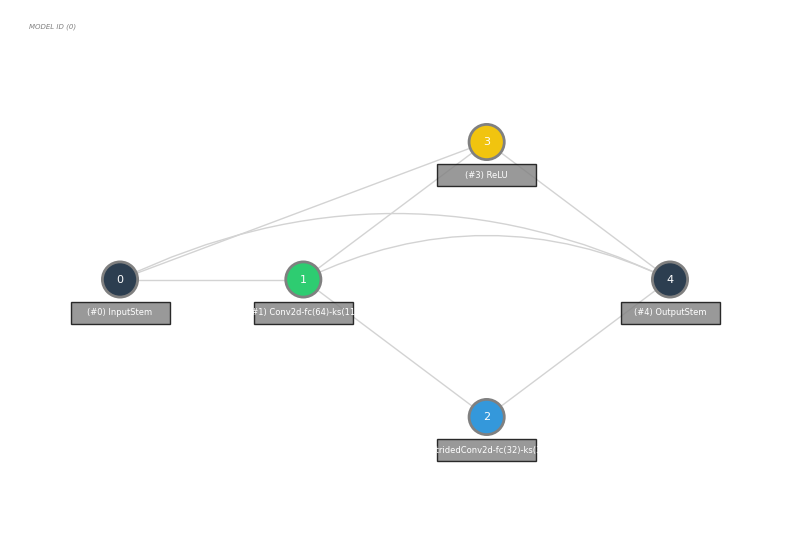

[26/06 09:45:00:226] INFO (caller: optimize_candidates): 
Evaluating Arch 1/3 "be9035feb34c8b5ce719fbef7411c5be"
[26/06 09:45:00:266] INFO (caller: optimize_candidates): 
Model: {
    "adj_matrix": "[[0, 1, 0, 1, 1], [0, 0, 1, 1, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]]",
    "id": "0",
    "learnable_params": "64426",
    "mflops": "55.918592",
    "model_hash": "703554390493850431",
    "nodes": "[\"(InputStem(op=InputStem,id=0,_is_partial=False), {'signature': 'op=InputStem,_is_partial=False'})\", \"(Conv2d(op=Conv2d,id=1,in_shape=(128, 3, 32, 32),out_shape=(128, 64, 32, 32),filter_count=64,kernel_size=11,_is_partial=False), {'signature': 'op=Conv2d,in_shape=(128, 3, 32, 32),out_shape=(128, 64, 32, 32),filter_count=64,kernel_size=11,_is_partial=False'})\", \"(StridedConv2d(op=StridedConv2d,id=2,in_shape=(128, 64, 32, 32),out_shape=(128, 32, 15, 15),filter_count=32,kernel_size=3,stride=2,_is_partial=False), {'signature': 'op=StridedConv2d,in_shape=(128, 64, 32, 32),out_

[26/06 09:45:18.236] PROGRESS: Task (0 v.0: "cifar10") | Epoch 1/2, Batch 391/391 - Loss: 1.8848798759758014, Acc.: 0.30934
[26/06 09:45:21.221] PROGRESS: Task (0 v.0: "cifar10") | Epoch 1/2, Batch 79/79 - Loss: 1.729546693306935, Acc.: 0.3697
[26/06 09:45:37.157] PROGRESS: Task (0 v.0: "cifar10") | Epoch 2/2, Batch 391/391 - Loss: 1.709366231623208, Acc.: 0.37836
[26/06 09:45:40.026] PROGRESS: Task (0 v.0: "cifar10") | Epoch 2/2, Batch 79/79 - Loss: 1.6659172335757484, Acc.: 0.3888


[26/06 09:45:40.100] PROGRESS: XAI: DTD -- Scores {3: -4.669689417369227e-07, 2: -6.343586846924154e-06, 1: -3.1698089060228085e-06}



Completed candidate "be9035feb34c8b5ce719fbef7411c5be" evaluation

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


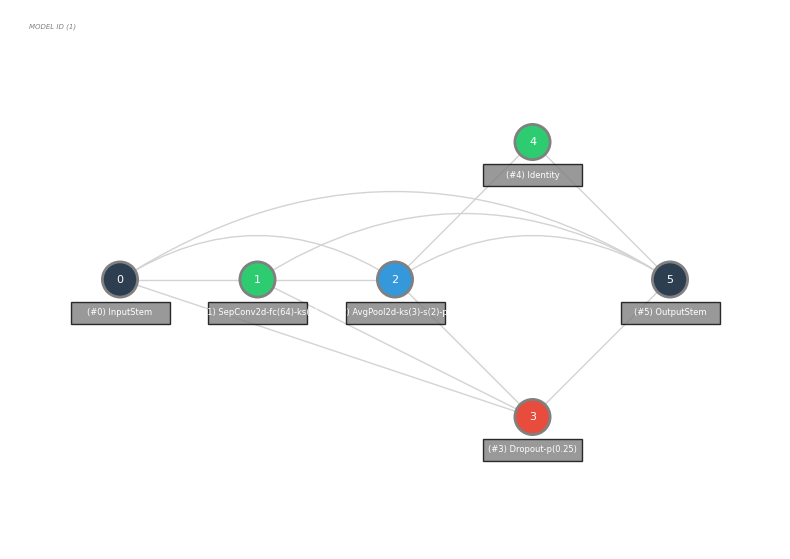

[26/06 09:45:41:280] INFO (caller: optimize_candidates): 
Evaluating Arch 2/3 "1f3553bce3e7051abbeb8fe95f3b0eb6"
[26/06 09:45:41:317] INFO (caller: optimize_candidates): 
Model: {
    "adj_matrix": "[[0, 1, 1, 1, 0, 1], [0, 0, 1, 1, 0, 1], [0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0]]",
    "id": "1",
    "learnable_params": "44584",
    "mflops": "1818.581832",
    "model_hash": "4667960581227275240",
    "nodes": "[\"(InputStem(op=InputStem,id=0,_is_partial=False), {'signature': 'op=InputStem,_is_partial=False'})\", \"(SepConv2d(op=SepConv2d,id=1,in_shape=(128, 3, 32, 32),out_shape=(128, 64, 32, 32),filter_count=64,kernel_size=3,_is_partial=False), {'signature': 'op=SepConv2d,in_shape=(128, 3, 32, 32),out_shape=(128, 64, 32, 32),filter_count=64,kernel_size=3,_is_partial=False'})\", \"(AvgPool2d(op=AvgPool2d,id=2,in_shape=(128, 67, 32, 32),out_shape=(128, 67, 15, 15),kernel_size=3,stride=2,padding=0,_is_partial=False), {'signature': 'op=AvgPool2d,in_s

[26/06 09:46:00.575] PROGRESS: Task (0 v.0: "cifar10") | Epoch 1/2, Batch 391/391 - Loss: 2.100776663826555, Acc.: 0.21136
[26/06 09:46:03.931] PROGRESS: Task (0 v.0: "cifar10") | Epoch 1/2, Batch 79/79 - Loss: 2.0647481860993784, Acc.: 0.2245
[26/06 09:46:22.580] PROGRESS: Task (0 v.0: "cifar10") | Epoch 2/2, Batch 382/391 - Loss: 2.0153920208401694, Acc.: 0.23194126308900523

KeyboardInterrupt: 

In [ ]:

OPERATIONS = [
    Conv2d,
    SepConv2d,
    DilatedConv2d,
    Identity,

    MaxPool2d,
    AvgPool2d,
    # GlobalAvgPool2d, # flattens the spatial dimensions (keeps the channel
                       # dim), hence invalidating most operations it precedes
    TransformChannels,
    ReduceResolution,
    StridedConv2d,
    StridedSepConv,

    BatchNormalization,
    LayerNormalization,
    GroupNormalization,
    InstanceNormalization,
    Dropout,

    ReLU,
    Swish,
    HSwish,
    LeakyReLU,

    # ConvBnReluBlock,
    # ResidualBlock,
    # InceptionBlock
]

config = Params.get_args()

# set_reproducible(random_seed=42)

# Datasets
mnist_dataset = VisionDataSource(path='./mnist/',
                                 dataset=VisionDataSource.Dataset.MNIST,
                                 transform=mnist_transforms(),
                                 autoload=True)
mnist_obj = ICObjective()
mnist_obj.add_criterion(metric=ICObjective.Metric.VAL_ACC,
                        min_threshold=0.6,
                        target_threshold=0.9,
                        thresholds_enabled=False,
                        score_weight=0.7)   # score weights will be normalized;
                                            # they are just relative to each
                                            # other
mnist_obj.add_criterion(metric=ICObjective.Metric.MODEL_SIZE,
                        score_weight=0.1)
mnist_obj.add_criterion(metric=ICObjective.Metric.TRAIN_ACC_CONV,
                        score_weight=0.2)

cifar10_dataset = VisionDataSource(path='./cifar10/',
                                   dataset=VisionDataSource.Dataset.CIFAR10,
                                   transform=cifar10_transforms(),
                                   autoload=True)
cifar10_obj = ICObjective()
cifar10_obj.add_criterion(metric=ICObjective.Metric.VAL_ACC,
                          min_threshold=0.6,
                          target_threshold=0.9,
                          thresholds_enabled=False,
                          score_weight=0.8)
cifar10_obj.add_criterion(metric=ICObjective.Metric.TRAIN_ACC_CONV,
                          score_weight=0.2,
                          thresholds_enabled=False)

VisionDataSource.download_cifar100(path='./cifar100/',
                                   force_overwrite=False,
                                   allow_segmentation=True)

# Search Space
ss = LWSearchSpace(
    num_vertices=6,
    operations=OPERATIONS,
    encoding='multi-branch',
)

ss.register_sampling_hook('spatial_ops_boost', spatial_ops_boost_hook)

# Tasks
def visiontaskfactory(id, version, name, datasource, obj=None):
    task = VisionTask(id=id, version=version, name=name, datasource=datasource,
                      search_space=ss,
                      nas_epochs=3, candidate_epochs=2, objective=obj,
                      callbacks=[])
    input_shape, output_shape = task.shapes

    Logger.info(f'Task ({id}; {name}) - Shapes: {input_shape} | {output_shape}')

    return task


task_manager = TaskManager()
task_manager.add_task(visiontaskfactory(0, 0, 'cifar10', cifar10_dataset,
                                        cifar10_obj))
task_manager.add_task(visiontaskfactory(1, 0, 'mnist', mnist_dataset,
                                        mnist_obj))


c100_ds = VisionDataSource.Dataset.CIFAR100
for seg_idx in range(10):
    # segment_size = 10
    tns = cifar100_transforms()
    seg_task = VisionDataSource.class_segmentation_factory('./cifar100',
                                                           dataset=c100_ds,
                                                           segment_size=10,
                                                           segment_idx=seg_idx,
                                                           transform=tns)

    cifar100_obj = ICObjective()
    cifar100_obj.add_criterion(metric=ICObjective.Metric.VAL_ACC,
                               min_threshold=0.15,
                               target_threshold=0.9,
                               thresholds_enabled=True,
                               score_weight=0.8)
    cifar100_obj.add_criterion(metric=ICObjective.Metric.TRAIN_ACC_CONV,
                               score_weight=0.1)
    cifar100_obj.add_criterion(metric=ICObjective.Metric.COMP_PERF,
                               score_weight=0.1)
    task_manager.add_task(visiontaskfactory(2, seg_idx,
                                            f'cifar100_{seg_idx}', seg_task,
                                            cifar100_obj))


# Optimizer
search_algorithm = RandomSearch()


# XAI Interpreter
xai_interpreter = DeepTaylorDecomposition(false_pred_count=32,
                                          true_pred_count=32)


# Evaluation Strategy
evaluation_strategy = ImageClassificationEvaluator(
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    save_training_logs=True,
    verbose=True,
    xai_interpreter=xai_interpreter
)


# Neural Architecture Search
nas = ContinualNAS(search_algorithm=search_algorithm,
                   evaluation_strategy=evaluation_strategy)

try:
    nas.run(task_manager=task_manager)
except Exception as e:
    print(e)
    raise e
#finally:
    # runtime.unassign()



In [ ]:
nas.optimizer._best_candidate

In [ ]:
adj_matrix = np.array([[0, 1, 1, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 0, 1], [0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0]]);

pred, succ = predecessor_successor_lists(adj_matrix)

succ

[[1, 2, 3, 4], [2, 3], [3, 4, 6], [5, 6], [3, 5], [], [5]]

## Collate Results

<!---  
$ignore-module=True
-->

In [ ]:
!find /content -maxdepth 1 -type d \( -name training_logs -o -name nas_results -o -name plots -o -name model_metrics -o -name tasks \) | zip -r results.zip -@

  adding: content/gdrive/MyDrive/PhD/NASKit/plots/ (stored 0%)
  adding: content/gdrive/MyDrive/PhD/NASKit/plots/model_1_v2.svg (deflated 79%)
  adding: content/gdrive/MyDrive/PhD/NASKit/plots/model_1_v1.svg (deflated 75%)
  adding: content/gdrive/MyDrive/PhD/NASKit/plots/model_0_v1.svg (deflated 75%)
  adding: content/gdrive/MyDrive/PhD/NASKit/training_logs/ (stored 0%)
  adding: content/gdrive/MyDrive/PhD/NASKit/training_logs/2900676297973850959.txt (deflated 81%)
  adding: content/gdrive/MyDrive/PhD/NASKit/training_logs/-7843224659262453008.txt (deflated 81%)
  adding: content/gdrive/MyDrive/PhD/NASKit/training_logs/-6305422713374061575.txt (deflated 82%)
  adding: content/gdrive/MyDrive/PhD/NASKit/training_logs/7773903318826398693.txt (deflated 81%)
  adding: content/gdrive/MyDrive/PhD/NASKit/training_logs/727984449068491063.txt (deflated 81%)
  adding: content/gdrive/MyDrive/PhD/NASKit/training_logs/8272421828646875578.txt (deflated 81%)
  adding: content/gdrive/MyDrive/PhD/NASKit

## Scratchpad

<!---  
$ignore-module=True
-->

In [ ]:
import torch
import numpy as np
from scipy.spatial import distance
from scipy.stats import wasserstein_distance, entropy

def dataset_embedding(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    print('loaded; prepping')
    data = next(iter(loader))[0].numpy()  # Assuming the dataset tuples are (data, target)
    print('reshape')
    data = data.reshape(data.shape[0], -1)  # Flatten the data

    print('mean + variance starting...')
    # Calculate mean and variance
    means = np.mean(data, axis=0)
    variances = np.var(data, axis=0)
    print('histograms starting...')
    # Calculate histograms and Wasserstein distance (EMD)
    hist_distances = []
    for i in range(data.shape[1]):
        hist1, _ = np.histogram(data[:, i], bins=10, range=(data[:, i].min(), data[:, i].max()))
        hist2, _ = np.histogram(data[:, i], bins=10, range=(data[:, i].min(), data[:, i].max()))
        hist_distances.append(wasserstein_distance(hist1, hist2))

    print('\n\nhist', hist_distances)
    # Calculate correlation matrix and its Frobenius norm
    print('correlation matrix starting...')
    correlation_matrix = np.corrcoef(data, rowvar=False)
    print('\n\ncorr', correlation_matrix)
    print('norm corr starting...')
    norm_correlation = np.linalg.norm(correlation_matrix - np.eye(correlation_matrix.shape[0]))

    print('\n\nnorm corr', norm_correlation)
    # Combine all embeddings into a single vector

    print('concat starting...')
    embedding = np.concatenate((means, variances, hist_distances, [norm_correlation]))
    return embedding

# Example usage with a PyTorch dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Load a sample dataset (e.g., MNIST)
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_embedding = dataset_embedding(mnist)
print("Dataset Embedding:", mnist_embedding)
print("sum", sum(mnist_embedding))

loaded; prepping
reshape
mean + variance starting...
histograms starting...


hist [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
# g = rs.search()
# g.visualize(show_plot=False)

In [ ]:
# l = [list(g.successors(node)) for node in g.nodes()]
# l[0]

In [ ]:
# print(nx.shortest_path_length(g, list(g.nodes())[0]).values())
# print([node.depth for node in g.nodes()])

In [ ]:
# g.compile_network(rs.input_shape, rs.num_classes)
# g.get_architecture()
# Logger.debug(g.compiled_ops)
# g.visualize()

In [ ]:
# g = nx.DiGraph()

# g.add_edges_from([[1, 2], [1,3], [2,4], [4, 5]])
# nx.weisfeiler_lehman_graph_hash(g)

In [ ]:
# arr = nx.adjacency_matrix(g).toarray().tolist()

In [ ]:
# g2 = nx.DiGraph()

# g2.add_nodes_from([(1, {'index': 3}), (2, {'index': 1}), (3, {'index': 4}), (4, {'index': 2}), (5, {'index': 5})])
# g2.add_edges_from([[1, 2], [1,3], [2,4], [4, 5]])
# nx.weisfeiler_lehman_graph_hash(g2, node_attr='index')

'03e1277d2b6d6ab299c74c2ec9252343'

In [ ]:
# g2 = nx.DiGraph()

# g2.add_nodes_from([(1, {'index': 3}), (2, {'index': 4}), (3, {'index': 1}), (4, {'index': 2}), (5, {'index': 5})])
# g2.add_edges_from([[1, 2], [1,3], [2,4], [4, 5]])
# nx.weisfeiler_lehman_graph_hash(g2, node_attr='index')

In [ ]:
# g.operations[0].flops

In [ ]:
# traced_model = torch.jit.trace(g, torch.rand(1, 3, 32, 32))

In [ ]:
# scripted_model = torch.jit.script(traced_model)

In [ ]:
# torch.jit.save(scripted_model, "scripted_model.pt")

In [ ]:
# !pip install -q netron
# !curl --output smartreply.zip https://storage.googleapis.com/download.tensorflow.org/models/tflite/smartreply_1.0_2017_11_01.zip
# !unzip smartreply.zip

In [ ]:
# import netron
# import portpicker
# from google.colab import output

# port = portpicker.pick_unused_port()

# # Read the model file and start the netron browser.
# with output.temporary():
#     netron.start()
#     netron.start('scripted_model.pt', port, browse=False)

# output.serve_kernel_port_as_iframe(port, height='800')

In [ ]:
# type(traced_model.graph)

In [ ]:
# """
# LRP RULES
# """

# def lrp_conv2d(self, R, layer):
#     # Get weights and activations from the layer
#     weight = layer.weight.data
#     activation = layer.input  # Assuming you saved the input to the layer during forward pass

#     # Compute the Z values (activation * weight) and normalize them
#     Z = F.conv2d(activation, weight, stride=layer.stride, padding=layer.padding, groups=layer.groups)
#     Z += 1e-9  # To avoid division by zero
#     S = R / Z  # Redistribution ratio

#     # Compute the gradient with respect to the input
#     C = torch.nn.grad.conv2d_input(activation.shape, weight, S, stride=layer.stride, padding=layer.padding, groups=layer.groups)
#     return C


# def lrp_maxpool2d(self, R, layer):
#     # Get the activation from the layer
#     activation = layer.input  # Assuming you saved the input to the layer during forward pass

#     # Perform max pooling on the activation to find the max values
#     max_pool = F.max_pool2d(activation, layer.kernel_size, layer.stride, layer.padding, return_indices=True)
#     max_activations, indices = max_pool

#     # Route relevance to the max locations
#     relevance = torch.zeros_like(activation)
#     relevance = relevance.scatter_(1, indices, R)

#     return relevance


# def lrp_batchnorm(self, R, layer):
#     # Get the necessary parameters from the layer
#     activation = layer.input  # Assuming you saved the input to the layer during forward pass
#     mean = layer.running_mean
#     var = layer.running_var
#     weight = layer.weight
#     bias = layer.bias

#     # Normalize the input
#     normalized_input = (activation - mean[None, :, None, None]) / torch.sqrt(var[None, :, None, None] + layer.eps)

#     # Calculate the Z values
#     Z = normalized_input * weight[None, :, None, None] + bias[None, :, None, None]
#     Z += 1e-9  # To avoid division by zero
#     S = R / Z  # Redistribution ratio

#     # Propagate the relevance to the input
#     C = S * normalized_input
#     return C
